<a href="https://colab.research.google.com/github/davidelgas/DataSciencePortfolio/blob/main/Homelessness/Notebook/Homelessness_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

To monitor homelessness, state and federal agencies collect data through separate systems. The U.S. Department of Housing and Urban Development (HUD) conducts annual Point-in-Time (PIT) counts that capture the number of people experiencing homelessness on a single night in January, while the U.S. Census Bureau collects comprehensive population demographics through the decennial Census and annual American Community Survey. These datasets use different definitions, geographic boundaries, and timing. This results in barriers to calculating homelessness rates essential for comparative analysis and evidence-based policy development.

This study integrates HUD Point-in-Time counts with Census demographic data across several California metropolitan areas, leveraging geospatial analysis to create a dataset with both homelessness populations and total populations. The resulting dataset reveals significant geographic variation in homelessness rates and enables demographic analysis previously challenging due to data silos. This framework enables analysis of available demographic patterns and provides a replicable methodology for other metropolitan areas. The dataset described here is being released through a Kaggle machine learning competition to accelerate research progress on understanding the factors that lead to homelessness and resource allocation.

Data Sources:
- 2022 HUD Point-in-Time Count Summary Reports (publicly available via HUD Exchange)
- ACS 2018–2022 5-Year Estimates (publicly available via U.S. Census Bureau)
- Some historical reports recovered via the Internet Archive’s Wayback Machine
All data has been aggregated to the city or district level. No individual-level or personally identifiable data is included.



# Prepare Enviornment

In [ ]:
# ================================================================================
# === ACCESS GOOGLE DRIVE & ENVIRONMENT SETUP ===
# ================================================================================

# Safe fresh mount
from google.colab import drive

drive.mount('/content/drive')


# Core Libraries
import os
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import warnings
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from matplotlib.ticker import PercentFormatter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



# Add the project folder to Python's path
import sys

sys.path.append('/content/drive/MyDrive/Kaggle/Notebook')

# Import global published data
try:
    from config import PUBLISHED_POPULATIONS, PUBLISHED_HOMELESSNESS
    print("Available populations:", list(PUBLISHED_POPULATIONS.keys()))
    if 'PUBLISHED_HOMELESSNESS' in globals():
        print("Available homelessness data:", list(PUBLISHED_HOMELESSNESS.keys()))
except ImportError as e:
    print(f"Warning: Could not import config: {e}")
    print("Continuing without published data...")
    PUBLISHED_POPULATIONS = {}
    PUBLISHED_HOMELESSNESS = {}

print("Setup complete!")


Mounted at /content/drive
Available populations: ['Los Angeles City', 'San Diego County', 'Orange County', 'Riverside County', 'San Bernardino County', 'Santa Clara County', 'Alameda County', 'Sacramento County', 'San Francisco County', 'Sonoma County']
Available homelessness data: ['Los Angeles City', 'San Diego County', 'Orange County', 'Riverside County', 'San Bernardino County', 'Santa Clara County', 'Alameda County', 'Sacramento County', 'San Francisco County', 'Sonoma County']
Setup complete!


# Geographic Boundary Alignment

## Centroid vs Representative Point


In this project, we integrate homeless counts from HUD with population data from the Census to calculate sub-county homelessness rates across California. To do this, we must assign each Census tract to an administrative region (e.g., city council district or city boundary) so that both homeless counts and population denominators can be aggregated to the same regional units. This spatial assignment step is critical: if tracts are incorrectly mapped, even small errors in population or homeless counts can distort calculated rates and lead to misleading conclusions in downstream policy analysis.

Tracts are commonly assigned to districts using geometric centroids, but this approach can fail when tracts have irregular shapes—such as L-shapes, donuts, or boundaries that follow natural features. In these cases, the centroid may fall outside the actual tract, leading to systematic misclassification: the population from one area may be incorrectly assigned to a neighboring district.

To prevent this, we use representative points, which are guaranteed to fall within each tract’s true boundary. This ensures accurate spatial joins between tracts and administrative districts, preserving the integrity of tract-level data and supporting valid regional homelessness rate calculations. In a policy context where decisions may guide millions in funding, maintaining spatial precision is essential.

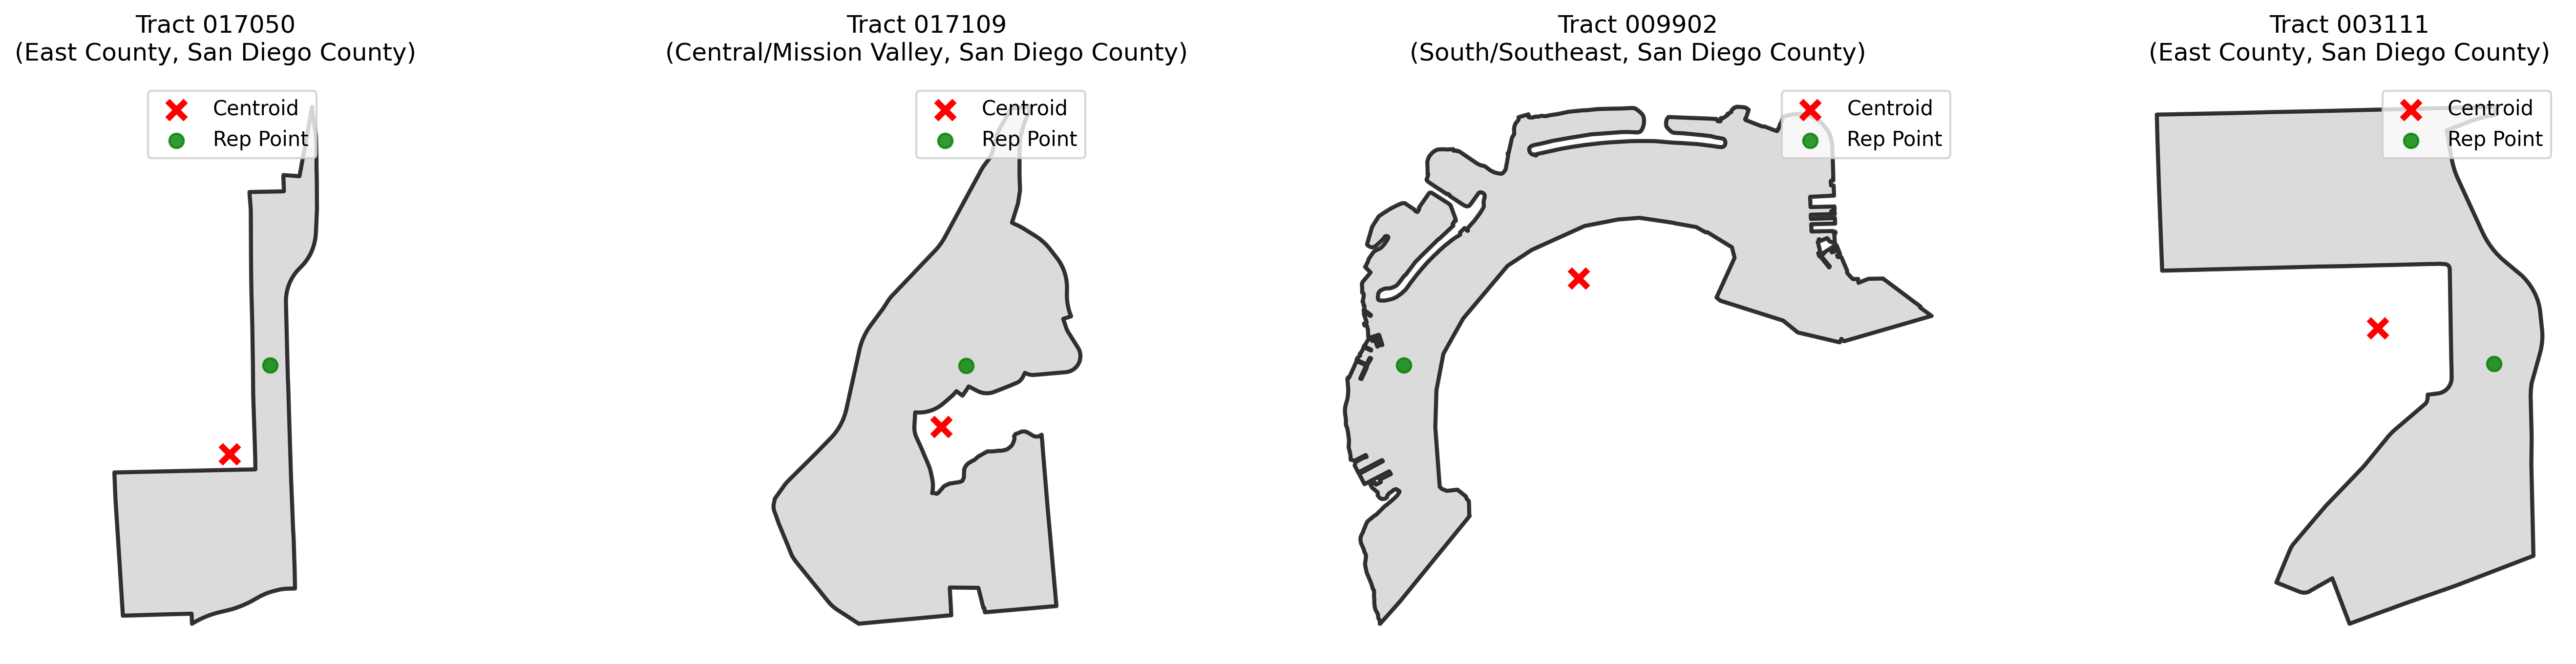

In [ ]:
# Example of Centroid vs Representative Point - HIGH RESOLUTION VERSION

# === Load and filter San Diego tracts ===
tracts = gpd.read_file("/content/drive/MyDrive/Kaggle/Datasets/Shapefiles/tl_2022_06_tract/tl_2022_06_tract.shp")
tracts = tracts[tracts["COUNTYFP"] == "073"].copy()  # San Diego County
tracts = tracts.to_crs(epsg=2227)  # Local projection for accuracy

# === Calculate centroids and representative points ===
tracts["centroid"] = tracts.geometry.centroid
tracts["rep_point"] = tracts.geometry.representative_point()

# === Check which ones fall outside the tract itself ===
centroid_fail = ~tracts.geometry.contains(tracts["centroid"])
rep_point_fail = ~tracts.geometry.contains(tracts["rep_point"])

# === Function to get rough location name based on coordinates ===
def get_location_name(x, y):
    # Rough boundaries for San Diego County areas (in EPSG:2227)
    if x > 7600000 and y > 400000:
        return "North County Inland, San Diego County"
    elif x > 7600000 and y < 400000:
        return "East County, San Diego County"
    elif x < 7560000 and y > 450000:
        return "North County Coastal, San Diego County"
    elif x < 7560000 and y > 400000:
        return "Central Coast, San Diego County"
    elif x < 7560000 and y > 350000:
        return "South Bay/Chula Vista, San Diego County"
    elif x < 7560000 and y < 350000:
        return "South County/Tijuana Border, San Diego County"
    elif y > 400000:
        return "Central/Mission Valley, San Diego County"
    else:
        return "South/Southeast, San Diego County"

# === Get list of failing tract IDs ===
failing_tract_ids = tracts[centroid_fail]['TRACTCE'].tolist()

# === HIGH RESOLUTION PLOT SETTINGS ===
plt.rcParams['figure.dpi'] = 300  # Set high DPI globally
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12    # Increase font size for clarity

# === Plot with higher resolution ===
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Larger figure size

for i, tract_id in enumerate(failing_tract_ids[-4:]):  # Get last 4 tracts
    target_tract = tracts[tracts['TRACTCE'] == tract_id]

    # Get location name
    centroid_x = target_tract['centroid'].iloc[0].x
    centroid_y = target_tract['centroid'].iloc[0].y
    location_name = get_location_name(centroid_x, centroid_y)

    ax = axes[i]

    # Higher quality plotting
    target_tract.plot(ax=ax, color='lightgray', edgecolor='black',
                     linewidth=2, alpha=0.8)
    target_tract['centroid'].plot(ax=ax, color='red', markersize=80,
                                 marker='x', linewidth=3, label="Centroid")
    target_tract['rep_point'].plot(ax=ax, color='green', markersize=50,
                                  marker='o', alpha=0.8, label="Rep Point")

    ax.set_title(f"Tract {tract_id}\n({location_name})", fontsize=12, pad=10)
    ax.legend(fontsize=10, loc='upper right')
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove axis spines for cleaner look
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout(pad=2.0)

# === Save in multiple high-quality formats ===
save_path = '/content/drive/MyDrive/Kaggle/Images/'
plt.savefig(f'{save_path}san_diego_tracts_high_res.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig(f'{save_path}san_diego_tracts_vector.svg', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig(f'{save_path}san_diego_tracts_vector.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')

plt.show()

# === Alternative: Create even higher resolution individual plots ===
def create_ultra_high_res_plot(tract_id, dpi=600, save_path='/content/drive/MyDrive/Kaggle/Images/'):
    """Create ultra-high resolution plot for a single tract"""
    target_tract = tracts[tracts['TRACTCE'] == tract_id]

    centroid_x = target_tract['centroid'].iloc[0].x
    centroid_y = target_tract['centroid'].iloc[0].y
    location_name = get_location_name(centroid_x, centroid_y)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=dpi)

    target_tract.plot(ax=ax, color='lightgray', edgecolor='black',
                     linewidth=3, alpha=0.9)
    target_tract['centroid'].plot(ax=ax, color='red', markersize=120,
                                 marker='x', linewidth=4, label="Centroid")
    target_tract['rep_point'].plot(ax=ax, color='green', markersize=80,
                                  marker='o', alpha=0.9, label="Rep Point")

    ax.set_title(f"Tract {tract_id}\n{location_name}", fontsize=16, pad=15)
    ax.legend(fontsize=14, loc='upper right')
    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.savefig(f'{save_path}tract_{tract_id}_ultra_high_res.png', dpi=dpi,
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()

# Example: Create ultra-high res version of the first failing tract
# create_ultra_high_res_plot(failing_tract_ids[-1], dpi=600)

# Homelessness Populations

To support localized analysis of homelessness rates, we selected the most granular geographic units available for each jurisdiction. Where Point-in-Time (PIT) counts were reported by political boundaries—such as city council or supervisor districts—we aligned population denominators to those same districts using official shapefiles. In other cases, PIT data was available only at the city level, and we used U.S. Census-defined place boundaries to match population totals. While the specific geographic units vary by county, our approach ensures that population and homelessness counts are consistently aligned within each region, allowing for valid rate comparisons and spatial analysis across all areas included in the study.



## Alameda County

In [ ]:
# ================================================================================
# ALAMEDA COUNTY - PUBLISHED HOMELESS DATA CAPTURE
# ================================================================================

# Notes on the Alamdea CoCO
# "The incorporated cities are Alameda, Albany, Berkeley, Dublin, Emeryville, Fremont, Hayward, Livermore, Newark, Oakland, Piedmont, Pleasanton, San Leandro, and Union City.

# The unincorporated communities are Ashland, Castlewood, Castro Valley, Cherryland, Fairview, Happy Valley, Hillcrest Knolls, San Lorenzo, and Sunol.

# ================================================================================
# FILE PATHS
# ================================================================================
base_path = "/content/drive/MyDrive/Kaggle/Datasets"
county = "Alameda County"
output_dir = os.path.join(base_path, "Counties", county, "Output")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "al_homeless_data.csv")

# ================================================================================
# PUBLISHED DATA
# ================================================================================
al_homeless_data = [
    {"REGION_CODE": "AL_01", "REGION_NAME": "Alameda",            "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 264},
    {"REGION_CODE": "AL_02", "REGION_NAME": "Albany",             "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 23},
    {"REGION_CODE": "AL_03", "REGION_NAME": "Berkeley",           "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 1057},
    {"REGION_CODE": "AL_04", "REGION_NAME": "Dublin",             "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 29},
    {"REGION_CODE": "AL_05", "REGION_NAME": "Emeryville",         "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 91},
    {"REGION_CODE": "AL_06", "REGION_NAME": "Fremont",            "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 1026},
    {"REGION_CODE": "AL_07", "REGION_NAME": "Hayward",            "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 381},
    {"REGION_CODE": "AL_08", "REGION_NAME": "Livermore",          "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 242},
    {"REGION_CODE": "AL_09", "REGION_NAME": "Newark",             "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 58},
    {"REGION_CODE": "AL_10", "REGION_NAME": "Oakland",            "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 5055},
    {"REGION_CODE": "AL_11", "REGION_NAME": "Piedmont",           "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 42},
    {"REGION_CODE": "AL_12", "REGION_NAME": "Pleasanton",         "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 72},
    {"REGION_CODE": "AL_13", "REGION_NAME": "San Leandro",        "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 409},
    {"REGION_CODE": "AL_14", "REGION_NAME": "Union City",         "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 489},
    {"REGION_CODE": "AL_15", "REGION_NAME": "Unincorporated",     "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 509}
]

# ================================================================================
# CREATE DATAFRAME
# ================================================================================
df = pd.DataFrame(al_homeless_data)
df["METRO"] = county
df = df[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "HOMELESS_POPULATION"]]

# ================================================================================
# DISPLAY DATAFRAME
# ================================================================================
print(df.to_string(index=False))

# ================================================================================
# SAVE DATAFRAME
# ================================================================================
df.to_csv(output_file, index=False)
print()
print(f"Total records: {len(df)}")
print(f"Total homeless population: {df['HOMELESS_POPULATION'].sum()}")

# Add published homelessness lookup
try:
    from config import PUBLISHED_HOMELESSNESS
    published_homeless = PUBLISHED_HOMELESSNESS.get("Alameda County")
    if published_homeless:
        print(f"Published homeless population: {published_homeless}")
except ImportError:
    print("Published homelessness data not available (config.py not found)")

print(f"File saved to: {output_file}")
print("Alameda County homeless data capture complete.")

         METRO REGION_CODE    REGION_NAME         REGION_TYPE  HOMELESS_POPULATION
Alameda County       AL_01        Alameda   Incorporated City                  264
Alameda County       AL_02         Albany   Incorporated City                   23
Alameda County       AL_03       Berkeley   Incorporated City                 1057
Alameda County       AL_04         Dublin   Incorporated City                   29
Alameda County       AL_05     Emeryville   Incorporated City                   91
Alameda County       AL_06        Fremont   Incorporated City                 1026
Alameda County       AL_07        Hayward   Incorporated City                  381
Alameda County       AL_08      Livermore   Incorporated City                  242
Alameda County       AL_09         Newark   Incorporated City                   58
Alameda County       AL_10        Oakland   Incorporated City                 5055
Alameda County       AL_11       Piedmont   Incorporated City                   42
Alam

## Los Angeles City

In [ ]:
# ================================================================================
# LOS ANGELES CITY COUNCIL DISTRICTS - PUBLISHED HOMELESS DATA CAPTURE
# ================================================================================


# ================================================================================
# FILE PATHS
# ================================================================================
base_path = "/content/drive/MyDrive/Kaggle/Datasets"
county = "Los Angeles City"
output_dir = os.path.join(base_path, "Counties", county, "Output")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "la_homeless_data.csv")

# ================================================================================
# PUBLISHED DATA
# ================================================================================
la_homeless_data = [
    {"REGION_CODE": "LA_01", "REGION_NAME": "District 1",  "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 3336},
    {"REGION_CODE": "LA_02", "REGION_NAME": "District 2",  "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 1323},
    {"REGION_CODE": "LA_03", "REGION_NAME": "District 3",  "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 1086},
    {"REGION_CODE": "LA_04", "REGION_NAME": "District 4",  "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 1156},
    {"REGION_CODE": "LA_05", "REGION_NAME": "District 5",  "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 1301},
    {"REGION_CODE": "LA_06", "REGION_NAME": "District 6",  "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 3228},
    {"REGION_CODE": "LA_07", "REGION_NAME": "District 7",  "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 1746},
    {"REGION_CODE": "LA_08", "REGION_NAME": "District 8",  "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 3579},
    {"REGION_CODE": "LA_09", "REGION_NAME": "District 9",  "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 5640},
    {"REGION_CODE": "LA_10", "REGION_NAME": "District 10", "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 1743},
    {"REGION_CODE": "LA_11", "REGION_NAME": "District 11", "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 2012},
    {"REGION_CODE": "LA_12", "REGION_NAME": "District 12", "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 1024},
    {"REGION_CODE": "LA_13", "REGION_NAME": "District 13", "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 3093},
    {"REGION_CODE": "LA_14", "REGION_NAME": "District 14", "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 9340},
    {"REGION_CODE": "LA_15", "REGION_NAME": "District 15", "REGION_TYPE": "Council District", "HOMELESS_POPULATION": 2373}
]

# ================================================================================
# CREATE DATAFRAME
# ================================================================================
df = pd.DataFrame(la_homeless_data)
df["METRO"] = "Los Angeles City"
df = df[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "HOMELESS_POPULATION"]]

# ================================================================================
# DISPLAY DATAFRAME
# ================================================================================
print(df.to_string(index=False))

# ================================================================================
# SAVE DATAFRAME
# ================================================================================
df.to_csv(output_file, index=False)
print()
print(f"Total records: {len(df)}")
print(f"Total homeless population: {df['HOMELESS_POPULATION'].sum()}")

# Add published homelessness lookup
try:
    from config import PUBLISHED_HOMELESSNESS
    published_homeless = PUBLISHED_HOMELESSNESS.get("Los Angeles City")
    if published_homeless:
        print(f"Published homeless population: {published_homeless}")
except ImportError:
    print("Published homelessness data not available (config.py not found)")

print(f"File saved to: {output_file}")
print("Los Angeles City Council Districts homeless data capture complete.")

           METRO REGION_CODE REGION_NAME      REGION_TYPE  HOMELESS_POPULATION
Los Angeles City       LA_01  District 1 Council District                 3336
Los Angeles City       LA_02  District 2 Council District                 1323
Los Angeles City       LA_03  District 3 Council District                 1086
Los Angeles City       LA_04  District 4 Council District                 1156
Los Angeles City       LA_05  District 5 Council District                 1301
Los Angeles City       LA_06  District 6 Council District                 3228
Los Angeles City       LA_07  District 7 Council District                 1746
Los Angeles City       LA_08  District 8 Council District                 3579
Los Angeles City       LA_09  District 9 Council District                 5640
Los Angeles City       LA_10 District 10 Council District                 1743
Los Angeles City       LA_11 District 11 Council District                 2012
Los Angeles City       LA_12 District 12 Council Dis

## Orange County

In [ ]:
# ================================================================================
# ORANGE COUNTY - PUBLISHED HOMELESS DATA CAPTURE
# ================================================================================

# ================================================================================
# FILE PATHS
# ================================================================================
base_path = "/content/drive/MyDrive/Kaggle/Datasets"
county = "Orange County"
output_dir = os.path.join(base_path, "Counties", county, "Output")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "oc_homeless_data.csv")

# ================================================================================
# PUBLISHED DATA
# ================================================================================
oc_homeless_data = [
              {"REGION_CODE": "OC_01", "REGION_NAME": "Anaheim", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 1074},
              {"REGION_CODE": "OC_02", "REGION_NAME": "Brea", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 24},
              {"REGION_CODE": "OC_03", "REGION_NAME": "Buena Park", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 266},
              {"REGION_CODE": "OC_04", "REGION_NAME": "Cypress", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 28},
              {"REGION_CODE": "OC_05", "REGION_NAME": "Fullerton", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 272},
              {"REGION_CODE": "OC_06", "REGION_NAME": "La Habra", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 45},
              {"REGION_CODE": "OC_07", "REGION_NAME": "La Palma", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 8},
              {"REGION_CODE": "OC_08", "REGION_NAME": "Los Alamitos", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 13},
              {"REGION_CODE": "OC_09", "REGION_NAME": "Orange", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 250},
              {"REGION_CODE": "OC_10", "REGION_NAME": "Placentia", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 198},
              {"REGION_CODE": "OC_11", "REGION_NAME": "Stanton", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 210},
              {"REGION_CODE": "OC_12", "REGION_NAME": "Villa Park", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 4},
              {"REGION_CODE": "OC_13", "REGION_NAME": "Yorba Linda", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 1},

              {"REGION_CODE": "OC_14", "REGION_NAME": "Costa Mesa", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 208},
              {"REGION_CODE": "OC_15", "REGION_NAME": "Fountain Valley", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 38},
              {"REGION_CODE": "OC_16", "REGION_NAME": "Garden Grove", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 391},
              {"REGION_CODE": "OC_17", "REGION_NAME": "Huntington Beach", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 330},
              {"REGION_CODE": "OC_18", "REGION_NAME": "Newport Beach", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 96},
              {"REGION_CODE": "OC_19", "REGION_NAME": "Santa Ana", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 990},
              {"REGION_CODE": "OC_20", "REGION_NAME": "Seal Beach", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 8},
              {"REGION_CODE": "OC_21", "REGION_NAME": "Tustin", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 318},
              {"REGION_CODE": "OC_22", "REGION_NAME": "Westminster", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 159},

              {"REGION_CODE": "OC_23", "REGION_NAME": "Aliso Viejo", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 17},
              {"REGION_CODE": "OC_24", "REGION_NAME": "Dana Point", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 27},
              {"REGION_CODE": "OC_25", "REGION_NAME": "Irvine", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 60},
              {"REGION_CODE": "OC_26", "REGION_NAME": "Laguna Beach", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 83},
              {"REGION_CODE": "OC_27", "REGION_NAME": "Laguna Hills", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 12},
              {"REGION_CODE": "OC_28", "REGION_NAME": "Laguna Niguel", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 29},
              {"REGION_CODE": "OC_29", "REGION_NAME": "Laguna Woods", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 7},
              {"REGION_CODE": "OC_30", "REGION_NAME": "Lake Forest", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 76},
              {"REGION_CODE": "OC_31", "REGION_NAME": "Mission Viejo", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 28},
              {"REGION_CODE": "OC_32", "REGION_NAME": "Rancho Santa Margarita", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 7},
              {"REGION_CODE": "OC_33", "REGION_NAME": "San Clemente", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 131},
              {"REGION_CODE": "OC_34", "REGION_NAME": "San Juan Capistrano", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 65},

              {"REGION_CODE": "OC_35", "REGION_NAME": "County Unincorporated", "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 50},
              {"REGION_CODE": "OC_36", "REGION_NAME": "Domestic Violence Programs", "REGION_TYPE": "Special Geographic Area", "HOMELESS_POPULATION": 196}
]

# ================================================================================
# CREATE DATAFRAME
# ================================================================================
df = pd.DataFrame(oc_homeless_data)
df["METRO"] = "Orange County"
df = df[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "HOMELESS_POPULATION"]]

# ================================================================================
# DISPLAY DATAFRAME
# ================================================================================
print(df.to_string(index=False))

# ================================================================================
# SAVE DATAFRAME
# ================================================================================
df.to_csv(output_file, index=False)
print()
print(f"Total records: {len(df)}")
print(f"Total homeless population: {df['HOMELESS_POPULATION'].sum()}")

# Add published homelessness lookup
try:
    from config import PUBLISHED_HOMELESSNESS
    published_homeless = PUBLISHED_HOMELESSNESS.get("Orange County")
    if published_homeless:
        print(f"Published homeless population: {published_homeless}")
except ImportError:
    print("Published homelessness data not available (config.py not found)")

print(f"File saved to: {output_file}")
print("Orange County homeless data capture complete.")

        METRO REGION_CODE                REGION_NAME             REGION_TYPE  HOMELESS_POPULATION
Orange County       OC_01                    Anaheim       Incorporated City                 1074
Orange County       OC_02                       Brea       Incorporated City                   24
Orange County       OC_03                 Buena Park       Incorporated City                  266
Orange County       OC_04                    Cypress       Incorporated City                   28
Orange County       OC_05                  Fullerton       Incorporated City                  272
Orange County       OC_06                   La Habra       Incorporated City                   45
Orange County       OC_07                   La Palma       Incorporated City                    8
Orange County       OC_08               Los Alamitos       Incorporated City                   13
Orange County       OC_09                     Orange       Incorporated City                  250
Orange County       

## Riverside County

In [ ]:
# ================================================================================
# RIVERSIDE COUNTY - PUBLISHED HOMELESS DATA CAPTURE
# ================================================================================

"""
# Per RIverside County documents, Riverside counts are split between District 1 (705)
# and District 2 (219). I am going to combine the totals and assign them to RV_03 with
a value of 924 and comment out RV_09
"""


# ================================================================================
# FILE PATHS
# ================================================================================
base_path = "/content/drive/MyDrive/Kaggle/Datasets"
county = "Riverside County"
output_dir = os.path.join(base_path, "Counties", county, "Output")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "rv_homeless_data.csv")

# ================================================================================
# PUBLISHED DATA
# ================================================================================
rv_homeless_data = [
    {"REGION_CODE": "RV_01", "REGION_NAME": "Canyon Lake", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 0},
    {"REGION_CODE": "RV_02", "REGION_NAME": "Lake Elsinore", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 75},
    {"REGION_CODE": "RV_03", "REGION_NAME": "Riverside", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 924},
    {"REGION_CODE": "RV_04", "REGION_NAME": "Wildomar", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 21},


    {"REGION_CODE": "RV_05", "REGION_NAME": "Corona", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 188},
    {"REGION_CODE": "RV_06", "REGION_NAME": "Eastvale", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 23},
    {"REGION_CODE": "RV_07", "REGION_NAME": "Jurupa Valley", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 105},
    {"REGION_CODE": "RV_08", "REGION_NAME": "Norco", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 27},
    #{"REGION_CODE": "RV_03B", "REGION_NAME": "Riverside", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 219},


    {"REGION_CODE": "RV_09", "REGION_NAME": "Hemet", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 167},
    {"REGION_CODE": "RV_10", "REGION_NAME": "Murrieta", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 161},
    {"REGION_CODE": "RV_11", "REGION_NAME": "San Jacinto", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 76},
    {"REGION_CODE": "RV_12", "REGION_NAME": "Temecula", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 67},


    {"REGION_CODE": "RV_13", "REGION_NAME": "Blythe", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 91},
    {"REGION_CODE": "RV_14", "REGION_NAME": "Cathedral City", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 73},
    {"REGION_CODE": "RV_15", "REGION_NAME": "Coachella", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 74},
    {"REGION_CODE": "RV_16", "REGION_NAME": "Desert Hot Springs", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 63},
    {"REGION_CODE": "RV_17", "REGION_NAME": "Indian Wells", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 0},
    {"REGION_CODE": "RV_18", "REGION_NAME": "Indio", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 427},
    {"REGION_CODE": "RV_19", "REGION_NAME": "La Quinta", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 7},
    {"REGION_CODE": "RV_20", "REGION_NAME": "Palm Desert", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 26},
    {"REGION_CODE": "RV_21", "REGION_NAME": "Palm Springs", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 276},
    {"REGION_CODE": "RV_22", "REGION_NAME": "Rancho Mirage", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 3},


    {"REGION_CODE": "RV_23", "REGION_NAME": "Banning", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 65},
    {"REGION_CODE": "RV_24", "REGION_NAME": "Beaumont", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 19},
    {"REGION_CODE": "RV_25", "REGION_NAME": "Calimesa", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 8},
    {"REGION_CODE": "RV_26", "REGION_NAME": "Menifee", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 32},
    {"REGION_CODE": "RV_27", "REGION_NAME": "Moreno Valley", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 87},
    {"REGION_CODE": "RV_28", "REGION_NAME": "Perris", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 70},

    {"REGION_CODE": "RV_29", "REGION_NAME": "Unincorporated", "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 161}
]

# ================================================================================
# CREATE DATAFRAME
# ================================================================================
df = pd.DataFrame(rv_homeless_data)
df["METRO"] = "Riverside County"
df = df[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "HOMELESS_POPULATION"]]

# ================================================================================
# DISPLAY DATAFRAME
# ================================================================================
print(df.to_string(index=False))

# ================================================================================
# SAVE DATAFRAME
# ================================================================================
df.to_csv(output_file, index=False)
print()
print(f"Total records: {len(df)}")
print(f"Total homeless population: {df['HOMELESS_POPULATION'].sum()}")

# Add published homelessness lookup
try:
    from config import PUBLISHED_HOMELESSNESS
    published_homeless = PUBLISHED_HOMELESSNESS.get("Riverside County")
    if published_homeless:
        print(f"Published homeless population: {published_homeless}")
except ImportError:
    print("Published homelessness data not available (config.py not found)")

print(f"File saved to: {output_file}")
print("Riverside County homeless data capture complete.")


           METRO REGION_CODE        REGION_NAME         REGION_TYPE  HOMELESS_POPULATION
Riverside County       RV_01        Canyon Lake   Incorporated City                    0
Riverside County       RV_02      Lake Elsinore   Incorporated City                   75
Riverside County       RV_03          Riverside   Incorporated City                  924
Riverside County       RV_04           Wildomar   Incorporated City                   21
Riverside County       RV_05             Corona   Incorporated City                  188
Riverside County       RV_06           Eastvale   Incorporated City                   23
Riverside County       RV_07      Jurupa Valley   Incorporated City                  105
Riverside County       RV_08              Norco   Incorporated City                   27
Riverside County       RV_09              Hemet   Incorporated City                  167
Riverside County       RV_10           Murrieta   Incorporated City                  161
Riverside County     

## Sacramento County

In [ ]:
# ================================================================================
# SACRAMENTO COUNTY - PUBLISHED HOMELESS DATA CAPTURE
# ================================================================================


# ================================================================================
# FILE PATHS
# ================================================================================
base_path = "/content/drive/MyDrive/Kaggle/Datasets"
county = "Sacramento County"
output_dir = os.path.join(base_path, "Counties", county, "Output")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "sa_homeless_data.csv")

# ================================================================================
# PUBLISHED TOTAL (TBD)
# ================================================================================
sa_unsheltered_data = [
    {"REGION_CODE": "SAC_01", "REGION_NAME": "Sacramento",               "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 5038},
    {"REGION_CODE": "SAC_02", "REGION_NAME": "Citrus Heights",           "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 89},
    {"REGION_CODE": "SAC_03", "REGION_NAME": "Rancho Cordova",           "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 156},
    {"REGION_CODE": "SAC_04", "REGION_NAME": "Elk Grove",                "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 45},
    {"REGION_CODE": "SAC_05", "REGION_NAME": "Folsom",                   "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 20},
    {"REGION_CODE": "SAC_06", "REGION_NAME": "Unincorporated Areas",     "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 1316}
]

#allocations
sa_sheltered_data = [
    {"REGION_CODE": "SAC_01", "REGION_NAME": "Sacramento",               "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 1976},
    {"REGION_CODE": "SAC_02", "REGION_NAME": "Citrus Heights",           "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 35},
    {"REGION_CODE": "SAC_03", "REGION_NAME": "Rancho Cordova",           "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 61},
    {"REGION_CODE": "SAC_04", "REGION_NAME": "Elk Grove",                "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 18},
    {"REGION_CODE": "SAC_05", "REGION_NAME": "Folsom",                   "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 8},
    {"REGION_CODE": "SAC_06", "REGION_NAME": "Unincorporated Areas",     "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 516}
]



sa_homeless_data = [
    {"REGION_CODE": "SAC_01", "REGION_NAME": "Sacramento",               "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 7014},
    {"REGION_CODE": "SAC_02", "REGION_NAME": "Citrus Heights",           "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 124},
    {"REGION_CODE": "SAC_03", "REGION_NAME": "Rancho Cordova",           "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 217},
    {"REGION_CODE": "SAC_04", "REGION_NAME": "Elk Grove",                "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 63},
    {"REGION_CODE": "SAC_05", "REGION_NAME": "Folsom",                   "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 28},
    {"REGION_CODE": "SAC_06", "REGION_NAME": "Unincorporated Areas",     "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 1832}
]



# ================================================================================
# CREATE DATAFRAME
# ================================================================================
df = pd.DataFrame(sa_homeless_data)
df["METRO"] = "Sacramento County"
df = df[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "HOMELESS_POPULATION"]]

# ================================================================================
# DISPLAY DATAFRAME
# ================================================================================
print(df.to_string(index=False))

# ================================================================================
# SAVE DATAFRAME
# ================================================================================
df.to_csv(output_file, index=False)
print(f"\nTotal records: {len(df)}")
print(f"Total homeless population (unsheltered): {df['HOMELESS_POPULATION'].sum()}")

# Add published homelessness lookup
try:
    from config import PUBLISHED_HOMELESSNESS
    published_homeless = PUBLISHED_HOMELESSNESS.get("Sacramento County")
    if published_homeless:
        print(f"Published homeless population: {published_homeless}")
except ImportError:
    print("Published homelessness data not available (config.py not found)")

print(f"File saved to: {output_file}")
print("Sacramento County homeless data capture complete.")

#"American River Parkway counts are inclued in Sacramento per SACRAMENTO STEPS FORWARD


            METRO REGION_CODE          REGION_NAME         REGION_TYPE  HOMELESS_POPULATION
Sacramento County      SAC_01           Sacramento   Incorporated City                 7014
Sacramento County      SAC_02       Citrus Heights   Incorporated City                  124
Sacramento County      SAC_03       Rancho Cordova   Incorporated City                  217
Sacramento County      SAC_04            Elk Grove   Incorporated City                   63
Sacramento County      SAC_05               Folsom   Incorporated City                   28
Sacramento County      SAC_06 Unincorporated Areas Unincorporated Area                 1832

Total records: 6
Total homeless population (unsheltered): 9278
Published homeless population: 9278
File saved to: /content/drive/MyDrive/Kaggle/Datasets/Counties/Sacramento County/Output/sa_homeless_data.csv
Sacramento County homeless data capture complete.


## San Bernardino County

In [ ]:
# ================================================================================
# SAN BERNARDINO COUNTY - PUBLISHED HOMELESS DATA CAPTURE
# ================================================================================


# ================================================================================
# FILE PATHS
# ================================================================================
base_path = "/content/drive/MyDrive/Kaggle/Datasets"
county = "San Bernardino County"
output_dir = os.path.join(base_path, "Counties", county, "Output")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "sb_homeless_data.csv")

# ================================================================================
# PUBLISHED DATA
# ================================================================================
sb_homeless_data = [
    {"REGION_CODE": "SB_01", "REGION_NAME": "Adelanto", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 25},
    {"REGION_CODE": "SB_02", "REGION_NAME": "Apple Valley", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 27},
    {"REGION_CODE": "SB_03", "REGION_NAME": "Barstow", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 103},
    {"REGION_CODE": "SB_04", "REGION_NAME": "Big Bear City", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 1},
    {"REGION_CODE": "SB_05", "REGION_NAME": "Big Bear Lake", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 37},
    {"REGION_CODE": "SB_06", "REGION_NAME": "Bloomington", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 11},
    {"REGION_CODE": "SB_07", "REGION_NAME": "Cajon Canyon", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 0},
    {"REGION_CODE": "SB_08", "REGION_NAME": "Chino", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 23},
    {"REGION_CODE": "SB_09", "REGION_NAME": "Chino Hills", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 4},
    {"REGION_CODE": "SB_10", "REGION_NAME": "Colton", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 199},
    {"REGION_CODE": "SB_11", "REGION_NAME": "Crestline", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 13},
    {"REGION_CODE": "SB_12", "REGION_NAME": "Fontana", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 156},
    {"REGION_CODE": "SB_13", "REGION_NAME": "Grand Terrace", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 1},

    {"REGION_CODE": "SB_14", "REGION_NAME": "Hesperia", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 53},
    {"REGION_CODE": "SB_15", "REGION_NAME": "Highland", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 82},
    {"REGION_CODE": "SB_16", "REGION_NAME": "Joshua Tree", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 28},
    {"REGION_CODE": "SB_17", "REGION_NAME": "Lake Arrowhead", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 1},
    {"REGION_CODE": "SB_18", "REGION_NAME": "Landers", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 4},
    {"REGION_CODE": "SB_19", "REGION_NAME": "Lenwood", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 0},
    {"REGION_CODE": "SB_20", "REGION_NAME": "Loma Linda", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 9},
    {"REGION_CODE": "SB_21", "REGION_NAME": "Lytle Creek", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 0},
    {"REGION_CODE": "SB_22", "REGION_NAME": "Mentone/Crafton", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 0},
    {"REGION_CODE": "SB_23", "REGION_NAME": "Montclair", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 37},
    {"REGION_CODE": "SB_24", "REGION_NAME": "Morongo Valley", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 0},
    {"REGION_CODE": "SB_25", "REGION_NAME": "Muscoy", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 13},
    {"REGION_CODE": "SB_26", "REGION_NAME": "Needles", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 9},
    {"REGION_CODE": "SB_27", "REGION_NAME": "Ontario", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 193},
    {"REGION_CODE": "SB_28", "REGION_NAME": "Phelan/Pinion Hills", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 1},
    {"REGION_CODE": "SB_29", "REGION_NAME": "Rancho Cucamonga", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 47},
    {"REGION_CODE": "SB_30", "REGION_NAME": "Redlands", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 184},
    {"REGION_CODE": "SB_31", "REGION_NAME": "Rialto", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 70},
    {"REGION_CODE": "SB_32", "REGION_NAME": "Running Springs", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 7},
    {"REGION_CODE": "SB_33", "REGION_NAME": "San Bernardino", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 1350},
    {"REGION_CODE": "SB_34", "REGION_NAME": "Twentynine Palms", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 15},
    {"REGION_CODE": "SB_35", "REGION_NAME": "Upland", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 89},
    {"REGION_CODE": "SB_36", "REGION_NAME": "Victorville", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 455},
    {"REGION_CODE": "SB_37", "REGION_NAME": "West Cajon Valley", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 0},
    {"REGION_CODE": "SB_38", "REGION_NAME": "Yermo", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 0},
    {"REGION_CODE": "SB_39", "REGION_NAME": "Yucaipa", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 11},
    {"REGION_CODE": "SB_40", "REGION_NAME": "Yucca Valley", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 57},
    {"REGION_CODE": "SB_41", "REGION_NAME": "Unincorporated", "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 18}
]

# ================================================================================
# CREATE DATAFRAME
# ================================================================================
df = pd.DataFrame(sb_homeless_data)
df["METRO"] = "San Bernardino County"
df = df[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "HOMELESS_POPULATION"]]

# ================================================================================
# DISPLAY DATAFRAME
# ================================================================================
print(df.to_string(index=False))

# ================================================================================
# SAVE DATAFRAME
# ================================================================================
df.to_csv(output_file, index=False)
print()
print(f"Total records: {len(df)}")
print(f"Total homeless population: {df['HOMELESS_POPULATION'].sum()}")

# Add published homelessness lookup
try:
    from config import PUBLISHED_HOMELESSNESS
    published_homeless = PUBLISHED_HOMELESSNESS.get("San Bernardino County")
    if published_homeless:
        print(f"Published homeless population: {published_homeless}")
except ImportError:
    print("Published homelessness data not available (config.py not found)")

print(f"File saved to: {output_file}")
print("San Bernardino County homeless data capture complete.")

                METRO REGION_CODE         REGION_NAME         REGION_TYPE  HOMELESS_POPULATION
San Bernardino County       SB_01            Adelanto   Incorporated City                   25
San Bernardino County       SB_02        Apple Valley   Incorporated City                   27
San Bernardino County       SB_03             Barstow   Incorporated City                  103
San Bernardino County       SB_04       Big Bear City   Incorporated City                    1
San Bernardino County       SB_05       Big Bear Lake   Incorporated City                   37
San Bernardino County       SB_06         Bloomington   Incorporated City                   11
San Bernardino County       SB_07        Cajon Canyon   Incorporated City                    0
San Bernardino County       SB_08               Chino   Incorporated City                   23
San Bernardino County       SB_09         Chino Hills   Incorporated City                    4
San Bernardino County       SB_10              Col

## San Diego County

In [ ]:
# ================================================================================
# SAN DIEGO COUNTY - PUBLISHED HOMELESS DATA CAPTURE
# ================================================================================

# ================================================================================
# FILE PATHS
# ================================================================================
base_path = "/content/drive/MyDrive/Kaggle/Datasets"
county = "San Diego County"
output_dir = os.path.join(base_path, "Counties", county, "Output")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "sd_homeless_data.csv")

# ================================================================================
# PUBLISHED DATA
# ================================================================================
sd_homeless_data = [
    {"REGION_CODE": "SD_01", "REGION_NAME": "San Diego", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 4801},
    {"REGION_CODE": "SD_02", "REGION_NAME": "Carlsbad", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 118},
    {"REGION_CODE": "SD_03", "REGION_NAME": "Chula Vista", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 309},
    {"REGION_CODE": "SD_04", "REGION_NAME": "Coronado", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 1},
    {"REGION_CODE": "SD_05", "REGION_NAME": "El Cajon", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 1308},
    {"REGION_CODE": "SD_06", "REGION_NAME": "Encinitas", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 113},
    {"REGION_CODE": "SD_07", "REGION_NAME": "Escondido", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 354},
    {"REGION_CODE": "SD_08", "REGION_NAME": "Imperial Beach", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 25},
    {"REGION_CODE": "SD_09", "REGION_NAME": "La Mesa", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 53},
    {"REGION_CODE": "SD_10", "REGION_NAME": "Lemon Grove", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 31},
    {"REGION_CODE": "SD_11", "REGION_NAME": "National City", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 158},
    {"REGION_CODE": "SD_12", "REGION_NAME": "Oceanside", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 514},
    {"REGION_CODE": "SD_13", "REGION_NAME": "Poway", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 23},
    {"REGION_CODE": "SD_14", "REGION_NAME": "San Marcos", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 12},
    {"REGION_CODE": "SD_15", "REGION_NAME": "Santee", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 147},
    {"REGION_CODE": "SD_16", "REGION_NAME": "Vista", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 117},
    {"REGION_CODE": "SD_17", "REGION_NAME": "Unincorporated Areas", "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 173},
    {"REGION_CODE": "SD_18", "REGION_NAME": "Alpine", "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 1},
    {"REGION_CODE": "SD_19", "REGION_NAME": "Fallbrook", "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 25},
    {"REGION_CODE": "SD_20", "REGION_NAME": "Lakeside", "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 63},
    {"REGION_CODE": "SD_21", "REGION_NAME": "Ramona", "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 21},
    {"REGION_CODE": "SD_22", "REGION_NAME": "Casa de Oro", "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 60}
]

# ================================================================================
# CREATE DATAFRAME
# ================================================================================
df = pd.DataFrame(sd_homeless_data)
df["METRO"] = county

# Reorder columns
df = df[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "HOMELESS_POPULATION"]]

# ================================================================================
# DISPLAY DATAFRAME
# ================================================================================
print(df.to_string(index=False))

# ================================================================================
# SAVE DATAFRAME
# ================================================================================
df.to_csv(output_file, index=False)
print()
print(f"Total records: {len(df)}")
print(f"Total homeless population: {df['HOMELESS_POPULATION'].sum()}")

# Add published homelessness lookup
try:
    from config import PUBLISHED_HOMELESSNESS
    published_homeless = PUBLISHED_HOMELESSNESS.get("San Diego County")
    if published_homeless:
        print(f"Published homeless population: {published_homeless}")
except ImportError:
    print("Published homelessness data not available (config.py not found)")

print(f"File saved to: {output_file}")
print("San Diego County homeless data capture complete.")

           METRO REGION_CODE          REGION_NAME         REGION_TYPE  HOMELESS_POPULATION
San Diego County       SD_01            San Diego   Incorporated City                 4801
San Diego County       SD_02             Carlsbad   Incorporated City                  118
San Diego County       SD_03          Chula Vista   Incorporated City                  309
San Diego County       SD_04             Coronado   Incorporated City                    1
San Diego County       SD_05             El Cajon   Incorporated City                 1308
San Diego County       SD_06            Encinitas   Incorporated City                  113
San Diego County       SD_07            Escondido   Incorporated City                  354
San Diego County       SD_08       Imperial Beach   Incorporated City                   25
San Diego County       SD_09              La Mesa   Incorporated City                   53
San Diego County       SD_10          Lemon Grove   Incorporated City                   31

## San Francisco County

In [ ]:
# ================================================================================
# SAN FRANCISCO COUNTY - PUBLISHED HOMELESS DATA CAPTURE
# ================================================================================

# ================================================================================
# FILE PATHS
# ================================================================================
base_path = "/content/drive/MyDrive/Kaggle/Datasets"
county = "San Francisco County"
output_dir = os.path.join(base_path, "Counties", county, "Output")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "sf_homeless_data.csv")

# ================================================================================
# PUBLISHED DATA
# ================================================================================
sf_homeless_data = [
    {"REGION_CODE": "SF_01", "REGION_NAME": "District 1", "REGION_TYPE": "Supervisorial District", "HOMELESS_POPULATION": 221},
    {"REGION_CODE": "SF_02", "REGION_NAME": "District 2", "REGION_TYPE": "Supervisorial District", "HOMELESS_POPULATION": 158},
    {"REGION_CODE": "SF_03", "REGION_NAME": "District 3", "REGION_TYPE": "Supervisorial District", "HOMELESS_POPULATION": 391},
    {"REGION_CODE": "SF_04", "REGION_NAME": "District 4", "REGION_TYPE": "Supervisorial District", "HOMELESS_POPULATION": 81},
    {"REGION_CODE": "SF_05", "REGION_NAME": "District 5", "REGION_TYPE": "Supervisorial District", "HOMELESS_POPULATION": 697},
    {"REGION_CODE": "SF_06", "REGION_NAME": "District 6", "REGION_TYPE": "Supervisorial District", "HOMELESS_POPULATION": 3848},
    {"REGION_CODE": "SF_07", "REGION_NAME": "District 7", "REGION_TYPE": "Supervisorial District", "HOMELESS_POPULATION": 163},
    {"REGION_CODE": "SF_08", "REGION_NAME": "District 8", "REGION_TYPE": "Supervisorial District", "HOMELESS_POPULATION": 287},
    {"REGION_CODE": "SF_09", "REGION_NAME": "District 9", "REGION_TYPE": "Supervisorial District", "HOMELESS_POPULATION": 664},
    {"REGION_CODE": "SF_10", "REGION_NAME": "District 10", "REGION_TYPE": "Supervisorial District", "HOMELESS_POPULATION": 1115},
    {"REGION_CODE": "SF_11", "REGION_NAME": "District 11", "REGION_TYPE": "Supervisorial District", "HOMELESS_POPULATION": 60},
    {"REGION_CODE": "SF_12", "REGION_NAME": "Confidential", "REGION_TYPE": "Special Geographic Area", "HOMELESS_POPULATION": 69}
]

# ================================================================================
# CREATE DATAFRAME
# ================================================================================
df = pd.DataFrame(sf_homeless_data)
df["METRO"] = "San Francisco County"
df = df[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "HOMELESS_POPULATION"]]

# ================================================================================
# DISPLAY DATAFRAME
# ================================================================================
print(df.to_string(index=False))

# ================================================================================
# SAVE DATAFRAME
# ================================================================================
df.to_csv(output_file, index=False)
print()
print(f"Total records: {len(df)}")
print(f"Total homeless population: {df['HOMELESS_POPULATION'].sum()}")

# Add published homelessness lookup
try:
    from config import PUBLISHED_HOMELESSNESS
    published_homeless = PUBLISHED_HOMELESSNESS.get("San Francisco County")
    if published_homeless:
        print(f"Published homeless population: {published_homeless}")
except ImportError:
    print("Published homelessness data not available (config.py not found)")

print(f"File saved to: {output_file}")
print("San Francisco County homeless data capture complete.")

               METRO REGION_CODE  REGION_NAME             REGION_TYPE  HOMELESS_POPULATION
San Francisco County       SF_01   District 1  Supervisorial District                  221
San Francisco County       SF_02   District 2  Supervisorial District                  158
San Francisco County       SF_03   District 3  Supervisorial District                  391
San Francisco County       SF_04   District 4  Supervisorial District                   81
San Francisco County       SF_05   District 5  Supervisorial District                  697
San Francisco County       SF_06   District 6  Supervisorial District                 3848
San Francisco County       SF_07   District 7  Supervisorial District                  163
San Francisco County       SF_08   District 8  Supervisorial District                  287
San Francisco County       SF_09   District 9  Supervisorial District                  664
San Francisco County       SF_10  District 10  Supervisorial District                 1115

## Santa Clara County

In [ ]:
# ================================================================================
# SANTA CLARA COUNTY - PUBLISHED HOMELESS DATA CAPTURE
# ================================================================================

# ================================================================================
# FILE PATHS
# ================================================================================
base_path = "/content/drive/MyDrive/Kaggle/Datasets"
county = "Santa Clara County"
output_dir = os.path.join(base_path, "Counties", county, "Output")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "sc_homeless_data.csv")

# ================================================================================
# PUBLISHED DATA
# ================================================================================
sc_homeless_data = [
    {"REGION_CODE": "SC_01", "REGION_NAME": "Campbell",        "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 216},
    {"REGION_CODE": "SC_02", "REGION_NAME": "Cupertino",       "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 102},
    {"REGION_CODE": "SC_03", "REGION_NAME": "Gilroy",          "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 814},
    {"REGION_CODE": "SC_04", "REGION_NAME": "Los Altos",       "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 65},
    {"REGION_CODE": "SC_05", "REGION_NAME": "Los Altos Hills", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 0},
    {"REGION_CODE": "SC_06", "REGION_NAME": "Los Gatos",       "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 58},
    {"REGION_CODE": "SC_07", "REGION_NAME": "Milpitas",        "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 274},
    {"REGION_CODE": "SC_08", "REGION_NAME": "Monte Sereno",    "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 0},
    {"REGION_CODE": "SC_09", "REGION_NAME": "Morgan Hill",     "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 60},
    {"REGION_CODE": "SC_10", "REGION_NAME": "Mountain View",   "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 346},
    {"REGION_CODE": "SC_11", "REGION_NAME": "Palo Alto",       "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 274},
    {"REGION_CODE": "SC_12", "REGION_NAME": "San Jose",        "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 6650},
    {"REGION_CODE": "SC_13", "REGION_NAME": "Santa Clara",     "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 440},
    {"REGION_CODE": "SC_14", "REGION_NAME": "Saratoga",        "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 0},
    {"REGION_CODE": "SC_15", "REGION_NAME": "Sunnyvale",       "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 385},
    {"REGION_CODE": "SC_16", "REGION_NAME": "Unincorporated",  "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 281},
    {"REGION_CODE": "SC_17", "REGION_NAME": "Confidential",    "REGION_TYPE": "Special Geographic Area", "HOMELESS_POPULATION": 63}
]

# ================================================================================
# CREATE DATAFRAME
# ================================================================================
df = pd.DataFrame(sc_homeless_data)
df["METRO"] = "Santa Clara County"
df = df[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "HOMELESS_POPULATION"]]

# ================================================================================
# DISPLAY DATAFRAME
# ================================================================================
print(df.to_string(index=False))

# ================================================================================
# SAVE DATAFRAME
# ================================================================================
df.to_csv(output_file, index=False)
print()
print(f"Total records: {len(df)}")
print(f"Total homeless population: {df['HOMELESS_POPULATION'].sum()}")

# Add published homelessness lookup
try:
    from config import PUBLISHED_HOMELESSNESS
    published_homeless = PUBLISHED_HOMELESSNESS.get("Santa Clara County")
    if published_homeless:
        print(f"Published homeless population: {published_homeless}")
except ImportError:
    print("Published homelessness data not available (config.py not found)")

print(f"File saved to: {output_file}")
print("Santa Clara County homeless data capture complete.")

             METRO REGION_CODE     REGION_NAME             REGION_TYPE  HOMELESS_POPULATION
Santa Clara County       SC_01        Campbell       Incorporated City                  216
Santa Clara County       SC_02       Cupertino       Incorporated City                  102
Santa Clara County       SC_03          Gilroy       Incorporated City                  814
Santa Clara County       SC_04       Los Altos       Incorporated City                   65
Santa Clara County       SC_05 Los Altos Hills       Incorporated City                    0
Santa Clara County       SC_06       Los Gatos       Incorporated City                   58
Santa Clara County       SC_07        Milpitas       Incorporated City                  274
Santa Clara County       SC_08    Monte Sereno       Incorporated City                    0
Santa Clara County       SC_09     Morgan Hill       Incorporated City                   60
Santa Clara County       SC_10   Mountain View       Incorporated City          

## Sonoma County

In [ ]:
# ================================================================================
# SONOMA COUNTY - PUBLISHED HOMELESS DATA CAPTURE
# ================================================================================


# ================================================================================
# FILE PATHS
# ================================================================================
base_path = "/content/drive/MyDrive/Kaggle/Datasets"
county = "Sonoma County"
output_dir = os.path.join(base_path, "Counties", county, "Output")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "so_homeless_data.csv")

# ================================================================================
# PUBLISHED DATA
# ================================================================================
so_homeless_data = [
    {"REGION_CODE": "SO_01", "REGION_NAME": "Cloverdale", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 23},
    {"REGION_CODE": "SO_02", "REGION_NAME": "Healdsburg", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 97},
    {"REGION_CODE": "SO_04", "REGION_NAME": "Cotati", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 85},
    {"REGION_CODE": "SO_05", "REGION_NAME": "Petaluma", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 293},
    {"REGION_CODE": "SO_06", "REGION_NAME": "Rohnert Park", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 369},
    {"REGION_CODE": "SO_07", "REGION_NAME": "Sebastopol", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 78},
    {"REGION_CODE": "SO_08", "REGION_NAME": "Sonoma", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 81},
    {"REGION_CODE": "SO_09", "REGION_NAME": "Santa Rosa", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 1658},
    {"REGION_CODE": "SO_10", "REGION_NAME": "Unincorporated", "REGION_TYPE": "Unincorporated Area", "HOMELESS_POPULATION": 161},
    {"REGION_CODE": "SO_03", "REGION_NAME": "Town of Windsor", "REGION_TYPE": "Incorporated City", "HOMELESS_POPULATION": 48},

]

# ================================================================================
# CREATE DATAFRAME
# ================================================================================
df = pd.DataFrame(so_homeless_data)
df["METRO"] = "Sonoma County"
df = df[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "HOMELESS_POPULATION"]]

# ================================================================================
# DISPLAY DATAFRAME
# ================================================================================
print(df.to_string(index=False))

# ================================================================================
# SAVE DATAFRAME
# ================================================================================
df.to_csv(output_file, index=False)
print()
print(f"Total records: {len(df)}")
print(f"Total homeless population: {df['HOMELESS_POPULATION'].sum()}")

# Add published homelessness lookup
try:
    from config import PUBLISHED_HOMELESSNESS
    published_homeless = PUBLISHED_HOMELESSNESS.get("Sonoma County")
    if published_homeless:
        print(f"Published homeless population: {published_homeless}")
except ImportError:
    print("Published homelessness data not available (config.py not found)")

print(f"File saved to: {output_file}")
print("Sonoma County homeless data capture complete.")

        METRO REGION_CODE     REGION_NAME         REGION_TYPE  HOMELESS_POPULATION
Sonoma County       SO_01      Cloverdale   Incorporated City                   23
Sonoma County       SO_02      Healdsburg   Incorporated City                   97
Sonoma County       SO_04          Cotati   Incorporated City                   85
Sonoma County       SO_05        Petaluma   Incorporated City                  293
Sonoma County       SO_06    Rohnert Park   Incorporated City                  369
Sonoma County       SO_07      Sebastopol   Incorporated City                   78
Sonoma County       SO_08          Sonoma   Incorporated City                   81
Sonoma County       SO_09      Santa Rosa   Incorporated City                 1658
Sonoma County       SO_10  Unincorporated Unincorporated Area                  161
Sonoma County       SO_03 Town of Windsor   Incorporated City                   48

Total records: 10
Total homeless population: 2893
Published homeless population: 2893


### Homeless Population Summary

In [ ]:
# ================================================================================
# CALIFORNIA - COMBINED HOMELESS COUNTS WITH VALIDATION
# Output: california_homeless_counts.csv
# ================================================================================

import os
import pandas as pd

# === File Paths ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets"
output_dir = os.path.join(base_path, "California", "Output")
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, "california_homeless_counts.csv")

# === Input homeless count files from each county ===
homeless_files = [
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Los Angeles City/Output/la_homeless_data.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Sacramento County/Output/sa_homeless_data.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Alameda County/Output/al_homeless_data.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Santa Clara County/Output/sc_homeless_data.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/San Diego County/Output/sd_homeless_data.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/San Francisco County/Output/sf_homeless_data.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Orange County/Output/oc_homeless_data.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/San Bernardino County/Output/sb_homeless_data.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Riverside County/Output/rv_homeless_data.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Sonoma County/Output/so_homeless_data.csv"
]

# === Load and combine all county data ===
combined_data = []

for file_path in homeless_files:
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        combined_data.append(df[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "HOMELESS_POPULATION"]])
        print(f"✓ Loaded: {os.path.basename(file_path)}")
    else:
        print(f"✗ Missing: {os.path.basename(file_path)}")

# === Combine into a single DataFrame and save ===
combined_df = pd.concat(combined_data, ignore_index=True)
combined_df.to_csv(output_file, index=False)

# === Summary by METRO ===
metro_summary = (
    combined_df.groupby("METRO")
    .agg(
        NUMBER_OF_REGIONS=("REGION_CODE", "nunique"),
        CALCULATED_HOMELESS=("HOMELESS_POPULATION", "sum")
    )
    .reset_index()
)

# === Add published values and validation ===
from config import PUBLISHED_HOMELESSNESS  # Make sure this is available
metro_summary["PUBLISHED_HOMELESS"] = (
    metro_summary["METRO"].map(PUBLISHED_HOMELESSNESS).fillna(0).astype(int)
)

metro_summary["DIFFERENCE"] = (
    metro_summary["CALCULATED_HOMELESS"] - metro_summary["PUBLISHED_HOMELESS"]
)

# === Print Results ===
print("\n" + "=" * 80)
print("CALIFORNIA HOMELESS POPULATION: CALCULATED vs PUBLISHED")
print("=" * 80)
print(metro_summary.to_string(index=False))

print(f"\nTotal files processed: {len(combined_data)}")
print(f"Total regions: {len(combined_df):,}")
print(f"Saved detailed data: {output_file}")


✓ Loaded: la_homeless_data.csv
✓ Loaded: sa_homeless_data.csv
✓ Loaded: al_homeless_data.csv
✓ Loaded: sc_homeless_data.csv
✓ Loaded: sd_homeless_data.csv
✓ Loaded: sf_homeless_data.csv
✓ Loaded: oc_homeless_data.csv
✓ Loaded: sb_homeless_data.csv
✓ Loaded: rv_homeless_data.csv
✓ Loaded: so_homeless_data.csv

CALIFORNIA HOMELESS POPULATION: CALCULATED vs PUBLISHED
                METRO  NUMBER_OF_REGIONS  CALCULATED_HOMELESS  PUBLISHED_HOMELESS  DIFFERENCE
       Alameda County                 15                 9747                9747           0
     Los Angeles City                 15                41980               41980           0
        Orange County                 36                 5719                5718           1
     Riverside County                 29                 3316                3316           0
    Sacramento County                  6                 9278                9278           0
San Bernardino County                 41                 3333        

The issue with Sacramento is that the published value includes Sheltered and Unsheltered populations, but the sub-county level data is only available for unsheltered.

#### Homelessness Population Plot

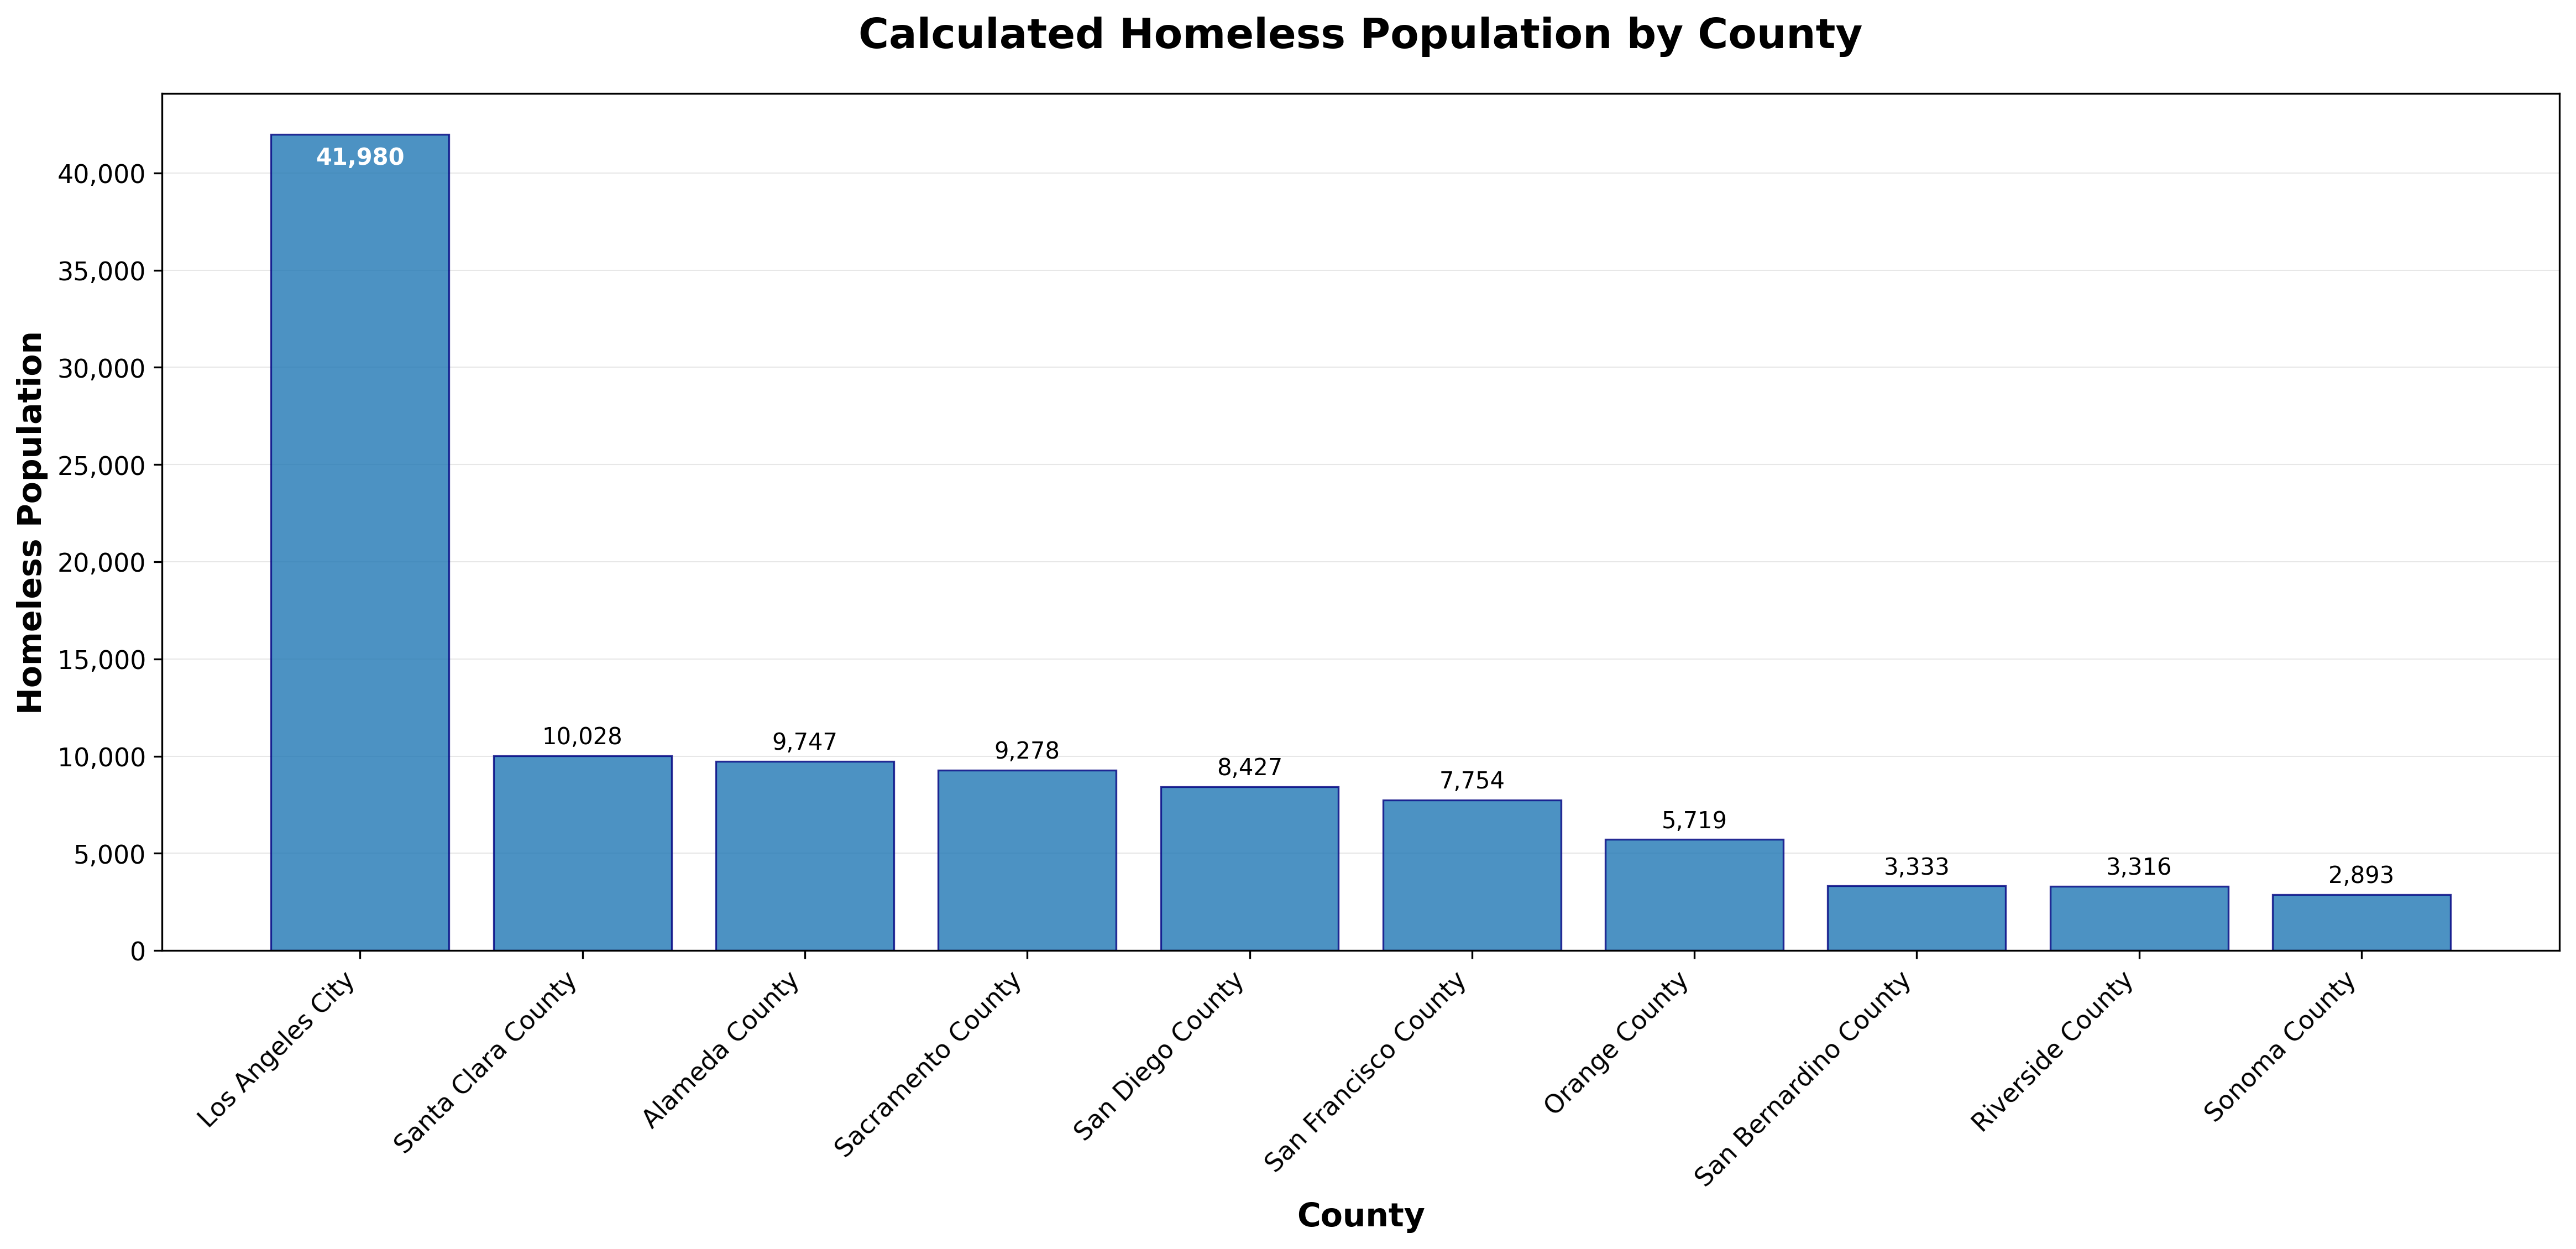

In [ ]:
# ================================================================================
# PLOT: CALCULATED HOMELESS POPULATION BY COUNTY (Sorted Descending) - HIGH RESOLUTION
# Source: california_homeless_counts.csv
# ================================================================================


# === Load combined homeless data file ===
combined_df = pd.read_csv("/content/drive/MyDrive/Kaggle/Datasets/California/Output/california_homeless_counts.csv")

# === Aggregate total homeless population per METRO ===
plot_df = (
    combined_df.groupby("METRO", as_index=False)
    .agg(Calculated_Homeless_Population=("HOMELESS_POPULATION", "sum"))
    .sort_values("Calculated_Homeless_Population", ascending=False)
)

# === HIGH RESOLUTION PLOT SETTINGS ===
plt.rcParams['figure.dpi'] = 300  # Set high DPI globally
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12    # Increase base font size for clarity

# === Plot setup with higher resolution ===
counties = plot_df["METRO"]
values = plot_df["Calculated_Homeless_Population"]
x = np.arange(len(counties))

fig, ax = plt.subplots(figsize=(16, 8))  # Larger figure size for more detail

# Create bars with enhanced styling
bars = ax.bar(x, values, color="#1f77b4", alpha=0.8, edgecolor='navy', linewidth=0.8)

# === Enhanced title and axis labels ===
ax.set_title("Calculated Homeless Population by County", fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel("County", fontsize=14, fontweight='semibold')
ax.set_ylabel("Homeless Population", fontsize=14, fontweight='semibold')

# === Improved tick formatting ===
ax.set_xticks(x)
ax.set_xticklabels(counties, rotation=45, ha="right", fontsize=11)
ax.tick_params(axis='y', labelsize=11)

# === Format y-axis with comma separators ===
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# === Enhanced annotations with better positioning ===
for i, bar in enumerate(bars):
    height = bar.get_height()
    # Use different positioning for very tall bars vs shorter ones
    if height > max(values) * 0.8:  # Top 20% of bars
        va = 'top'
        y_offset = -5
        color = 'white'
        fontweight = 'bold'
    else:
        va = 'bottom'
        y_offset = 3
        color = 'black'
        fontweight = 'normal'

    ax.annotate(f'{int(height):,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, y_offset),
                textcoords="offset points",
                ha='center', va=va,
                fontsize=10, color=color, fontweight=fontweight)

# === Add grid for better readability ===
ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# === Improve layout ===
plt.tight_layout(pad=2.0)

# === Save in multiple high-quality formats to specified directory ===
save_path = '/content/drive/MyDrive/Kaggle/Images/'

plt.savefig(f'{save_path}california_homeless_by_county_high_res.png',
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.savefig(f'{save_path}california_homeless_by_county_vector.svg',
            bbox_inches='tight', facecolor='white', edgecolor='none')
plt.savefig(f'{save_path}california_homeless_by_county_vector.pdf',
            bbox_inches='tight', facecolor='white', edgecolor='none')

plt.show()

# === Optional: Create ultra-high resolution version ===
def create_ultra_high_res_homeless_chart(dpi=600):
    """Create ultra-high resolution version of the homeless population chart"""

    fig, ax = plt.subplots(figsize=(20, 10), dpi=dpi)  # Even larger for ultra-high res

    # Create bars with premium styling
    bars = ax.bar(x, values, color="#1f77b4", alpha=0.85,
                  edgecolor='navy', linewidth=1.2)

    # Premium typography
    ax.set_title("Calculated Homeless Population by County",
                fontsize=24, fontweight='bold', pad=25)
    ax.set_xlabel("County", fontsize=18, fontweight='semibold')
    ax.set_ylabel("Homeless Population", fontsize=18, fontweight='semibold')

    # Enhanced tick formatting
    ax.set_xticks(x)
    ax.set_xticklabels(counties, rotation=45, ha="right", fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

    # Premium annotations
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > max(values) * 0.8:
            va = 'top'
            y_offset = -8
            color = 'white'
            fontweight = 'bold'
            fontsize = 14
        else:
            va = 'bottom'
            y_offset = 5
            color = 'black'
            fontweight = 'semibold'
            fontsize = 12

        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, y_offset),
                    textcoords="offset points",
                    ha='center', va=va,
                    fontsize=fontsize, color=color, fontweight=fontweight)

    # Premium grid
    ax.grid(True, axis='y', alpha=0.4, linestyle='-', linewidth=0.8)
    ax.set_axisbelow(True)

    plt.tight_layout(pad=3.0)

    # Save ultra-high resolution version
    plt.savefig(f'{save_path}california_homeless_by_county_ultra_high_res.png',
                dpi=dpi, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()


# Total Population Counts
To produce consistent and geographically precise denominator values, we used shapefiles to spatially join U.S. Census tracts with locally defined administrative or planning boundaries across all study areas. Shapefiles were sourced from the U.S. Census Bureau’s TIGER/Line data (for tracts and incorporated places) and from city or county open data portals (for city council or supervisorial districts). By assigning tracts to a single district or jurisdiction, we avoided double-counting and ensured accurate population totals. This method allows us to aggregate American Community Survey (ACS) population data to the appropriate local units used in homeless Point-in-Time (PIT) reporting, enabling apples-to-apples rate comparisons across regions with different administrative boundaries.


## ACS B01003
The B01003 table from the American Community Survey (ACS) provides the total population count for each geographic unit, serving as the foundational denominator for all homelessness rate calculations. This single, authoritative value represents the number of residents in each census tract, block group, or place. For homelessness research, B01003 is essential: it enables the conversion of raw PIT counts into standardized rates (e.g., homeless population ÷ total population), allowing meaningful comparisons across regions of different sizes. Without it, researchers cannot discern whether 100 homeless individuals indicate a localized crisis or a smaller-scale issue. B01003 ensures that analyses of homelessness are grounded in valid demographic context, supporting better policy evaluation and resource allocation.

## Alameda County

In [ ]:
# ================================================================================
# BLOCK 1: Alameda County CONFIGURATION
# ================================================================================

METRO = "Alameda County"
COUNTY_FP = "001"
OUTPUT_FILE_PREFIX = "al"
PUBLISHED_POPULATION_KEY = "Alameda County"

# ================================================================================
# BLOCK 2: FILE PATHS
# ================================================================================

base = "/content/drive/MyDrive/Kaggle/Datasets"

# Input files
region_source_file = os.path.join(base, "Counties", METRO, "Output", f"{OUTPUT_FILE_PREFIX}_homeless_data.csv")
tract_path = os.path.join(base, "Shapefiles", "tl_2022_06_tract", "tl_2022_06_tract.shp")
place_path = os.path.join(base, "Shapefiles", "tl_2022_06_place", "tl_2022_06_place.shp")
acs_tract_path = os.path.join(base, "Census", "ACSDT5Y2022.B01003-Data.csv")

# Output file
output_dir = os.path.join(base, "Counties", METRO, "Output")
os.makedirs(output_dir, exist_ok=True)
region_output_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_total_population_data.csv")

# ================================================================================
# BLOCK 3: IMPORT DATA
# ================================================================================

# === LOAD REGION DEFINITIONS ===
regions = pd.read_csv(region_source_file, dtype=str)
regions = regions[regions["METRO"] == METRO].copy()
regions["REGION_CODE"] = regions["REGION_CODE"].str.strip()
regions["REGION_NAME"] = regions["REGION_NAME"].str.strip()
regions["REGION_TYPE"] = regions["REGION_TYPE"].str.strip()
print(f"Loaded regions from HUD PIT:  {len(regions)} regions")

# === LOAD TRACTS ===
tracts = gpd.read_file(tract_path)
tracts = tracts[tracts["COUNTYFP"] == COUNTY_FP].copy()
tracts = tracts.to_crs("EPSG:3857")
tracts["representative_point"] = tracts.geometry.representative_point()
tract_points = tracts.set_geometry("representative_point")
print(f"Loaded {len(tracts)} tracts for {METRO}")

# === LOAD PLACES SHAPEFILE ===
places = gpd.read_file(place_path)
places = places[places["STATEFP"] == "06"].to_crs("EPSG:3857")
places = places[places.intersects(tracts.unary_union)]
print(f"Loaded {len(places)} places in county area")

# === LOAD ACS TRACT POPULATION ===
acs = pd.read_csv(acs_tract_path, dtype=str)
acs = acs[acs["NAME"].str.contains("Census Tract", na=False)].copy()
acs["GEO_ID_11"] = acs["GEO_ID"].str[-11:]
acs["GEO_ID"] = "1400000US" + acs["GEO_ID_11"]
acs["TOTAL_POPULATION"] = pd.to_numeric(acs["B01003_001E"], errors="coerce").fillna(0).astype(int)

# ================================================================================
# BLOCK 4: PROCESS DATA
# ================================================================================

# === MAP REGION METADATA ===
place_to_region = {
    row["REGION_NAME"]: {
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"]
    }
    for _, row in regions.iterrows()
    if row["REGION_TYPE"].lower() != "special geographic area"
}

places["REGION_CODE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_CODE"))
places["REGION_NAME"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_NAME"))
places["REGION_TYPE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_TYPE"))
places = places.dropna(subset=["REGION_CODE"])
print(f"Matched regions to shapelines {len(places)} regions")

# === REPORT MISSING REGIONS ===
matched_codes = set(places["REGION_CODE"])
expected_codes = set(regions["REGION_CODE"])
missing_codes = sorted(expected_codes - matched_codes)
print("--- MISSING REGIONS ---")
if missing_codes:
    for code in missing_codes:
        name = regions.loc[regions["REGION_CODE"] == code, "REGION_NAME"].values[0]
        print(f"  - {code}: {name}")
else:
    print("  None")

# === SPATIAL JOIN ===
j = gpd.sjoin(tract_points, places, predicate="within", how="inner")
j = j[["GEOID_left", "REGION_CODE", "REGION_NAME", "REGION_TYPE"]].rename(columns={"GEOID_left": "GEOID"}).drop_duplicates()
assigned = j.copy()
print(f"Assigned tracts: {len(assigned)}")

# === COUNT TRACTS PER REGION ===
geospatial_tract_counts = assigned.groupby(['REGION_CODE', 'REGION_NAME']).size().reset_index(name='GEOSPATIAL_TRACTS')
print(f"Regions with tract assignments: {len(geospatial_tract_counts)}")

# Display tract counts
print("--- GEOSPATIAL TRACT COUNTS ---")
for _, row in geospatial_tract_counts.iterrows():
    print(f"  {row['REGION_CODE']}: {row['REGION_NAME']} = {row['GEOSPATIAL_TRACTS']} tracts")

# ================================================================================
# BLOCK 5: TRACT ASSIGNMENT LOGIC
# ================================================================================

# === START WITH ALL TRACTS ===
all_tract_assignments = []

# === STEP 1: ASSIGN GEOSPATIAL MATCHES ===
for _, row in assigned.iterrows():
    all_tract_assignments.append({
        "GEOID": row["GEOID"],
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"],
        "ASSIGNMENT_METHOD": "GEOSPATIAL"
    })

geospatial_geoids = set(assigned["GEOID"])
print(f"Step 1 - Geospatial assignments: {len(geospatial_geoids)} tracts")

# === STEP 2: ASSIGN REMAINING TO UNINCORPORATED ===
all_geoids = set(tracts["GEOID"])
unassigned_geoids = all_geoids - geospatial_geoids

uninc_row = regions[regions["REGION_NAME"].str.lower().str.contains("unincorporated")]
if not uninc_row.empty:
    uninc_code = uninc_row.iloc[0]["REGION_CODE"]
    uninc_name = uninc_row.iloc[0]["REGION_NAME"]
    uninc_type = uninc_row.iloc[0]["REGION_TYPE"]
else:
    uninc_code = "UNASSIGNED"
    uninc_name = "Unincorporated Areas"
    uninc_type = "Unincorporated City"

for geoid in unassigned_geoids:
    all_tract_assignments.append({
        "GEOID": geoid,
        "REGION_CODE": uninc_code,
        "REGION_NAME": uninc_name,
        "REGION_TYPE": uninc_type,
        "ASSIGNMENT_METHOD": "UNINCORPORATED"
    })

print(f"Step 2 - Unincorporated assignments: {len(unassigned_geoids)} tracts")

# === CREATE FINAL ASSIGNMENTS DATAFRAME ===
final_assignments = pd.DataFrame(all_tract_assignments)
print(f"Total tract assignments: {len(final_assignments)}")

# ================================================================================
# BLOCK 6: JOIN POPULATION DATA
# ================================================================================

# === JOIN FINAL ASSIGNMENTS WITH ACS POPULATION ===
tracts_with_pop = final_assignments.rename(columns={"GEOID": "GEO_ID_11"}).merge(
    acs[["GEO_ID", "GEO_ID_11", "TOTAL_POPULATION"]], on="GEO_ID_11", how="left")
tracts_with_pop["TOTAL_POPULATION"] = tracts_with_pop["TOTAL_POPULATION"].fillna(0).astype(int)
tracts_with_pop["METRO"] = METRO

# === AGGREGATE TO REGION LEVEL ===
region_summary = tracts_with_pop.groupby(
    ["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE"], as_index=False)["TOTAL_POPULATION"].sum()
region_summary = region_summary.sort_values("REGION_CODE")

print(f"Region summary created with {len(region_summary)} regions")

# ================================================================================
# BLOCK 6.5: CREATE TRACT LOOKUP TABLE
# ================================================================================

# Create tract lookup with required columns
tract_lookup = tracts_with_pop[["GEO_ID", "METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]].copy()
tract_lookup = tract_lookup.sort_values("GEO_ID").reset_index(drop=True)

# Save tract lookup file
tract_lookup_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_tract_lookup.csv")
tract_lookup.to_csv(tract_lookup_file, index=False)

# ================================================================================
# BLOCK 7: PRINT RESULTS
# ================================================================================

# Create variables for summary
final_tract_counts = tracts_with_pop.groupby(['REGION_CODE']).size().reset_index(name='TRACT_COUNT')

print("=" * 80)
print(f"{METRO.upper()} POPULATION ASSIGNMENT")
print("=" * 80)

# === SUMMARY ===
print("DATA LOADED:")
print(f"  Regions from HUD PIT: {len(regions)} | Tracts: {len(tracts)} | Places: {len(places)}")

print("\nREGION MATCHING:")
print(f"  Shapefile matches: {len(places)}")

print("\nTRACT ASSIGNMENTS:")
print(f"  Geospatial: {len(geospatial_geoids)} | Unincorporated: {len(unassigned_geoids)} | Total: {len(final_assignments)}")

# === FINAL RESULTS ===
print("\nFINAL POPULATION RESULTS:")
print("=" * 80)
print(f"{'REGION_CODE':<12} {'REGION_NAME':<25} {'TRACTS':>7} {'POPULATION':>12}")
print("-" * 80)

# Merge region_summary with tract counts for display
results_display = region_summary.merge(final_tract_counts, on='REGION_CODE', how='left')
results_display['TRACT_COUNT'] = results_display['TRACT_COUNT'].fillna(0).astype(int)

for _, row in results_display.iterrows():
    print(f"{row['REGION_CODE']:<12} {row['REGION_NAME']:<25} {row['TRACT_COUNT']:>7} {row['TOTAL_POPULATION']:>12,}")

print("-" * 80)
total_pop = region_summary['TOTAL_POPULATION'].sum()
total_tracts = final_tract_counts['TRACT_COUNT'].sum()
print(f"{'TOTAL':<12} {'All Regions':<25} {total_tracts:>7} {total_pop:>12,}")

# Handle published population safely
try:
    from config import PUBLISHED_POPULATIONS
    published_total = PUBLISHED_POPULATIONS.get(PUBLISHED_POPULATION_KEY)
    if published_total:
        print(f"{'PUBLISHED':<12} {'':<25} {'':>7} {published_total:>12,}")
except ImportError:
    print("Note: Published population data not available (config.py not found)")

# ================================================================================
# BLOCK 8: SAVE RESULTS
# ================================================================================

region_summary.to_csv(region_output_file, index=False)
print(f"\nSaved: {region_output_file}")
print(f"Saved: {tract_lookup_file}")
print(f"{METRO} population processing complete.")

Loaded regions from HUD PIT:  15 regions
Loaded 379 tracts for Alameda County


/tmp/ipython-input-15-3243955154.py:50: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  places = places[places.intersects(tracts.unary_union)]


Loaded 37 places in county area
Matched regions to shapelines 14 regions
--- MISSING REGIONS ---
  - AL_15: Unincorporated
Assigned tracts: 335
Regions with tract assignments: 14
--- GEOSPATIAL TRACT COUNTS ---
  AL_01: Alameda = 16 tracts
  AL_02: Albany = 8 tracts
  AL_03: Berkeley = 34 tracts
  AL_04: Dublin = 8 tracts
  AL_05: Emeryville = 4 tracts
  AL_06: Fremont = 48 tracts
  AL_07: Hayward = 31 tracts
  AL_08: Livermore = 14 tracts
  AL_09: Newark = 8 tracts
  AL_10: Oakland = 116 tracts
  AL_11: Piedmont = 2 tracts
  AL_12: Pleasanton = 11 tracts
  AL_13: San Leandro = 18 tracts
  AL_14: Union City = 17 tracts
Step 1 - Geospatial assignments: 335 tracts
Step 2 - Unincorporated assignments: 44 tracts
Total tract assignments: 379
Region summary created with 15 regions
ALAMEDA COUNTY POPULATION ASSIGNMENT
DATA LOADED:
  Regions from HUD PIT: 15 | Tracts: 379 | Places: 14

REGION MATCHING:
  Shapefile matches: 14

TRACT ASSIGNMENTS:
  Geospatial: 335 | Unincorporated: 44 | Total: 

## Los Angeles City

In [ ]:
# ================================================================================
# BLOCK 1: Los Angeles City CONFIGURATION
# ================================================================================


# === METRO DEFINITION ===
METRO = "Los Angeles City"

print("=" * 80)
print(f"STARTING {METRO.upper()} TOTAL POPULATION JOIN")
print("=" * 80)

# === File paths ===
base_folder = "/content/drive/MyDrive/Kaggle/Datasets"
region_source_file = os.path.join(base_folder, "California", "Output", "california_homeless_counts.csv")
tract_path = os.path.join(base_folder, "Shapefiles", "tl_2022_06_tract", "tl_2022_06_tract.shp")
districts_path = os.path.join(base_folder, "Counties", METRO, "Shapefiles", "LA_City_Council_Districts_2021.geojson")
acs_path = os.path.join(base_folder, "Census", "ACSDT5Y2022.B01003-Data.csv")
cdp_path = os.path.join(base_folder, "Census", "ACSDT5Y2022.B01003-Data CDP.csv")
output_dir = os.path.join(base_folder, "Counties", METRO, "Output")
os.makedirs(output_dir, exist_ok=True)
region_output_file = os.path.join(output_dir, "la_total_population.csv")
tract_lookup_file = os.path.join(output_dir, "la_tract_lookup.csv")

# === Load ACS tract population ===
acs = pd.read_csv(acs_path, dtype=str)
acs = acs[acs["NAME"].str.contains("Census Tract", na=False)].copy()
acs["GEO_ID_11"] = acs["GEO_ID"].str[-11:]
acs["GEO_ID"] = "1400000US" + acs["GEO_ID_11"]
acs["TOTAL_POPULATION"] = pd.to_numeric(acs["B01003_001E"], errors="coerce").fillna(0).astype(int)

# === Load LA County tracts and project ===
tracts = gpd.read_file(tract_path)
tracts = tracts[tracts["COUNTYFP"] == "037"].copy()
tracts = tracts.to_crs("EPSG:3857")
tracts["representative_point"] = tracts.geometry.representative_point()
tract_points = tracts.set_geometry("representative_point")
print(f"County Tracts Loaded (Los Angeles):     {len(tracts):>5}")

# === Load region definitions from master source ===
homeless_regions = pd.read_csv(region_source_file, dtype=str)
homeless_regions = homeless_regions[homeless_regions["METRO"] == METRO].copy()
homeless_regions["REGION_CODE"] = homeless_regions["REGION_CODE"].str.strip()
homeless_regions["REGION_NAME"] = homeless_regions["REGION_NAME"].str.strip()
homeless_regions["REGION_TYPE"] = homeless_regions["REGION_TYPE"].str.strip()
total_defined = len(homeless_regions)

# === Load official council district shapefile ===
districts = gpd.read_file(districts_path)
districts = districts.to_crs("EPSG:3857")
districts["DIST_ID"] = districts["DISTRICT"].astype(str)

# === Map region metadata ===
district_to_region = {}
for _, row in homeless_regions.iterrows():
    name = row["REGION_NAME"]
    code = row["REGION_CODE"]
    rtype = row["REGION_TYPE"]
    if "district" in name.lower():
        dist_num = name.lower().replace("district", "").strip()
        district_to_region[dist_num] = {"REGION_CODE": code, "REGION_NAME": name, "REGION_TYPE": rtype}

districts["REGION_CODE"] = districts["DIST_ID"].map(lambda x: district_to_region.get(str(x), {}).get("REGION_CODE"))
districts["REGION_NAME"] = districts["DIST_ID"].map(lambda x: district_to_region.get(str(x), {}).get("REGION_NAME"))
districts["REGION_TYPE"] = districts["DIST_ID"].map(lambda x: district_to_region.get(str(x), {}).get("REGION_TYPE"))
districts_with_regions = districts.dropna(subset=["REGION_CODE"])
total_matched = len(districts_with_regions)

print(f"Loaded regions from HUD PIT:               {total_defined:>3}")

print(f"Matched regions to shapefiles:        {total_matched:>3}")

# === Assign tracts to regions ===
assigned_tracts = gpd.sjoin(
    tract_points,
    districts_with_regions[["REGION_CODE", "REGION_NAME", "REGION_TYPE", "geometry"]],
    predicate="within",
    how="inner"
)[["GEOID", "REGION_CODE", "REGION_NAME", "REGION_TYPE"]].drop_duplicates()
print("\n--- TRACT ASSIGNMENT ---")
print(f"Assigned Tracts:                   {len(assigned_tracts):>5}")

# === Merge population to tracts ===
tract_pop = assigned_tracts.rename(columns={"GEOID": "GEO_ID_11"}).merge(
    acs[["GEO_ID", "GEO_ID_11", "TOTAL_POPULATION"]],
    on="GEO_ID_11",
    how="left"
)
tract_pop["TOTAL_POPULATION"] = tract_pop["TOTAL_POPULATION"].fillna(0).astype(int)

# === Aggregate by region ===
region_summary = (
    tract_pop.groupby(["REGION_CODE", "REGION_NAME", "REGION_TYPE"])
    .agg(TOTAL_POPULATION=("TOTAL_POPULATION", "sum"))
    .reset_index()
)
region_summary["METRO"] = METRO
region_summary = region_summary[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "TOTAL_POPULATION"]]

print("=" * 80)
print(f"{METRO.upper()} TOTAL POPULATION")
print("=" * 80)
print(f"{'METRO':<20} {'REGION_CODE':<12} {'REGION_NAME':<25} {'POPULATION':>12}")
print("-" * 80)
for _, row in region_summary.iterrows():
    print(f"{row['METRO']:<20} {row['REGION_CODE']:<12} {row['REGION_NAME']:<25} {row['TOTAL_POPULATION']:>12,}")
print("-" * 80)
total_pop = region_summary['TOTAL_POPULATION'].sum()
print(f"{'TOTAL':<20} {'':<12} {'All Districts':<25} {total_pop:>12,}")

published_total = PUBLISHED_POPULATIONS.get(METRO)
if published_total:
    print(f"{'PUBLISHED TOTAL':<20} {'':<12} {'':<25} {published_total:>12,}")

# === Save outputs ===
region_summary.to_csv(region_output_file, index=False)
print(f"Saved: {region_output_file}")

tract_pop["METRO"] = METRO
tract_lookup = tract_pop[["GEO_ID", "METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]]
tract_lookup = tract_lookup.sort_values(["REGION_CODE", "GEO_ID"])
tract_lookup.to_csv(tract_lookup_file, index=False)
print(f"Saved: {tract_lookup_file}")

# === Fallback CDP join ===
print("=" * 80)
print("FALLBACK JOIN: MISSING INCORPORATED CITIES TO CDP POPULATION")
print("=" * 80)
print("No missing incorporated city populations for this METRO.")
print("=" * 80)
print("Fallback population join complete.")


STARTING LOS ANGELES CITY TOTAL POPULATION JOIN
County Tracts Loaded (Los Angeles):      2498
Loaded regions from HUD PIT:                15
Matched regions to shapefiles:         15

--- TRACT ASSIGNMENT ---
Assigned Tracts:                    1107
LOS ANGELES CITY TOTAL POPULATION
METRO                REGION_CODE  REGION_NAME                 POPULATION
--------------------------------------------------------------------------------
Los Angeles City     LA_01        District 1                     251,550
Los Angeles City     LA_02        District 2                     245,195
Los Angeles City     LA_03        District 3                     260,965
Los Angeles City     LA_04        District 4                     253,325
Los Angeles City     LA_05        District 5                     245,495
Los Angeles City     LA_06        District 6                     262,413
Los Angeles City     LA_07        District 7                     253,342
Los Angeles City     LA_08        District 8       

## Orange County

In [ ]:

# ================================================================================
# BLOCK 1: Orange County CONFIGURATION
# ================================================================================

METRO = "Orange County"
COUNTY_FP = "059"
OUTPUT_FILE_PREFIX = "oc"
PUBLISHED_POPULATION_KEY = "Orange County"

# ================================================================================
# BLOCK 2: FILE PATHS
# ================================================================================

base = "/content/drive/MyDrive/Kaggle/Datasets"

# Input files
region_source_file = os.path.join(base, "Counties", METRO, "Output", f"{OUTPUT_FILE_PREFIX}_homeless_data.csv")
tract_path = os.path.join(base, "Shapefiles", "tl_2022_06_tract", "tl_2022_06_tract.shp")
place_path = os.path.join(base, "Shapefiles", "tl_2022_06_place", "tl_2022_06_place.shp")
acs_tract_path = os.path.join(base, "Census", "ACSDT5Y2022.B01003-Data.csv")

# Output file
output_dir = os.path.join(base, "Counties", METRO, "Output")
os.makedirs(output_dir, exist_ok=True)
region_output_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_total_population_data.csv")

# ================================================================================
# BLOCK 3: IMPORT DATA
# ================================================================================

# === LOAD REGION DEFINITIONS ===
regions = pd.read_csv(region_source_file, dtype=str)
regions = regions[regions["METRO"] == METRO].copy()
regions["REGION_CODE"] = regions["REGION_CODE"].str.strip()
regions["REGION_NAME"] = regions["REGION_NAME"].str.strip()
regions["REGION_TYPE"] = regions["REGION_TYPE"].str.strip()
print(f"Loaded regions from HUD PIT:  {len(regions)} regions")

# === LOAD TRACTS ===
tracts = gpd.read_file(tract_path)
tracts = tracts[tracts["COUNTYFP"] == COUNTY_FP].copy()
tracts = tracts.to_crs("EPSG:3857")
tracts["representative_point"] = tracts.geometry.representative_point()
tract_points = tracts.set_geometry("representative_point")
print(f"Loaded {len(tracts)} tracts for {METRO}")

# === LOAD PLACES SHAPEFILE ===
places = gpd.read_file(place_path)
places = places[places["STATEFP"] == "06"].to_crs("EPSG:3857")
places = places[places.intersects(tracts.unary_union)]
print(f"Loaded {len(places)} places in county area")

# === LOAD ACS TRACT POPULATION ===
acs = pd.read_csv(acs_tract_path, dtype=str)
acs = acs[acs["NAME"].str.contains("Census Tract", na=False)].copy()
acs["GEO_ID_11"] = acs["GEO_ID"].str[-11:]
acs["GEO_ID"] = "1400000US" + acs["GEO_ID_11"]
acs["TOTAL_POPULATION"] = pd.to_numeric(acs["B01003_001E"], errors="coerce").fillna(0).astype(int)

# ================================================================================
# BLOCK 4: PROCESS DATA
# ================================================================================

# === MAP REGION METADATA ===
place_to_region = {
    row["REGION_NAME"]: {
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"]
    }
    for _, row in regions.iterrows()
    if row["REGION_TYPE"].lower() != "special geographic area"
}

places["REGION_CODE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_CODE"))
places["REGION_NAME"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_NAME"))
places["REGION_TYPE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_TYPE"))
places = places.dropna(subset=["REGION_CODE"])
print(f"Matched regions to shapelines {len(places)} regions")

# === REPORT MISSING REGIONS ===
matched_codes = set(places["REGION_CODE"])
expected_codes = set(regions["REGION_CODE"])
missing_codes = sorted(expected_codes - matched_codes)
print("--- MISSING REGIONS ---")
if missing_codes:
    for code in missing_codes:
        name = regions.loc[regions["REGION_CODE"] == code, "REGION_NAME"].values[0]
        print(f"  - {code}: {name}")
else:
    print("  None")

# === SPATIAL JOIN ===
j = gpd.sjoin(tract_points, places, predicate="within", how="inner")
j = j[["GEOID_left", "REGION_CODE", "REGION_NAME", "REGION_TYPE"]].rename(columns={"GEOID_left": "GEOID"}).drop_duplicates()
assigned = j.copy()
print(f"Assigned tracts: {len(assigned)}")

# === COUNT TRACTS PER REGION ===
geospatial_tract_counts = assigned.groupby(['REGION_CODE', 'REGION_NAME']).size().reset_index(name='GEOSPATIAL_TRACTS')
print(f"Regions with tract assignments: {len(geospatial_tract_counts)}")

# Display tract counts
print("--- GEOSPATIAL TRACT COUNTS ---")
for _, row in geospatial_tract_counts.iterrows():
    print(f"  {row['REGION_CODE']}: {row['REGION_NAME']} = {row['GEOSPATIAL_TRACTS']} tracts")

# ================================================================================
# BLOCK 5: TRACT ASSIGNMENT LOGIC
# ================================================================================

# === START WITH ALL TRACTS ===
all_tract_assignments = []

# === STEP 1: ASSIGN GEOSPATIAL MATCHES ===
for _, row in assigned.iterrows():
    all_tract_assignments.append({
        "GEOID": row["GEOID"],
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"],
        "ASSIGNMENT_METHOD": "GEOSPATIAL"
    })

geospatial_geoids = set(assigned["GEOID"])
print(f"Step 1 - Geospatial assignments: {len(geospatial_geoids)} tracts")

# === STEP 2: ASSIGN REMAINING TO UNINCORPORATED ===
all_geoids = set(tracts["GEOID"])
unassigned_geoids = all_geoids - geospatial_geoids

uninc_row = regions[regions["REGION_NAME"].str.lower().str.contains("unincorporated")]
if not uninc_row.empty:
    uninc_code = uninc_row.iloc[0]["REGION_CODE"]
    uninc_name = uninc_row.iloc[0]["REGION_NAME"]
    uninc_type = uninc_row.iloc[0]["REGION_TYPE"]
else:
    uninc_code = "UNASSIGNED"
    uninc_name = "Unincorporated Areas"
    uninc_type = "Unincorporated City"

for geoid in unassigned_geoids:
    all_tract_assignments.append({
        "GEOID": geoid,
        "REGION_CODE": uninc_code,
        "REGION_NAME": uninc_name,
        "REGION_TYPE": uninc_type,
        "ASSIGNMENT_METHOD": "UNINCORPORATED"
    })

print(f"Step 2 - Unincorporated assignments: {len(unassigned_geoids)} tracts")

# === CREATE FINAL ASSIGNMENTS DATAFRAME ===
final_assignments = pd.DataFrame(all_tract_assignments)
print(f"Total tract assignments: {len(final_assignments)}")

# ================================================================================
# BLOCK 6: JOIN POPULATION DATA
# ================================================================================

# === JOIN FINAL ASSIGNMENTS WITH ACS POPULATION ===
tracts_with_pop = final_assignments.rename(columns={"GEOID": "GEO_ID_11"}).merge(
    acs[["GEO_ID", "GEO_ID_11", "TOTAL_POPULATION"]], on="GEO_ID_11", how="left")
tracts_with_pop["TOTAL_POPULATION"] = tracts_with_pop["TOTAL_POPULATION"].fillna(0).astype(int)
tracts_with_pop["METRO"] = METRO

# === AGGREGATE TO REGION LEVEL ===
region_summary = tracts_with_pop.groupby(
    ["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE"], as_index=False)["TOTAL_POPULATION"].sum()
region_summary = region_summary.sort_values("REGION_CODE")

print(f"Region summary created with {len(region_summary)} regions")

# ================================================================================
# BLOCK 6.5: CREATE TRACT LOOKUP TABLE
# ================================================================================

# Create tract lookup with required columns
tract_lookup = tracts_with_pop[["GEO_ID", "METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]].copy()
tract_lookup = tract_lookup.sort_values("GEO_ID").reset_index(drop=True)

# Save tract lookup file
tract_lookup_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_tract_lookup.csv")
tract_lookup.to_csv(tract_lookup_file, index=False)

# ================================================================================
# BLOCK 7: PRINT RESULTS
# ================================================================================

# Create variables for summary
final_tract_counts = tracts_with_pop.groupby(['REGION_CODE']).size().reset_index(name='TRACT_COUNT')

print("=" * 80)
print(f"{METRO.upper()} POPULATION ASSIGNMENT")
print("=" * 80)

# === SUMMARY ===
print("DATA LOADED:")
print(f"  Regions from HUD PIT: {len(regions)} | Tracts: {len(tracts)} | Places: {len(places)}")

print("\nREGION MATCHING:")
print(f"  Shapefile matches: {len(places)}")

print("\nTRACT ASSIGNMENTS:")
print(f"  Geospatial: {len(geospatial_geoids)} | Unincorporated: {len(unassigned_geoids)} | Total: {len(final_assignments)}")

# === FINAL RESULTS ===
print("\nFINAL POPULATION RESULTS:")
print("=" * 80)
print(f"{'REGION_CODE':<12} {'REGION_NAME':<25} {'TRACTS':>7} {'POPULATION':>12}")
print("-" * 80)

# Merge region_summary with tract counts for display
results_display = region_summary.merge(final_tract_counts, on='REGION_CODE', how='left')
results_display['TRACT_COUNT'] = results_display['TRACT_COUNT'].fillna(0).astype(int)

for _, row in results_display.iterrows():
    print(f"{row['REGION_CODE']:<12} {row['REGION_NAME']:<25} {row['TRACT_COUNT']:>7} {row['TOTAL_POPULATION']:>12,}")

print("-" * 80)
total_pop = region_summary['TOTAL_POPULATION'].sum()
total_tracts = final_tract_counts['TRACT_COUNT'].sum()
print(f"{'TOTAL':<12} {'All Regions':<25} {total_tracts:>7} {total_pop:>12,}")

# Handle published population safely
try:
    from config import PUBLISHED_POPULATIONS
    published_total = PUBLISHED_POPULATIONS.get(PUBLISHED_POPULATION_KEY)
    if published_total:
        print(f"{'PUBLISHED':<12} {'':<25} {'':>7} {published_total:>12,}")
except ImportError:
    print("Note: Published population data not available (config.py not found)")

# ================================================================================
# BLOCK 8: SAVE RESULTS
# ================================================================================

region_summary.to_csv(region_output_file, index=False)
print(f"\nSaved: {region_output_file}")
print(f"Saved: {tract_lookup_file}")
print(f"{METRO} population processing complete.")

Loaded regions from HUD PIT:  36 regions
Loaded 614 tracts for Orange County


/tmp/ipython-input-17-1669188238.py:50: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  places = places[places.intersects(tracts.unary_union)]


Loaded 57 places in county area
Matched regions to shapelines 34 regions
--- MISSING REGIONS ---
  - OC_35: County Unincorporated
  - OC_36: Domestic Violence Programs
Assigned tracts: 568
Regions with tract assignments: 34
--- GEOSPATIAL TRACT COUNTS ---
  OC_01: Anaheim = 58 tracts
  OC_02: Brea = 7 tracts
  OC_03: Buena Park = 13 tracts
  OC_04: Cypress = 10 tracts
  OC_05: Fullerton = 31 tracts
  OC_06: La Habra = 12 tracts
  OC_07: La Palma = 3 tracts
  OC_08: Los Alamitos = 3 tracts
  OC_09: Orange = 23 tracts
  OC_10: Placentia = 12 tracts
  OC_11: Stanton = 7 tracts
  OC_12: Villa Park = 2 tracts
  OC_13: Yorba Linda = 14 tracts
  OC_14: Costa Mesa = 25 tracts
  OC_15: Fountain Valley = 12 tracts
  OC_16: Garden Grove = 33 tracts
  OC_17: Huntington Beach = 42 tracts
  OC_18: Newport Beach = 20 tracts
  OC_19: Santa Ana = 53 tracts
  OC_20: Seal Beach = 6 tracts
  OC_21: Tustin = 15 tracts
  OC_22: Westminster = 15 tracts
  OC_23: Aliso Viejo = 10 tracts
  OC_24: Dana Point = 5

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

ORANGE COUNTY POPULATION ASSIGNMENT
DATA LOADED:
  Regions from HUD PIT: 36 | Tracts: 614 | Places: 34

REGION MATCHING:
  Shapefile matches: 34

TRACT ASSIGNMENTS:
  Geospatial: 568 | Unincorporated: 46 | Total: 614

FINAL POPULATION RESULTS:
REGION_CODE  REGION_NAME                TRACTS   POPULATION
--------------------------------------------------------------------------------
OC_01        Anaheim                        58      324,509
OC_02        Brea                            7       38,551
OC_03        Buena Park                     13       81,359
OC_04        Cypress                        10       45,685
OC_05        Fullerton                      31      155,605
OC_06        La Habra                       12       55,494
OC_07        La Palma                        3       14,291
OC_08        Los Alamitos                    3       11,631
OC_09        Orange                         23      124,638
OC_10        Placentia                      12       56,694
OC_11        St

## Riverside County

In [ ]:
# ================================================================================
# BLOCK 1: Riverside County CONFIGURATION
# ================================================================================

METRO = "Riverside County"
COUNTY_FP = "065"
OUTPUT_FILE_PREFIX = "rv"
PUBLISHED_POPULATION_KEY = "Riverside County"

# ================================================================================
# BLOCK 2: FILE PATHS
# ================================================================================

base = "/content/drive/MyDrive/Kaggle/Datasets"

# Input files
region_source_file = os.path.join(base, "Counties", METRO, "Output", f"{OUTPUT_FILE_PREFIX}_homeless_data.csv")
tract_path = os.path.join(base, "Shapefiles", "tl_2022_06_tract", "tl_2022_06_tract.shp")
place_path = os.path.join(base, "Shapefiles", "tl_2022_06_place", "tl_2022_06_place.shp")
acs_tract_path = os.path.join(base, "Census", "ACSDT5Y2022.B01003-Data.csv")

# Output file
output_dir = os.path.join(base, "Counties", METRO, "Output")
os.makedirs(output_dir, exist_ok=True)
region_output_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_total_population_data.csv")

# ================================================================================
# BLOCK 3: IMPORT DATA
# ================================================================================

# === LOAD REGION DEFINITIONS ===
regions = pd.read_csv(region_source_file, dtype=str)
regions = regions[regions["METRO"] == METRO].copy()
regions["REGION_CODE"] = regions["REGION_CODE"].str.strip()
regions["REGION_NAME"] = regions["REGION_NAME"].str.strip()
regions["REGION_TYPE"] = regions["REGION_TYPE"].str.strip()
print(f"Loaded regions from HUD PIT:  {len(regions)} regions")

# === LOAD TRACTS ===
tracts = gpd.read_file(tract_path)
tracts = tracts[tracts["COUNTYFP"] == COUNTY_FP].copy()
tracts = tracts.to_crs("EPSG:3857")
tracts["representative_point"] = tracts.geometry.representative_point()
tract_points = tracts.set_geometry("representative_point")
print(f"Loaded {len(tracts)} tracts for {METRO}")

# === LOAD PLACES SHAPEFILE ===
places = gpd.read_file(place_path)
places = places[places["STATEFP"] == "06"].to_crs("EPSG:3857")
places = places[places.intersects(tracts.unary_union)]
print(f"Loaded {len(places)} places in county area")

# === LOAD ACS TRACT POPULATION ===
acs = pd.read_csv(acs_tract_path, dtype=str)
acs = acs[acs["NAME"].str.contains("Census Tract", na=False)].copy()
acs["GEO_ID_11"] = acs["GEO_ID"].str[-11:]
acs["GEO_ID"] = "1400000US" + acs["GEO_ID_11"]
acs["TOTAL_POPULATION"] = pd.to_numeric(acs["B01003_001E"], errors="coerce").fillna(0).astype(int)

# ================================================================================
# BLOCK 4: PROCESS DATA
# ================================================================================

# === MAP REGION METADATA ===
place_to_region = {
    row["REGION_NAME"]: {
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"]
    }
    for _, row in regions.iterrows()
    if row["REGION_TYPE"].lower() != "special geographic area"
}

places["REGION_CODE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_CODE"))
places["REGION_NAME"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_NAME"))
places["REGION_TYPE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_TYPE"))
places = places.dropna(subset=["REGION_CODE"])
print(f"Matched regions to shapelines {len(places)} regions")

# === REPORT MISSING REGIONS ===
matched_codes = set(places["REGION_CODE"])
expected_codes = set(regions["REGION_CODE"])
missing_codes = sorted(expected_codes - matched_codes)
print("--- MISSING REGIONS ---")
if missing_codes:
    for code in missing_codes:
        name = regions.loc[regions["REGION_CODE"] == code, "REGION_NAME"].values[0]
        print(f"  - {code}: {name}")
else:
    print("  None")

# === SPATIAL JOIN ===
j = gpd.sjoin(tract_points, places, predicate="within", how="inner")
j = j[["GEOID_left", "REGION_CODE", "REGION_NAME", "REGION_TYPE"]].rename(columns={"GEOID_left": "GEOID"}).drop_duplicates()
assigned = j.copy()
print(f"Assigned tracts: {len(assigned)}")

# === COUNT TRACTS PER REGION ===
geospatial_tract_counts = assigned.groupby(['REGION_CODE', 'REGION_NAME']).size().reset_index(name='GEOSPATIAL_TRACTS')
print(f"Regions with tract assignments: {len(geospatial_tract_counts)}")

# Display tract counts
print("--- GEOSPATIAL TRACT COUNTS ---")
for _, row in geospatial_tract_counts.iterrows():
    print(f"  {row['REGION_CODE']}: {row['REGION_NAME']} = {row['GEOSPATIAL_TRACTS']} tracts")

# ================================================================================
# BLOCK 5: TRACT ASSIGNMENT LOGIC
# ================================================================================

# === START WITH ALL TRACTS ===
all_tract_assignments = []

# === STEP 1: ASSIGN GEOSPATIAL MATCHES ===
for _, row in assigned.iterrows():
    all_tract_assignments.append({
        "GEOID": row["GEOID"],
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"],
        "ASSIGNMENT_METHOD": "GEOSPATIAL"
    })

geospatial_geoids = set(assigned["GEOID"])
print(f"Step 1 - Geospatial assignments: {len(geospatial_geoids)} tracts")

# === STEP 2: ASSIGN REMAINING TO UNINCORPORATED ===
all_geoids = set(tracts["GEOID"])
unassigned_geoids = all_geoids - geospatial_geoids

uninc_row = regions[regions["REGION_NAME"].str.lower().str.contains("unincorporated")]
if not uninc_row.empty:
    uninc_code = uninc_row.iloc[0]["REGION_CODE"]
    uninc_name = uninc_row.iloc[0]["REGION_NAME"]
    uninc_type = uninc_row.iloc[0]["REGION_TYPE"]
else:
    uninc_code = "UNASSIGNED"
    uninc_name = "Unincorporated Areas"
    uninc_type = "Unincorporated City"

for geoid in unassigned_geoids:
    all_tract_assignments.append({
        "GEOID": geoid,
        "REGION_CODE": uninc_code,
        "REGION_NAME": uninc_name,
        "REGION_TYPE": uninc_type,
        "ASSIGNMENT_METHOD": "UNINCORPORATED"
    })

print(f"Step 2 - Unincorporated assignments: {len(unassigned_geoids)} tracts")

# === CREATE FINAL ASSIGNMENTS DATAFRAME ===
final_assignments = pd.DataFrame(all_tract_assignments)
print(f"Total tract assignments: {len(final_assignments)}")

# ================================================================================
# BLOCK 6: JOIN POPULATION DATA
# ================================================================================

# === JOIN FINAL ASSIGNMENTS WITH ACS POPULATION ===
tracts_with_pop = final_assignments.rename(columns={"GEOID": "GEO_ID_11"}).merge(
    acs[["GEO_ID", "GEO_ID_11", "TOTAL_POPULATION"]], on="GEO_ID_11", how="left")
tracts_with_pop["TOTAL_POPULATION"] = tracts_with_pop["TOTAL_POPULATION"].fillna(0).astype(int)
tracts_with_pop["METRO"] = METRO

# === AGGREGATE TO REGION LEVEL ===
region_summary = tracts_with_pop.groupby(
    ["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE"], as_index=False)["TOTAL_POPULATION"].sum()
region_summary = region_summary.sort_values("REGION_CODE")

print(f"Region summary created with {len(region_summary)} regions")

# ================================================================================
# BLOCK 6.5: CREATE TRACT LOOKUP TABLE
# ================================================================================

# Create tract lookup with required columns
tract_lookup = tracts_with_pop[["GEO_ID", "METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]].copy()
tract_lookup = tract_lookup.sort_values("GEO_ID").reset_index(drop=True)

# Save tract lookup file
tract_lookup_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_tract_lookup.csv")
tract_lookup.to_csv(tract_lookup_file, index=False)

# ================================================================================
# BLOCK 7: PRINT RESULTS
# ================================================================================

# Create variables for summary
final_tract_counts = tracts_with_pop.groupby(['REGION_CODE']).size().reset_index(name='TRACT_COUNT')

print("=" * 80)
print(f"{METRO.upper()} POPULATION ASSIGNMENT")
print("=" * 80)

# === SUMMARY ===
print("DATA LOADED:")
print(f"  Regions from HUD PIT: {len(regions)} | Tracts: {len(tracts)} | Places: {len(places)}")

print("\nREGION MATCHING:")
print(f"  Shapefile matches: {len(places)}")

print("\nTRACT ASSIGNMENTS:")
print(f"  Geospatial: {len(geospatial_geoids)} | Unincorporated: {len(unassigned_geoids)} | Total: {len(final_assignments)}")

# === FINAL RESULTS ===
print("\nFINAL POPULATION RESULTS:")
print("=" * 80)
print(f"{'REGION_CODE':<12} {'REGION_NAME':<25} {'TRACTS':>7} {'POPULATION':>12}")
print("-" * 80)

# Merge region_summary with tract counts for display
results_display = region_summary.merge(final_tract_counts, on='REGION_CODE', how='left')
results_display['TRACT_COUNT'] = results_display['TRACT_COUNT'].fillna(0).astype(int)

for _, row in results_display.iterrows():
    print(f"{row['REGION_CODE']:<12} {row['REGION_NAME']:<25} {row['TRACT_COUNT']:>7} {row['TOTAL_POPULATION']:>12,}")

print("-" * 80)
total_pop = region_summary['TOTAL_POPULATION'].sum()
total_tracts = final_tract_counts['TRACT_COUNT'].sum()
print(f"{'TOTAL':<12} {'All Regions':<25} {total_tracts:>7} {total_pop:>12,}")

# Handle published population safely
try:
    from config import PUBLISHED_POPULATIONS
    published_total = PUBLISHED_POPULATIONS.get(PUBLISHED_POPULATION_KEY)
    if published_total:
        print(f"{'PUBLISHED':<12} {'':<25} {'':>7} {published_total:>12,}")
except ImportError:
    print("Note: Published population data not available (config.py not found)")

# ================================================================================
# BLOCK 8: SAVE RESULTS
# ================================================================================

region_summary.to_csv(region_output_file, index=False)
print(f"\nSaved: {region_output_file}")
print(f"Saved: {tract_lookup_file}")
print(f"{METRO} population processing complete.")

Loaded regions from HUD PIT:  29 regions
Loaded 518 tracts for Riverside County


/tmp/ipython-input-18-4264936589.py:50: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  places = places[places.intersects(tracts.unary_union)]


Loaded 92 places in county area
Matched regions to shapelines 28 regions
--- MISSING REGIONS ---
  - RV_29: Unincorporated
Assigned tracts: 409
Regions with tract assignments: 28
--- GEOSPATIAL TRACT COUNTS ---
  RV_01: Canyon Lake = 2 tracts
  RV_02: Lake Elsinore = 13 tracts
  RV_03: Riverside = 70 tracts
  RV_04: Wildomar = 7 tracts
  RV_05: Corona = 32 tracts
  RV_06: Eastvale = 7 tracts
  RV_07: Jurupa Valley = 22 tracts
  RV_08: Norco = 8 tracts
  RV_09: Hemet = 19 tracts
  RV_10: Murrieta = 19 tracts
  RV_11: San Jacinto = 10 tracts
  RV_12: Temecula = 17 tracts
  RV_13: Blythe = 5 tracts
  RV_14: Cathedral City = 14 tracts
  RV_15: Coachella = 7 tracts
  RV_16: Desert Hot Springs = 5 tracts
  RV_17: Indian Wells = 2 tracts
  RV_18: Indio = 20 tracts
  RV_19: La Quinta = 9 tracts
  RV_20: Palm Desert = 15 tracts
  RV_21: Palm Springs = 16 tracts
  RV_22: Rancho Mirage = 6 tracts
  RV_23: Banning = 6 tracts
  RV_24: Beaumont = 8 tracts
  RV_25: Calimesa = 2 tracts
  RV_26: Menife

## Sacramento County

In [ ]:

# ================================================================================
# BLOCK 1: Sacramento County CONFIGURATION
# ================================================================================

METRO = "Sacramento County"
COUNTY_FP = "067"
OUTPUT_FILE_PREFIX = "sa"
PUBLISHED_POPULATION_KEY = "Sacramento County"

# ================================================================================
# BLOCK 2: FILE PATHS
# ================================================================================

base = "/content/drive/MyDrive/Kaggle/Datasets"

# Input files
region_source_file = os.path.join(base, "Counties", METRO, "Output", f"{OUTPUT_FILE_PREFIX}_homeless_data.csv")
tract_path = os.path.join(base, "Shapefiles", "tl_2022_06_tract", "tl_2022_06_tract.shp")
place_path = os.path.join(base, "Shapefiles", "tl_2022_06_place", "tl_2022_06_place.shp")
acs_tract_path = os.path.join(base, "Census", "ACSDT5Y2022.B01003-Data.csv")

# Output file
output_dir = os.path.join(base, "Counties", METRO, "Output")
os.makedirs(output_dir, exist_ok=True)
region_output_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_total_population_data.csv")

# ================================================================================
# BLOCK 3: IMPORT DATA
# ================================================================================

# === LOAD REGION DEFINITIONS ===
regions = pd.read_csv(region_source_file, dtype=str)
regions = regions[regions["METRO"] == METRO].copy()
regions["REGION_CODE"] = regions["REGION_CODE"].str.strip()
regions["REGION_NAME"] = regions["REGION_NAME"].str.strip()
regions["REGION_TYPE"] = regions["REGION_TYPE"].str.strip()
print(f"Loaded regions from HUD PIT:  {len(regions)} regions")

# === LOAD TRACTS ===
tracts = gpd.read_file(tract_path)
tracts = tracts[tracts["COUNTYFP"] == COUNTY_FP].copy()
tracts = tracts.to_crs("EPSG:3857")
tracts["representative_point"] = tracts.geometry.representative_point()
tract_points = tracts.set_geometry("representative_point")
print(f"Loaded {len(tracts)} tracts for {METRO}")

# === LOAD PLACES SHAPEFILE ===
places = gpd.read_file(place_path)
places = places[places["STATEFP"] == "06"].to_crs("EPSG:3857")
places = places[places.intersects(tracts.unary_union)]
print(f"Loaded {len(places)} places in county area")

# === LOAD ACS TRACT POPULATION ===
acs = pd.read_csv(acs_tract_path, dtype=str)
acs = acs[acs["NAME"].str.contains("Census Tract", na=False)].copy()
acs["GEO_ID_11"] = acs["GEO_ID"].str[-11:]
acs["GEO_ID"] = "1400000US" + acs["GEO_ID_11"]
acs["TOTAL_POPULATION"] = pd.to_numeric(acs["B01003_001E"], errors="coerce").fillna(0).astype(int)

# ================================================================================
# BLOCK 4: PROCESS DATA
# ================================================================================

# === MAP REGION METADATA ===
place_to_region = {
    row["REGION_NAME"]: {
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"]
    }
    for _, row in regions.iterrows()
    if row["REGION_TYPE"].lower() != "special geographic area"
}

places["REGION_CODE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_CODE"))
places["REGION_NAME"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_NAME"))
places["REGION_TYPE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_TYPE"))
places = places.dropna(subset=["REGION_CODE"])
print(f"Matched regions to shapelines {len(places)} regions")

# === REPORT MISSING REGIONS ===
matched_codes = set(places["REGION_CODE"])
expected_codes = set(regions["REGION_CODE"])
missing_codes = sorted(expected_codes - matched_codes)
print("--- MISSING REGIONS ---")
if missing_codes:
    for code in missing_codes:
        name = regions.loc[regions["REGION_CODE"] == code, "REGION_NAME"].values[0]
        print(f"  - {code}: {name}")
else:
    print("  None")

# === SPATIAL JOIN ===
j = gpd.sjoin(tract_points, places, predicate="within", how="inner")
j = j[["GEOID_left", "REGION_CODE", "REGION_NAME", "REGION_TYPE"]].rename(columns={"GEOID_left": "GEOID"}).drop_duplicates()
assigned = j.copy()
print(f"Assigned tracts: {len(assigned)}")

# === COUNT TRACTS PER REGION ===
geospatial_tract_counts = assigned.groupby(['REGION_CODE', 'REGION_NAME']).size().reset_index(name='GEOSPATIAL_TRACTS')
print(f"Regions with tract assignments: {len(geospatial_tract_counts)}")

# Display tract counts
print("--- GEOSPATIAL TRACT COUNTS ---")
for _, row in geospatial_tract_counts.iterrows():
    print(f"  {row['REGION_CODE']}: {row['REGION_NAME']} = {row['GEOSPATIAL_TRACTS']} tracts")

# ================================================================================
# BLOCK 5: TRACT ASSIGNMENT LOGIC
# ================================================================================

# === START WITH ALL TRACTS ===
all_tract_assignments = []

# === STEP 1: ASSIGN GEOSPATIAL MATCHES ===
for _, row in assigned.iterrows():
    all_tract_assignments.append({
        "GEOID": row["GEOID"],
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"],
        "ASSIGNMENT_METHOD": "GEOSPATIAL"
    })

geospatial_geoids = set(assigned["GEOID"])
print(f"Step 1 - Geospatial assignments: {len(geospatial_geoids)} tracts")

# === STEP 2: ASSIGN REMAINING TO UNINCORPORATED ===
all_geoids = set(tracts["GEOID"])
unassigned_geoids = all_geoids - geospatial_geoids

uninc_row = regions[regions["REGION_NAME"].str.lower().str.contains("unincorporated")]
if not uninc_row.empty:
    uninc_code = uninc_row.iloc[0]["REGION_CODE"]
    uninc_name = uninc_row.iloc[0]["REGION_NAME"]
    uninc_type = uninc_row.iloc[0]["REGION_TYPE"]
else:
    uninc_code = "UNASSIGNED"
    uninc_name = "Unincorporated Areas"
    uninc_type = "Unincorporated City"

for geoid in unassigned_geoids:
    all_tract_assignments.append({
        "GEOID": geoid,
        "REGION_CODE": uninc_code,
        "REGION_NAME": uninc_name,
        "REGION_TYPE": uninc_type,
        "ASSIGNMENT_METHOD": "UNINCORPORATED"
    })

print(f"Step 2 - Unincorporated assignments: {len(unassigned_geoids)} tracts")

# === CREATE FINAL ASSIGNMENTS DATAFRAME ===
final_assignments = pd.DataFrame(all_tract_assignments)
print(f"Total tract assignments: {len(final_assignments)}")

# ================================================================================
# BLOCK 6: JOIN POPULATION DATA
# ================================================================================

# === JOIN FINAL ASSIGNMENTS WITH ACS POPULATION ===
tracts_with_pop = final_assignments.rename(columns={"GEOID": "GEO_ID_11"}).merge(
    acs[["GEO_ID", "GEO_ID_11", "TOTAL_POPULATION"]], on="GEO_ID_11", how="left")
tracts_with_pop["TOTAL_POPULATION"] = tracts_with_pop["TOTAL_POPULATION"].fillna(0).astype(int)
tracts_with_pop["METRO"] = METRO

# === AGGREGATE TO REGION LEVEL ===
region_summary = tracts_with_pop.groupby(
    ["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE"], as_index=False)["TOTAL_POPULATION"].sum()
region_summary = region_summary.sort_values("REGION_CODE")

print(f"Region summary created with {len(region_summary)} regions")

# ================================================================================
# BLOCK 6.5: CREATE TRACT LOOKUP TABLE
# ================================================================================

# Create tract lookup with required columns
tract_lookup = tracts_with_pop[["GEO_ID", "METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]].copy()
tract_lookup = tract_lookup.sort_values("GEO_ID").reset_index(drop=True)

# Save tract lookup file
tract_lookup_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_tract_lookup.csv")
tract_lookup.to_csv(tract_lookup_file, index=False)

# ================================================================================
# BLOCK 7: PRINT RESULTS
# ================================================================================

# Create variables for summary
final_tract_counts = tracts_with_pop.groupby(['REGION_CODE']).size().reset_index(name='TRACT_COUNT')

print("=" * 80)
print(f"{METRO.upper()} POPULATION ASSIGNMENT")
print("=" * 80)

# === SUMMARY ===
print("DATA LOADED:")
print(f"  Regions from HUD PIT: {len(regions)} | Tracts: {len(tracts)} | Places: {len(places)}")

print("\nREGION MATCHING:")
print(f"  Shapefile matches: {len(places)}")

print("\nTRACT ASSIGNMENTS:")
print(f"  Geospatial: {len(geospatial_geoids)} | Unincorporated: {len(unassigned_geoids)} | Total: {len(final_assignments)}")

# === FINAL RESULTS ===
print("\nFINAL POPULATION RESULTS:")
print("=" * 80)
print(f"{'REGION_CODE':<12} {'REGION_NAME':<25} {'TRACTS':>7} {'POPULATION':>12}")
print("-" * 80)

# Merge region_summary with tract counts for display
results_display = region_summary.merge(final_tract_counts, on='REGION_CODE', how='left')
results_display['TRACT_COUNT'] = results_display['TRACT_COUNT'].fillna(0).astype(int)

for _, row in results_display.iterrows():
    print(f"{row['REGION_CODE']:<12} {row['REGION_NAME']:<25} {row['TRACT_COUNT']:>7} {row['TOTAL_POPULATION']:>12,}")

print("-" * 80)
total_pop = region_summary['TOTAL_POPULATION'].sum()
total_tracts = final_tract_counts['TRACT_COUNT'].sum()
print(f"{'TOTAL':<12} {'All Regions':<25} {total_tracts:>7} {total_pop:>12,}")

# Handle published population safely
try:
    from config import PUBLISHED_POPULATIONS
    published_total = PUBLISHED_POPULATIONS.get(PUBLISHED_POPULATION_KEY)
    if published_total:
        print(f"{'PUBLISHED':<12} {'':<25} {'':>7} {published_total:>12,}")
except ImportError:
    print("Note: Published population data not available (config.py not found)")

# ================================================================================
# BLOCK 8: SAVE RESULTS
# ================================================================================

region_summary.to_csv(region_output_file, index=False)
print(f"\nSaved: {region_output_file}")
print(f"Saved: {tract_lookup_file}")
print(f"{METRO} population processing complete.")

Loaded regions from HUD PIT:  6 regions
Loaded 363 tracts for Sacramento County


/tmp/ipython-input-19-2763417628.py:50: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  places = places[places.intersects(tracts.unary_union)]


Loaded 42 places in county area
Matched regions to shapelines 5 regions
--- MISSING REGIONS ---
  - SAC_06: Unincorporated Areas
Assigned tracts: 214
Regions with tract assignments: 5
--- GEOSPATIAL TRACT COUNTS ---
  SAC_01: Sacramento = 128 tracts
  SAC_02: Citrus Heights = 21 tracts
  SAC_03: Rancho Cordova = 17 tracts
  SAC_04: Elk Grove = 32 tracts
  SAC_05: Folsom = 16 tracts
Step 1 - Geospatial assignments: 214 tracts
Step 2 - Unincorporated assignments: 149 tracts
Total tract assignments: 363
Region summary created with 6 regions
SACRAMENTO COUNTY POPULATION ASSIGNMENT
DATA LOADED:
  Regions from HUD PIT: 6 | Tracts: 363 | Places: 5

REGION MATCHING:
  Shapefile matches: 5

TRACT ASSIGNMENTS:
  Geospatial: 214 | Unincorporated: 149 | Total: 363

FINAL POPULATION RESULTS:
REGION_CODE  REGION_NAME                TRACTS   POPULATION
--------------------------------------------------------------------------------
SAC_01       Sacramento                    128      513,888
SAC_02   

## San Bernardino County

In [ ]:

# ================================================================================
# BLOCK 1: Sacramento County CONFIGURATION
# ================================================================================

METRO = "San Bernardino County"
COUNTY_FP = "071"
OUTPUT_FILE_PREFIX = "sb"
PUBLISHED_POPULATION_KEY = "San Bernardino County"


# ================================================================================
# BLOCK 2: FILE PATHS
# ================================================================================

base = "/content/drive/MyDrive/Kaggle/Datasets"

# Input files
region_source_file = os.path.join(base, "Counties", METRO, "Output", f"{OUTPUT_FILE_PREFIX}_homeless_data.csv")
tract_path = os.path.join(base, "Shapefiles", "tl_2022_06_tract", "tl_2022_06_tract.shp")
place_path = os.path.join(base, "Shapefiles", "tl_2022_06_place", "tl_2022_06_place.shp")
acs_tract_path = os.path.join(base, "Census", "ACSDT5Y2022.B01003-Data.csv")

# Output file
output_dir = os.path.join(base, "Counties", METRO, "Output")
os.makedirs(output_dir, exist_ok=True)
region_output_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_total_population_data.csv")

# ================================================================================
# BLOCK 3: IMPORT DATA
# ================================================================================

# === LOAD REGION DEFINITIONS ===
regions = pd.read_csv(region_source_file, dtype=str)
regions = regions[regions["METRO"] == METRO].copy()
regions["REGION_CODE"] = regions["REGION_CODE"].str.strip()
regions["REGION_NAME"] = regions["REGION_NAME"].str.strip()
regions["REGION_TYPE"] = regions["REGION_TYPE"].str.strip()
print(f"Loaded regions from HUD PIT:  {len(regions)} regions")

# === LOAD TRACTS ===
tracts = gpd.read_file(tract_path)
tracts = tracts[tracts["COUNTYFP"] == COUNTY_FP].copy()
tracts = tracts.to_crs("EPSG:3857")
tracts["representative_point"] = tracts.geometry.representative_point()
tract_points = tracts.set_geometry("representative_point")
print(f"Loaded {len(tracts)} tracts for {METRO}")

# === LOAD PLACES SHAPEFILE ===
places = gpd.read_file(place_path)
places = places[places["STATEFP"] == "06"].to_crs("EPSG:3857")
places = places[places.intersects(tracts.unary_union)]
print(f"Loaded {len(places)} places in county area")

# === LOAD ACS TRACT POPULATION ===
acs = pd.read_csv(acs_tract_path, dtype=str)
acs = acs[acs["NAME"].str.contains("Census Tract", na=False)].copy()
acs["GEO_ID_11"] = acs["GEO_ID"].str[-11:]
acs["GEO_ID"] = "1400000US" + acs["GEO_ID_11"]
acs["TOTAL_POPULATION"] = pd.to_numeric(acs["B01003_001E"], errors="coerce").fillna(0).astype(int)

# ================================================================================
# BLOCK 4: PROCESS DATA
# ================================================================================

# === MAP REGION METADATA ===
place_to_region = {
    row["REGION_NAME"]: {
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"]
    }
    for _, row in regions.iterrows()
    if row["REGION_TYPE"].lower() != "special geographic area"
}

places["REGION_CODE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_CODE"))
places["REGION_NAME"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_NAME"))
places["REGION_TYPE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_TYPE"))
places = places.dropna(subset=["REGION_CODE"])
print(f"Matched regions to shapelines {len(places)} regions")

# === REPORT MISSING REGIONS ===
matched_codes = set(places["REGION_CODE"])
expected_codes = set(regions["REGION_CODE"])
missing_codes = sorted(expected_codes - matched_codes)
print("--- MISSING REGIONS ---")
if missing_codes:
    for code in missing_codes:
        name = regions.loc[regions["REGION_CODE"] == code, "REGION_NAME"].values[0]
        print(f"  - {code}: {name}")
else:
    print("  None")

# === SPATIAL JOIN ===
j = gpd.sjoin(tract_points, places, predicate="within", how="inner")
j = j[["GEOID_left", "REGION_CODE", "REGION_NAME", "REGION_TYPE"]].rename(columns={"GEOID_left": "GEOID"}).drop_duplicates()
assigned = j.copy()
print(f"Assigned tracts: {len(assigned)}")

# === COUNT TRACTS PER REGION ===
geospatial_tract_counts = assigned.groupby(['REGION_CODE', 'REGION_NAME']).size().reset_index(name='GEOSPATIAL_TRACTS')
print(f"Regions with tract assignments: {len(geospatial_tract_counts)}")

# Display tract counts
print("--- GEOSPATIAL TRACT COUNTS ---")
for _, row in geospatial_tract_counts.iterrows():
    print(f"  {row['REGION_CODE']}: {row['REGION_NAME']} = {row['GEOSPATIAL_TRACTS']} tracts")

# ================================================================================
# BLOCK 5: TRACT ASSIGNMENT LOGIC
# ================================================================================

# === START WITH ALL TRACTS ===
all_tract_assignments = []

# === STEP 1: ASSIGN GEOSPATIAL MATCHES ===
for _, row in assigned.iterrows():
    all_tract_assignments.append({
        "GEOID": row["GEOID"],
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"],
        "ASSIGNMENT_METHOD": "GEOSPATIAL"
    })

geospatial_geoids = set(assigned["GEOID"])
print(f"Step 1 - Geospatial assignments: {len(geospatial_geoids)} tracts")

# === STEP 2: ASSIGN REMAINING TO UNINCORPORATED ===
all_geoids = set(tracts["GEOID"])
unassigned_geoids = all_geoids - geospatial_geoids

uninc_row = regions[regions["REGION_NAME"].str.lower().str.contains("unincorporated")]
if not uninc_row.empty:
    uninc_code = uninc_row.iloc[0]["REGION_CODE"]
    uninc_name = uninc_row.iloc[0]["REGION_NAME"]
    uninc_type = uninc_row.iloc[0]["REGION_TYPE"]
else:
    uninc_code = "UNASSIGNED"
    uninc_name = "Unincorporated Areas"
    uninc_type = "Unincorporated City"

for geoid in unassigned_geoids:
    all_tract_assignments.append({
        "GEOID": geoid,
        "REGION_CODE": uninc_code,
        "REGION_NAME": uninc_name,
        "REGION_TYPE": uninc_type,
        "ASSIGNMENT_METHOD": "UNINCORPORATED"
    })

print(f"Step 2 - Unincorporated assignments: {len(unassigned_geoids)} tracts")

# === CREATE FINAL ASSIGNMENTS DATAFRAME ===
final_assignments = pd.DataFrame(all_tract_assignments)
print(f"Total tract assignments: {len(final_assignments)}")

# ================================================================================
# BLOCK 6: JOIN POPULATION DATA
# ================================================================================

# === JOIN FINAL ASSIGNMENTS WITH ACS POPULATION ===
tracts_with_pop = final_assignments.rename(columns={"GEOID": "GEO_ID_11"}).merge(
    acs[["GEO_ID", "GEO_ID_11", "TOTAL_POPULATION"]], on="GEO_ID_11", how="left")
tracts_with_pop["TOTAL_POPULATION"] = tracts_with_pop["TOTAL_POPULATION"].fillna(0).astype(int)
tracts_with_pop["METRO"] = METRO

# === AGGREGATE TO REGION LEVEL ===
region_summary = tracts_with_pop.groupby(
    ["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE"], as_index=False)["TOTAL_POPULATION"].sum()
region_summary = region_summary.sort_values("REGION_CODE")

print(f"Region summary created with {len(region_summary)} regions")

# ================================================================================
# BLOCK 6.5: CREATE TRACT LOOKUP TABLE
# ================================================================================

# Create tract lookup with required columns
tract_lookup = tracts_with_pop[["GEO_ID", "METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]].copy()
tract_lookup = tract_lookup.sort_values("GEO_ID").reset_index(drop=True)

# Save tract lookup file
tract_lookup_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_tract_lookup.csv")
tract_lookup.to_csv(tract_lookup_file, index=False)

# ================================================================================
# BLOCK 7: PRINT RESULTS
# ================================================================================

# Create variables for summary
final_tract_counts = tracts_with_pop.groupby(['REGION_CODE']).size().reset_index(name='TRACT_COUNT')

print("=" * 80)
print(f"{METRO.upper()} POPULATION ASSIGNMENT")
print("=" * 80)

# === SUMMARY ===
print("DATA LOADED:")
print(f"  Regions from HUD PIT: {len(regions)} | Tracts: {len(tracts)} | Places: {len(places)}")

print("\nREGION MATCHING:")
print(f"  Shapefile matches: {len(places)}")

print("\nTRACT ASSIGNMENTS:")
print(f"  Geospatial: {len(geospatial_geoids)} | Unincorporated: {len(unassigned_geoids)} | Total: {len(final_assignments)}")

# === FINAL RESULTS ===
print("\nFINAL POPULATION RESULTS:")
print("=" * 80)
print(f"{'REGION_CODE':<12} {'REGION_NAME':<25} {'TRACTS':>7} {'POPULATION':>12}")
print("-" * 80)

# Merge region_summary with tract counts for display
results_display = region_summary.merge(final_tract_counts, on='REGION_CODE', how='left')
results_display['TRACT_COUNT'] = results_display['TRACT_COUNT'].fillna(0).astype(int)

for _, row in results_display.iterrows():
    print(f"{row['REGION_CODE']:<12} {row['REGION_NAME']:<25} {row['TRACT_COUNT']:>7} {row['TOTAL_POPULATION']:>12,}")

print("-" * 80)
total_pop = region_summary['TOTAL_POPULATION'].sum()
total_tracts = final_tract_counts['TRACT_COUNT'].sum()
print(f"{'TOTAL':<12} {'All Regions':<25} {total_tracts:>7} {total_pop:>12,}")

# Handle published population safely
try:
    from config import PUBLISHED_POPULATIONS
    published_total = PUBLISHED_POPULATIONS.get(PUBLISHED_POPULATION_KEY)
    if published_total:
        print(f"{'PUBLISHED':<12} {'':<25} {'':>7} {published_total:>12,}")
except ImportError:
    print("Note: Published population data not available (config.py not found)")

# ================================================================================
# BLOCK 8: SAVE RESULTS
# ================================================================================

region_summary.to_csv(region_output_file, index=False)
print(f"\nSaved: {region_output_file}")
print(f"Saved: {tract_lookup_file}")
print(f"{METRO} population processing complete.")

Loaded regions from HUD PIT:  41 regions
Loaded 466 tracts for San Bernardino County


/tmp/ipython-input-20-4167248063.py:51: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  places = places[places.intersects(tracts.unary_union)]


Loaded 71 places in county area
Matched regions to shapelines 35 regions
--- MISSING REGIONS ---
  - SB_07: Cajon Canyon
  - SB_18: Landers
  - SB_22: Mentone/Crafton
  - SB_28: Phelan/Pinion Hills
  - SB_37: West Cajon Valley
  - SB_41: Unincorporated
Assigned tracts: 391
Regions with tract assignments: 30
--- GEOSPATIAL TRACT COUNTS ---
  SB_01: Adelanto = 7 tracts
  SB_02: Apple Valley = 15 tracts
  SB_03: Barstow = 6 tracts
  SB_04: Big Bear City = 4 tracts
  SB_05: Big Bear Lake = 4 tracts
  SB_06: Bloomington = 5 tracts
  SB_08: Chino = 15 tracts
  SB_09: Chino Hills = 13 tracts
  SB_10: Colton = 13 tracts
  SB_11: Crestline = 3 tracts
  SB_12: Fontana = 37 tracts
  SB_13: Grand Terrace = 4 tracts
  SB_14: Hesperia = 17 tracts
  SB_15: Highland = 12 tracts
  SB_16: Joshua Tree = 1 tracts
  SB_17: Lake Arrowhead = 5 tracts
  SB_20: Loma Linda = 4 tracts
  SB_23: Montclair = 9 tracts
  SB_24: Morongo Valley = 1 tracts
  SB_25: Muscoy = 3 tracts
  SB_27: Ontario = 35 tracts
  SB_29:

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

SAN BERNARDINO COUNTY POPULATION ASSIGNMENT
DATA LOADED:
  Regions from HUD PIT: 41 | Tracts: 466 | Places: 35

REGION MATCHING:
  Shapefile matches: 35

TRACT ASSIGNMENTS:
  Geospatial: 391 | Unincorporated: 75 | Total: 466

FINAL POPULATION RESULTS:
REGION_CODE  REGION_NAME                TRACTS   POPULATION
--------------------------------------------------------------------------------
SB_01        Adelanto                        7       36,754
SB_02        Apple Valley                   15       73,611
SB_03        Barstow                         6       27,650
SB_04        Big Bear City                   4        8,018
SB_05        Big Bear Lake                   4        4,877
SB_06        Bloomington                     5       25,404
SB_08        Chino                          15       88,802
SB_09        Chino Hills                    13       70,617
SB_10        Colton                         13       61,122
SB_11        Crestline                       3        7,895
SB_12  

## San Diego County

In [ ]:

# ================================================================================
# BLOCK 1: San Diego County CONFIGURATION
# ================================================================================

METRO = "San Diego County"
COUNTY_FP = "073"
OUTPUT_FILE_PREFIX = "sd"
PUBLISHED_POPULATION_KEY = "San Diego County"

# ================================================================================
# BLOCK 2: FILE PATHS
# ================================================================================

base = "/content/drive/MyDrive/Kaggle/Datasets"

# Input files
region_source_file = os.path.join(base, "Counties", METRO, "Output", f"{OUTPUT_FILE_PREFIX}_homeless_data.csv")
tract_path = os.path.join(base, "Shapefiles", "tl_2022_06_tract", "tl_2022_06_tract.shp")
place_path = os.path.join(base, "Shapefiles", "tl_2022_06_place", "tl_2022_06_place.shp")
acs_tract_path = os.path.join(base, "Census", "ACSDT5Y2022.B01003-Data.csv")

# Output file
output_dir = os.path.join(base, "Counties", METRO, "Output")
os.makedirs(output_dir, exist_ok=True)
region_output_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_total_population_data.csv")

# ================================================================================
# BLOCK 3: IMPORT DATA
# ================================================================================

# === LOAD REGION DEFINITIONS ===
regions = pd.read_csv(region_source_file, dtype=str)
regions = regions[regions["METRO"] == METRO].copy()
regions["REGION_CODE"] = regions["REGION_CODE"].str.strip()
regions["REGION_NAME"] = regions["REGION_NAME"].str.strip()
regions["REGION_TYPE"] = regions["REGION_TYPE"].str.strip()
print(f"Loaded regions from HUD PIT:  {len(regions)} regions")

# === LOAD TRACTS ===
tracts = gpd.read_file(tract_path)
tracts = tracts[tracts["COUNTYFP"] == COUNTY_FP].copy()
tracts = tracts.to_crs("EPSG:3857")
tracts["representative_point"] = tracts.geometry.representative_point()
tract_points = tracts.set_geometry("representative_point")
print(f"Loaded {len(tracts)} tracts for {METRO}")

# === LOAD PLACES SHAPEFILE ===
places = gpd.read_file(place_path)
places = places[places["STATEFP"] == "06"].to_crs("EPSG:3857")
places = places[places.intersects(tracts.unary_union)]
print(f"Loaded {len(places)} places in county area")

# === LOAD ACS TRACT POPULATION ===
acs = pd.read_csv(acs_tract_path, dtype=str)
acs = acs[acs["NAME"].str.contains("Census Tract", na=False)].copy()
acs["GEO_ID_11"] = acs["GEO_ID"].str[-11:]
acs["GEO_ID"] = "1400000US" + acs["GEO_ID_11"]
acs["TOTAL_POPULATION"] = pd.to_numeric(acs["B01003_001E"], errors="coerce").fillna(0).astype(int)

# ================================================================================
# BLOCK 4: PROCESS DATA
# ================================================================================

# === MAP REGION METADATA ===
place_to_region = {
    row["REGION_NAME"]: {
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"]
    }
    for _, row in regions.iterrows()
    if row["REGION_TYPE"].lower() != "special geographic area"
}

places["REGION_CODE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_CODE"))
places["REGION_NAME"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_NAME"))
places["REGION_TYPE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_TYPE"))
places = places.dropna(subset=["REGION_CODE"])
print(f"Matched regions to shapelines {len(places)} regions")

# === REPORT MISSING REGIONS ===
matched_codes = set(places["REGION_CODE"])
expected_codes = set(regions["REGION_CODE"])
missing_codes = sorted(expected_codes - matched_codes)
print("--- MISSING REGIONS ---")
if missing_codes:
    for code in missing_codes:
        name = regions.loc[regions["REGION_CODE"] == code, "REGION_NAME"].values[0]
        print(f"  - {code}: {name}")
else:
    print("  None")

# === SPATIAL JOIN ===
j = gpd.sjoin(tract_points, places, predicate="within", how="inner")
j = j[["GEOID_left", "REGION_CODE", "REGION_NAME", "REGION_TYPE"]].rename(columns={"GEOID_left": "GEOID"}).drop_duplicates()
assigned = j.copy()
print(f"Assigned tracts: {len(assigned)}")

# === COUNT TRACTS PER REGION ===
geospatial_tract_counts = assigned.groupby(['REGION_CODE', 'REGION_NAME']).size().reset_index(name='GEOSPATIAL_TRACTS')
print(f"Regions with tract assignments: {len(geospatial_tract_counts)}")

# Display tract counts
print("--- GEOSPATIAL TRACT COUNTS ---")
for _, row in geospatial_tract_counts.iterrows():
    print(f"  {row['REGION_CODE']}: {row['REGION_NAME']} = {row['GEOSPATIAL_TRACTS']} tracts")

# ================================================================================
# BLOCK 5: TRACT ASSIGNMENT LOGIC
# ================================================================================

# === START WITH ALL TRACTS ===
all_tract_assignments = []

# === STEP 1: ASSIGN GEOSPATIAL MATCHES ===
for _, row in assigned.iterrows():
    all_tract_assignments.append({
        "GEOID": row["GEOID"],
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"],
        "ASSIGNMENT_METHOD": "GEOSPATIAL"
    })

geospatial_geoids = set(assigned["GEOID"])
print(f"Step 1 - Geospatial assignments: {len(geospatial_geoids)} tracts")

# === STEP 2: ASSIGN REMAINING TO UNINCORPORATED ===
all_geoids = set(tracts["GEOID"])
unassigned_geoids = all_geoids - geospatial_geoids

uninc_row = regions[regions["REGION_NAME"].str.lower().str.contains("unincorporated")]
if not uninc_row.empty:
    uninc_code = uninc_row.iloc[0]["REGION_CODE"]
    uninc_name = uninc_row.iloc[0]["REGION_NAME"]
    uninc_type = uninc_row.iloc[0]["REGION_TYPE"]
else:
    uninc_code = "UNASSIGNED"
    uninc_name = "Unincorporated Areas"
    uninc_type = "Unincorporated City"

for geoid in unassigned_geoids:
    all_tract_assignments.append({
        "GEOID": geoid,
        "REGION_CODE": uninc_code,
        "REGION_NAME": uninc_name,
        "REGION_TYPE": uninc_type,
        "ASSIGNMENT_METHOD": "UNINCORPORATED"
    })

print(f"Step 2 - Unincorporated assignments: {len(unassigned_geoids)} tracts")

# === CREATE FINAL ASSIGNMENTS DATAFRAME ===
final_assignments = pd.DataFrame(all_tract_assignments)
print(f"Total tract assignments: {len(final_assignments)}")

# ================================================================================
# BLOCK 6: JOIN POPULATION DATA
# ================================================================================

# === JOIN FINAL ASSIGNMENTS WITH ACS POPULATION ===
tracts_with_pop = final_assignments.rename(columns={"GEOID": "GEO_ID_11"}).merge(
    acs[["GEO_ID", "GEO_ID_11", "TOTAL_POPULATION"]], on="GEO_ID_11", how="left")
tracts_with_pop["TOTAL_POPULATION"] = tracts_with_pop["TOTAL_POPULATION"].fillna(0).astype(int)
tracts_with_pop["METRO"] = METRO

# === AGGREGATE TO REGION LEVEL ===
region_summary = tracts_with_pop.groupby(
    ["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE"], as_index=False)["TOTAL_POPULATION"].sum()
region_summary = region_summary.sort_values("REGION_CODE")

print(f"Region summary created with {len(region_summary)} regions")

# ================================================================================
# BLOCK 6.5: CREATE TRACT LOOKUP TABLE
# ================================================================================

# Create tract lookup with required columns
tract_lookup = tracts_with_pop[["GEO_ID", "METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]].copy()
tract_lookup = tract_lookup.sort_values("GEO_ID").reset_index(drop=True)

# Save tract lookup file
tract_lookup_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_tract_lookup.csv")
tract_lookup.to_csv(tract_lookup_file, index=False)

# ================================================================================
# BLOCK 7: PRINT RESULTS
# ================================================================================

# Create variables for summary
final_tract_counts = tracts_with_pop.groupby(['REGION_CODE']).size().reset_index(name='TRACT_COUNT')

print("=" * 80)
print(f"{METRO.upper()} POPULATION ASSIGNMENT")
print("=" * 80)

# === SUMMARY ===
print("DATA LOADED:")
print(f"  Regions from HUD PIT: {len(regions)} | Tracts: {len(tracts)} | Places: {len(places)}")

print("\nREGION MATCHING:")
print(f"  Shapefile matches: {len(places)}")

print("\nTRACT ASSIGNMENTS:")
print(f"  Geospatial: {len(geospatial_geoids)} | Unincorporated: {len(unassigned_geoids)} | Total: {len(final_assignments)}")

# === FINAL RESULTS ===
print("\nFINAL POPULATION RESULTS:")
print("=" * 80)
print(f"{'REGION_CODE':<12} {'REGION_NAME':<25} {'TRACTS':>7} {'POPULATION':>12}")
print("-" * 80)

# Merge region_summary with tract counts for display
results_display = region_summary.merge(final_tract_counts, on='REGION_CODE', how='left')
results_display['TRACT_COUNT'] = results_display['TRACT_COUNT'].fillna(0).astype(int)

for _, row in results_display.iterrows():
    print(f"{row['REGION_CODE']:<12} {row['REGION_NAME']:<25} {row['TRACT_COUNT']:>7} {row['TOTAL_POPULATION']:>12,}")

print("-" * 80)
total_pop = region_summary['TOTAL_POPULATION'].sum()
total_tracts = final_tract_counts['TRACT_COUNT'].sum()
print(f"{'TOTAL':<12} {'All Regions':<25} {total_tracts:>7} {total_pop:>12,}")

# Handle published population safely
try:
    from config import PUBLISHED_POPULATIONS
    published_total = PUBLISHED_POPULATIONS.get(PUBLISHED_POPULATION_KEY)
    if published_total:
        print(f"{'PUBLISHED':<12} {'':<25} {'':>7} {published_total:>12,}")
except ImportError:
    print("Note: Published population data not available (config.py not found)")

# ================================================================================
# BLOCK 8: SAVE RESULTS
# ================================================================================

region_summary.to_csv(region_output_file, index=False)
print(f"\nSaved: {region_output_file}")
print(f"Saved: {tract_lookup_file}")
print(f"{METRO} population processing complete.")

Loaded regions from HUD PIT:  22 regions
Loaded 737 tracts for San Diego County


/tmp/ipython-input-21-3155739133.py:50: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  places = places[places.intersects(tracts.unary_union)]


Loaded 61 places in county area
Matched regions to shapelines 20 regions
--- MISSING REGIONS ---
  - SD_17: Unincorporated Areas
  - SD_22: Casa de Oro
Assigned tracts: 623
Regions with tract assignments: 20
--- GEOSPATIAL TRACT COUNTS ---
  SD_01: San Diego = 319 tracts
  SD_02: Carlsbad = 23 tracts
  SD_03: Chula Vista = 53 tracts
  SD_04: Coronado = 8 tracts
  SD_05: El Cajon = 20 tracts
  SD_06: Encinitas = 16 tracts
  SD_07: Escondido = 26 tracts
  SD_08: Imperial Beach = 7 tracts
  SD_09: La Mesa = 14 tracts
  SD_10: Lemon Grove = 5 tracts
  SD_11: National City = 12 tracts
  SD_12: Oceanside = 41 tracts
  SD_13: Poway = 12 tracts
  SD_14: San Marcos = 18 tracts
  SD_15: Santee = 16 tracts
  SD_16: Vista = 17 tracts
  SD_18: Alpine = 3 tracts
  SD_19: Fallbrook = 5 tracts
  SD_20: Lakeside = 3 tracts
  SD_21: Ramona = 5 tracts
Step 1 - Geospatial assignments: 623 tracts
Step 2 - Unincorporated assignments: 114 tracts
Total tract assignments: 737
Region summary created with 21 reg

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

SAN DIEGO COUNTY POPULATION ASSIGNMENT
DATA LOADED:
  Regions from HUD PIT: 22 | Tracts: 737 | Places: 20

REGION MATCHING:
  Shapefile matches: 20

TRACT ASSIGNMENTS:
  Geospatial: 623 | Unincorporated: 114 | Total: 737

FINAL POPULATION RESULTS:
REGION_CODE  REGION_NAME                TRACTS   POPULATION
--------------------------------------------------------------------------------
SD_01        San Diego                     319    1,370,076
SD_02        Carlsbad                       23      118,249
SD_03        Chula Vista                    53      269,774
SD_04        Coronado                        8       18,893
SD_05        El Cajon                       20       92,493
SD_06        Encinitas                      16       59,607
SD_07        Escondido                      26      130,162
SD_08        Imperial Beach                  7       26,157
SD_09        La Mesa                        14       59,177
SD_10        Lemon Grove                     5       24,623
SD_11      

## San Francisco County

In [ ]:
# ================================================================================
# BLOCK 1: San Francisco County CONFIGURATION
# ================================================================================

# === METRO DEFINITION ===
METRO = "San Francisco County"

print("=" * 80)
print(f"STARTING {METRO.upper()} TOTAL POPULATION JOIN")
print("=" * 80)

# === File paths ===
base_folder = "/content/drive/MyDrive/Kaggle/Datasets"
region_source_file = os.path.join(base_folder, "Counties", METRO, "Output", "sf_homeless_data.csv")
tract_path = os.path.join(base_folder, "Shapefiles", "tl_2022_06_tract", "tl_2022_06_tract.shp")
districts_path = os.path.join(base_folder, "Counties", METRO, "Shapefiles", "Supervisor Districts (2022)_20250619", "geo_export_3c5ef178-a7cb-4934-8672-945c624707d9.shp")
acs_path = os.path.join(base_folder, "Census", "ACSDT5Y2022.B01003-Data.csv")
output_dir = os.path.join(base_folder, "Counties", METRO, "Output")
os.makedirs(output_dir, exist_ok=True)
region_output_file = os.path.join(output_dir, "sf_total_population_data.csv")
tract_lookup_file = os.path.join(output_dir, "sf_tract_lookup.csv")

# === Load ACS tract population ===
acs = pd.read_csv(acs_path, dtype=str)
acs = acs[acs["NAME"].str.contains("Census Tract", na=False)].copy()
acs["GEO_ID_11"] = acs["GEO_ID"].str[-11:]
acs["GEO_ID"] = "1400000US" + acs["GEO_ID_11"]
acs["TOTAL_POPULATION"] = pd.to_numeric(acs["B01003_001E"], errors="coerce").fillna(0).astype(int)
print(f"Loaded {len(acs):,} ACS tract records")

# === Load San Francisco tracts ===
tracts = gpd.read_file(tract_path)
tracts = tracts[tracts["COUNTYFP"] == "075"].copy()
tracts = tracts.to_crs("EPSG:3857")
tracts["representative_point"] = tracts.geometry.representative_point()
tract_points = tracts.set_geometry("representative_point")
print(f"Loaded {len(tracts):,} tracts for {METRO}")

# === Load homeless region definitions ===
homeless_regions = pd.read_csv(region_source_file, dtype=str)
homeless_regions["REGION_CODE"] = homeless_regions["REGION_CODE"].str.strip()
homeless_regions["REGION_NAME"] = homeless_regions["REGION_NAME"].str.strip()
homeless_regions["REGION_TYPE"] = homeless_regions["REGION_TYPE"].str.strip()
print(f"Loaded {len(homeless_regions)} regions")

# === Load official Supervisor District shapefile ===
districts = gpd.read_file(districts_path)
districts = districts.to_crs("EPSG:3857")
districts["DIST_ID"] = districts["sup_dist"].astype(str)

# === Map region metadata ===
district_to_region = {}
for _, row in homeless_regions.iterrows():
    name = row["REGION_NAME"]
    code = row["REGION_CODE"]
    rtype = row["REGION_TYPE"]
    if "district" in name.lower():
        dist_num = name.lower().replace("district", "").strip()
        district_to_region[dist_num] = {"REGION_CODE": code, "REGION_NAME": name, "REGION_TYPE": rtype}

districts["REGION_CODE"] = districts["DIST_ID"].map(lambda x: district_to_region.get(str(x), {}).get("REGION_CODE"))
districts["REGION_NAME"] = districts["DIST_ID"].map(lambda x: district_to_region.get(str(x), {}).get("REGION_NAME"))
districts["REGION_TYPE"] = districts["DIST_ID"].map(lambda x: district_to_region.get(str(x), {}).get("REGION_TYPE"))
districts_with_regions = districts.dropna(subset=["REGION_CODE"])
print(f"Loaded {len(districts_with_regions)} regions")

# === Assign tracts to regions ===
assigned_tracts = gpd.sjoin(
    tract_points,
    districts_with_regions[["REGION_CODE", "REGION_NAME", "REGION_TYPE", "geometry"]],
    predicate="within",
    how="inner"
)[["GEOID", "REGION_CODE", "REGION_NAME", "REGION_TYPE"]].drop_duplicates()
print(f"Assigned tracts: {len(assigned_tracts):,}")

# === Validation summary ===
expected_codes = set(homeless_regions["REGION_CODE"])
matched_codes = set(assigned_tracts["REGION_CODE"])
missing_codes = expected_codes - matched_codes
print("=" * 80)
print(f"County Tracts Loaded (San Francisco):     {len(tracts):>5}")
print(f"Homeless Data Regions:                    {len(expected_codes):>5}")
print(f"Regions Matched to Shape File:            {len(matched_codes):>5}")
print()
print("--- MISSING REGIONS ---")
if missing_codes:
    for code in sorted(missing_codes):
        name = homeless_regions.loc[homeless_regions["REGION_CODE"] == code, "REGION_NAME"].values[0]
        print(f"  - {code}: {name}")
else:
    print("  None")
print()
print("--- TRACT ASSIGNMENT ---")
print(f"Assigned Tracts:                     {len(assigned_tracts):>5}")

# === Merge population to tracts ===
tract_pop = assigned_tracts.rename(columns={"GEOID": "GEO_ID_11"}).merge(
    acs[["GEO_ID", "GEO_ID_11", "TOTAL_POPULATION"]],
    on="GEO_ID_11",
    how="left"
)
tract_pop["TOTAL_POPULATION"] = tract_pop["TOTAL_POPULATION"].fillna(0).astype(int)

# === Aggregate by region ===
region_summary = (
    tract_pop.groupby(["REGION_CODE", "REGION_NAME", "REGION_TYPE"])
    .agg(TOTAL_POPULATION=("TOTAL_POPULATION", "sum"))
    .reset_index()
)
region_summary["METRO"] = METRO
region_summary = region_summary[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "TOTAL_POPULATION"]]


STARTING SAN FRANCISCO COUNTY TOTAL POPULATION JOIN
Loaded 9,129 ACS tract records
Loaded 244 tracts for San Francisco County
Loaded 12 regions
Loaded 11 regions
Assigned tracts: 234
County Tracts Loaded (San Francisco):       244
Homeless Data Regions:                       12
Regions Matched to Shape File:               11

--- MISSING REGIONS ---
  - SF_12: Confidential

--- TRACT ASSIGNMENT ---
Assigned Tracts:                       234


## Santa Clara County

In [ ]:
#====================================================================
# BLOCK 1: Santa Clara County CONFIGURATION
# ================================================================================

METRO = "Santa Clara County"
COUNTY_FP = "085"
OUTPUT_FILE_PREFIX = "sc"
PUBLISHED_POPULATION_KEY = "Santa Clara County"

# ================================================================================
# BLOCK 2: FILE PATHS
# ================================================================================

base = "/content/drive/MyDrive/Kaggle/Datasets"

# Input files
region_source_file = os.path.join(base, "Counties", METRO, "Output", f"{OUTPUT_FILE_PREFIX}_homeless_data.csv")
tract_path = os.path.join(base, "Shapefiles", "tl_2022_06_tract", "tl_2022_06_tract.shp")
place_path = os.path.join(base, "Shapefiles", "tl_2022_06_place", "tl_2022_06_place.shp")
acs_tract_path = os.path.join(base, "Census", "ACSDT5Y2022.B01003-Data.csv")

# Output file
output_dir = os.path.join(base, "Counties", METRO, "Output")
os.makedirs(output_dir, exist_ok=True)
region_output_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_total_population_data.csv")

# ================================================================================
# BLOCK 3: IMPORT DATA
# ================================================================================

# === LOAD REGION DEFINITIONS ===
regions = pd.read_csv(region_source_file, dtype=str)
regions = regions[regions["METRO"] == METRO].copy()
regions["REGION_CODE"] = regions["REGION_CODE"].str.strip()
regions["REGION_NAME"] = regions["REGION_NAME"].str.strip()
regions["REGION_TYPE"] = regions["REGION_TYPE"].str.strip()
print(f"Loaded regions from HUD PIT:  {len(regions)} regions")

# === LOAD TRACTS ===
tracts = gpd.read_file(tract_path)
tracts = tracts[tracts["COUNTYFP"] == COUNTY_FP].copy()
tracts = tracts.to_crs("EPSG:3857")
tracts["representative_point"] = tracts.geometry.representative_point()
tract_points = tracts.set_geometry("representative_point")
print(f"Loaded {len(tracts)} tracts for {METRO}")

# === LOAD PLACES SHAPEFILE ===
places = gpd.read_file(place_path)
places = places[places["STATEFP"] == "06"].to_crs("EPSG:3857")
places = places[places.intersects(tracts.unary_union)]
print(f"Loaded {len(places)} places in county area")

# === LOAD ACS TRACT POPULATION ===
acs = pd.read_csv(acs_tract_path, dtype=str)
acs = acs[acs["NAME"].str.contains("Census Tract", na=False)].copy()
acs["GEO_ID_11"] = acs["GEO_ID"].str[-11:]
acs["GEO_ID"] = "1400000US" + acs["GEO_ID_11"]
acs["TOTAL_POPULATION"] = pd.to_numeric(acs["B01003_001E"], errors="coerce").fillna(0).astype(int)

# ================================================================================
# BLOCK 4: PROCESS DATA
# ================================================================================

# === MAP REGION METADATA ===
place_to_region = {
    row["REGION_NAME"]: {
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"]
    }
    for _, row in regions.iterrows()
    if row["REGION_TYPE"].lower() != "special geographic area"
}

places["REGION_CODE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_CODE"))
places["REGION_NAME"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_NAME"))
places["REGION_TYPE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_TYPE"))
places = places.dropna(subset=["REGION_CODE"])
print(f"Matched regions to shapelines {len(places)} regions")

# === REPORT MISSING REGIONS ===
matched_codes = set(places["REGION_CODE"])
expected_codes = set(regions["REGION_CODE"])
missing_codes = sorted(expected_codes - matched_codes)
print("--- MISSING REGIONS ---")
if missing_codes:
    for code in missing_codes:
        name = regions.loc[regions["REGION_CODE"] == code, "REGION_NAME"].values[0]
        print(f"  - {code}: {name}")
else:
    print("  None")

# === SPATIAL JOIN ===
j = gpd.sjoin(tract_points, places, predicate="within", how="inner")
j = j[["GEOID_left", "REGION_CODE", "REGION_NAME", "REGION_TYPE"]].rename(columns={"GEOID_left": "GEOID"}).drop_duplicates()
assigned = j.copy()
print(f"Assigned tracts: {len(assigned)}")

# === COUNT TRACTS PER REGION ===
geospatial_tract_counts = assigned.groupby(['REGION_CODE', 'REGION_NAME']).size().reset_index(name='GEOSPATIAL_TRACTS')
print(f"Regions with tract assignments: {len(geospatial_tract_counts)}")

# Display tract counts
print("--- GEOSPATIAL TRACT COUNTS ---")
for _, row in geospatial_tract_counts.iterrows():
    print(f"  {row['REGION_CODE']}: {row['REGION_NAME']} = {row['GEOSPATIAL_TRACTS']} tracts")

# ================================================================================
# BLOCK 5: TRACT ASSIGNMENT LOGIC
# ================================================================================

# === START WITH ALL TRACTS ===
all_tract_assignments = []

# === STEP 1: ASSIGN GEOSPATIAL MATCHES ===
for _, row in assigned.iterrows():
    all_tract_assignments.append({
        "GEOID": row["GEOID"],
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"],
        "ASSIGNMENT_METHOD": "GEOSPATIAL"
    })

geospatial_geoids = set(assigned["GEOID"])
print(f"Step 1 - Geospatial assignments: {len(geospatial_geoids)} tracts")

# === STEP 2: ASSIGN REMAINING TO UNINCORPORATED ===
all_geoids = set(tracts["GEOID"])
unassigned_geoids = all_geoids - geospatial_geoids

uninc_row = regions[regions["REGION_NAME"].str.lower().str.contains("unincorporated")]
if not uninc_row.empty:
    uninc_code = uninc_row.iloc[0]["REGION_CODE"]
    uninc_name = uninc_row.iloc[0]["REGION_NAME"]
    uninc_type = uninc_row.iloc[0]["REGION_TYPE"]
else:
    uninc_code = "UNASSIGNED"
    uninc_name = "Unincorporated Areas"
    uninc_type = "Unincorporated City"

for geoid in unassigned_geoids:
    all_tract_assignments.append({
        "GEOID": geoid,
        "REGION_CODE": uninc_code,
        "REGION_NAME": uninc_name,
        "REGION_TYPE": uninc_type,
        "ASSIGNMENT_METHOD": "UNINCORPORATED"
    })

print(f"Step 2 - Unincorporated assignments: {len(unassigned_geoids)} tracts")

# === CREATE FINAL ASSIGNMENTS DATAFRAME ===
final_assignments = pd.DataFrame(all_tract_assignments)
print(f"Total tract assignments: {len(final_assignments)}")

# ================================================================================
# BLOCK 6: JOIN POPULATION DATA
# ================================================================================

# === JOIN FINAL ASSIGNMENTS WITH ACS POPULATION ===
tracts_with_pop = final_assignments.rename(columns={"GEOID": "GEO_ID_11"}).merge(
    acs[["GEO_ID", "GEO_ID_11", "TOTAL_POPULATION"]], on="GEO_ID_11", how="left")
tracts_with_pop["TOTAL_POPULATION"] = tracts_with_pop["TOTAL_POPULATION"].fillna(0).astype(int)
tracts_with_pop["METRO"] = METRO

# === AGGREGATE TO REGION LEVEL ===
region_summary = tracts_with_pop.groupby(
    ["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE"], as_index=False)["TOTAL_POPULATION"].sum()
region_summary = region_summary.sort_values("REGION_CODE")

print(f"Region summary created with {len(region_summary)} regions")

# ================================================================================
# BLOCK 6.5: CREATE TRACT LOOKUP TABLE
# ================================================================================

# Create tract lookup with required columns
tract_lookup = tracts_with_pop[["GEO_ID", "METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]].copy()
tract_lookup = tract_lookup.sort_values("GEO_ID").reset_index(drop=True)

# Save tract lookup file
tract_lookup_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_tract_lookup.csv")
tract_lookup.to_csv(tract_lookup_file, index=False)

# ================================================================================
# BLOCK 7: PRINT RESULTS
# ================================================================================

# Create variables for summary
final_tract_counts = tracts_with_pop.groupby(['REGION_CODE']).size().reset_index(name='TRACT_COUNT')

print("=" * 80)
print(f"{METRO.upper()} POPULATION ASSIGNMENT")
print("=" * 80)

# === SUMMARY ===
print("DATA LOADED:")
print(f"  Regions from HUD PIT: {len(regions)} | Tracts: {len(tracts)} | Places: {len(places)}")

print("\nREGION MATCHING:")
print(f"  Shapefile matches: {len(places)}")

print("\nTRACT ASSIGNMENTS:")
print(f"  Geospatial: {len(geospatial_geoids)} | Unincorporated: {len(unassigned_geoids)} | Total: {len(final_assignments)}")

# === FINAL RESULTS ===
print("\nFINAL POPULATION RESULTS:")
print("=" * 80)
print(f"{'REGION_CODE':<12} {'REGION_NAME':<25} {'TRACTS':>7} {'POPULATION':>12}")
print("-" * 80)

# Merge region_summary with tract counts for display
results_display = region_summary.merge(final_tract_counts, on='REGION_CODE', how='left')
results_display['TRACT_COUNT'] = results_display['TRACT_COUNT'].fillna(0).astype(int)

for _, row in results_display.iterrows():
    print(f"{row['REGION_CODE']:<12} {row['REGION_NAME']:<25} {row['TRACT_COUNT']:>7} {row['TOTAL_POPULATION']:>12,}")

print("-" * 80)
total_pop = region_summary['TOTAL_POPULATION'].sum()
total_tracts = final_tract_counts['TRACT_COUNT'].sum()
print(f"{'TOTAL':<12} {'All Regions':<25} {total_tracts:>7} {total_pop:>12,}")

# Handle published population safely
try:
    from config import PUBLISHED_POPULATIONS
    published_total = PUBLISHED_POPULATIONS.get(PUBLISHED_POPULATION_KEY)
    if published_total:
        print(f"{'PUBLISHED':<12} {'':<25} {'':>7} {published_total:>12,}")
except ImportError:
    print("Note: Published population data not available (config.py not found)")

# ================================================================================
# BLOCK 8: SAVE RESULTS
# ================================================================================

region_summary.to_csv(region_output_file, index=False)
print(f"\nSaved: {region_output_file}")
print(f"Saved: {tract_lookup_file}")
print(f"{METRO} population processing complete.")

Loaded regions from HUD PIT:  17 regions
Loaded 408 tracts for Santa Clara County


/tmp/ipython-input-23-3012064050.py:50: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  places = places[places.intersects(tracts.unary_union)]


Loaded 30 places in county area
Matched regions to shapelines 15 regions
--- MISSING REGIONS ---
  - SC_16: Unincorporated
  - SC_17: Confidential
Assigned tracts: 367
Regions with tract assignments: 15
--- GEOSPATIAL TRACT COUNTS ---
  SC_01: Campbell = 8 tracts
  SC_02: Cupertino = 14 tracts
  SC_03: Gilroy = 9 tracts
  SC_04: Los Altos = 7 tracts
  SC_05: Los Altos Hills = 2 tracts
  SC_06: Los Gatos = 9 tracts
  SC_07: Milpitas = 15 tracts
  SC_08: Monte Sereno = 1 tracts
  SC_09: Morgan Hill = 5 tracts
  SC_10: Mountain View = 17 tracts
  SC_11: Palo Alto = 15 tracts
  SC_12: San Jose = 201 tracts
  SC_13: Santa Clara = 25 tracts
  SC_14: Saratoga = 5 tracts
  SC_15: Sunnyvale = 34 tracts
Step 1 - Geospatial assignments: 367 tracts
Step 2 - Unincorporated assignments: 41 tracts
Total tract assignments: 408
Region summary created with 16 regions


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

SANTA CLARA COUNTY POPULATION ASSIGNMENT
DATA LOADED:
  Regions from HUD PIT: 17 | Tracts: 408 | Places: 15

REGION MATCHING:
  Shapefile matches: 15

TRACT ASSIGNMENTS:
  Geospatial: 367 | Unincorporated: 41 | Total: 408

FINAL POPULATION RESULTS:
REGION_CODE  REGION_NAME                TRACTS   POPULATION
--------------------------------------------------------------------------------
SC_01        Campbell                        8       38,701
SC_02        Cupertino                      14       64,043
SC_03        Gilroy                          9       44,026
SC_04        Los Altos                       7       30,764
SC_05        Los Altos Hills                 2        8,923
SC_06        Los Gatos                       9       40,723
SC_07        Milpitas                       15       73,067
SC_08        Monte Sereno                    1        2,594
SC_09        Morgan Hill                     5       23,232
SC_10        Mountain View                  17       73,062
SC_11     

## Sonoma County

In [ ]:

# ================================================================================
# BLOCK 1: Sonoma County CONFIGURATION
# ================================================================================

METRO = "Sonoma County"
COUNTY_FP = "097"
OUTPUT_FILE_PREFIX = "so"
PUBLISHED_POPULATION_KEY = "Sonoma County"

# ================================================================================
# BLOCK 2: FILE PATHS
# ================================================================================

base = "/content/drive/MyDrive/Kaggle/Datasets"

# Input files
region_source_file = os.path.join(base, "Counties", METRO, "Output", f"{OUTPUT_FILE_PREFIX}_homeless_data.csv")
tract_path = os.path.join(base, "Shapefiles", "tl_2022_06_tract", "tl_2022_06_tract.shp")
place_path = os.path.join(base, "Shapefiles", "tl_2022_06_place", "tl_2022_06_place.shp")
acs_tract_path = os.path.join(base, "Census", "ACSDT5Y2022.B01003-Data.csv")

# Output file
output_dir = os.path.join(base, "Counties", METRO, "Output")
os.makedirs(output_dir, exist_ok=True)
region_output_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_total_population_data.csv")

# ================================================================================
# BLOCK 3: IMPORT DATA
# ================================================================================

# === LOAD REGION DEFINITIONS ===
regions = pd.read_csv(region_source_file, dtype=str)
regions = regions[regions["METRO"] == METRO].copy()
regions["REGION_CODE"] = regions["REGION_CODE"].str.strip()
regions["REGION_NAME"] = regions["REGION_NAME"].str.strip()
regions["REGION_TYPE"] = regions["REGION_TYPE"].str.strip()
print(f"Loaded regions from HUD PIT:  {len(regions)} regions")

# === LOAD TRACTS ===
tracts = gpd.read_file(tract_path)
tracts = tracts[tracts["COUNTYFP"] == COUNTY_FP].copy()
tracts = tracts.to_crs("EPSG:3857")
tracts["representative_point"] = tracts.geometry.representative_point()
tract_points = tracts.set_geometry("representative_point")
print(f"Loaded {len(tracts)} tracts for {METRO}")

# === LOAD PLACES SHAPEFILE ===
places = gpd.read_file(place_path)
places = places[places["STATEFP"] == "06"].to_crs("EPSG:3857")
places = places[places.intersects(tracts.unary_union)]
print(f"Loaded {len(places)} places in county area")

# === LOAD ACS TRACT POPULATION ===
acs = pd.read_csv(acs_tract_path, dtype=str)
acs = acs[acs["NAME"].str.contains("Census Tract", na=False)].copy()
acs["GEO_ID_11"] = acs["GEO_ID"].str[-11:]
acs["GEO_ID"] = "1400000US" + acs["GEO_ID_11"]
acs["TOTAL_POPULATION"] = pd.to_numeric(acs["B01003_001E"], errors="coerce").fillna(0).astype(int)

# ================================================================================
# BLOCK 4: PROCESS DATA
# ================================================================================

# === MAP REGION METADATA ===
place_to_region = {
    row["REGION_NAME"]: {
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"]
    }
    for _, row in regions.iterrows()
    if row["REGION_TYPE"].lower() != "special geographic area"
}

places["REGION_CODE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_CODE"))
places["REGION_NAME"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_NAME"))
places["REGION_TYPE"] = places["NAME"].map(lambda x: place_to_region.get(x, {}).get("REGION_TYPE"))
places = places.dropna(subset=["REGION_CODE"])
print(f"Matched regions to shapelines {len(places)} regions")

# === REPORT MISSING REGIONS ===
matched_codes = set(places["REGION_CODE"])
expected_codes = set(regions["REGION_CODE"])
missing_codes = sorted(expected_codes - matched_codes)
print("--- MISSING REGIONS ---")
if missing_codes:
    for code in missing_codes:
        name = regions.loc[regions["REGION_CODE"] == code, "REGION_NAME"].values[0]
        print(f"  - {code}: {name}")
else:
    print("  None")

# === SPATIAL JOIN ===
j = gpd.sjoin(tract_points, places, predicate="within", how="inner")
j = j[["GEOID_left", "REGION_CODE", "REGION_NAME", "REGION_TYPE"]].rename(columns={"GEOID_left": "GEOID"}).drop_duplicates()
assigned = j.copy()
print(f"Assigned tracts: {len(assigned)}")

# === COUNT TRACTS PER REGION ===
geospatial_tract_counts = assigned.groupby(['REGION_CODE', 'REGION_NAME']).size().reset_index(name='GEOSPATIAL_TRACTS')
print(f"Regions with tract assignments: {len(geospatial_tract_counts)}")

# Display tract counts
print("--- GEOSPATIAL TRACT COUNTS ---")
for _, row in geospatial_tract_counts.iterrows():
    print(f"  {row['REGION_CODE']}: {row['REGION_NAME']} = {row['GEOSPATIAL_TRACTS']} tracts")

# ================================================================================
# BLOCK 5: TRACT ASSIGNMENT LOGIC
# ================================================================================

# === START WITH ALL TRACTS ===
all_tract_assignments = []

# === STEP 1: ASSIGN GEOSPATIAL MATCHES ===
for _, row in assigned.iterrows():
    all_tract_assignments.append({
        "GEOID": row["GEOID"],
        "REGION_CODE": row["REGION_CODE"],
        "REGION_NAME": row["REGION_NAME"],
        "REGION_TYPE": row["REGION_TYPE"],
        "ASSIGNMENT_METHOD": "GEOSPATIAL"
    })

geospatial_geoids = set(assigned["GEOID"])
print(f"Step 1 - Geospatial assignments: {len(geospatial_geoids)} tracts")

# === STEP 2: ASSIGN REMAINING TO UNINCORPORATED ===
all_geoids = set(tracts["GEOID"])
unassigned_geoids = all_geoids - geospatial_geoids

uninc_row = regions[regions["REGION_NAME"].str.lower().str.contains("unincorporated")]
if not uninc_row.empty:
    uninc_code = uninc_row.iloc[0]["REGION_CODE"]
    uninc_name = uninc_row.iloc[0]["REGION_NAME"]
    uninc_type = uninc_row.iloc[0]["REGION_TYPE"]
else:
    uninc_code = "UNASSIGNED"
    uninc_name = "Unincorporated Areas"
    uninc_type = "Unincorporated City"

for geoid in unassigned_geoids:
    all_tract_assignments.append({
        "GEOID": geoid,
        "REGION_CODE": uninc_code,
        "REGION_NAME": uninc_name,
        "REGION_TYPE": uninc_type,
        "ASSIGNMENT_METHOD": "UNINCORPORATED"
    })

print(f"Step 2 - Unincorporated assignments: {len(unassigned_geoids)} tracts")

# === CREATE FINAL ASSIGNMENTS DATAFRAME ===
final_assignments = pd.DataFrame(all_tract_assignments)
print(f"Total tract assignments: {len(final_assignments)}")

# ================================================================================
# BLOCK 6: JOIN POPULATION DATA
# ================================================================================

# === JOIN FINAL ASSIGNMENTS WITH ACS POPULATION ===
tracts_with_pop = final_assignments.rename(columns={"GEOID": "GEO_ID_11"}).merge(
    acs[["GEO_ID", "GEO_ID_11", "TOTAL_POPULATION"]], on="GEO_ID_11", how="left")
tracts_with_pop["TOTAL_POPULATION"] = tracts_with_pop["TOTAL_POPULATION"].fillna(0).astype(int)
tracts_with_pop["METRO"] = METRO

# === AGGREGATE TO REGION LEVEL ===
region_summary = tracts_with_pop.groupby(
    ["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE"], as_index=False)["TOTAL_POPULATION"].sum()
region_summary = region_summary.sort_values("REGION_CODE")

print(f"Region summary created with {len(region_summary)} regions")

# ================================================================================
# BLOCK 6.5: CREATE TRACT LOOKUP TABLE
# ================================================================================

# Create tract lookup with required columns
tract_lookup = tracts_with_pop[["GEO_ID", "METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]].copy()
tract_lookup = tract_lookup.sort_values("GEO_ID").reset_index(drop=True)

# Save tract lookup file
tract_lookup_file = os.path.join(output_dir, f"{OUTPUT_FILE_PREFIX}_tract_lookup.csv")
tract_lookup.to_csv(tract_lookup_file, index=False)

# ================================================================================
# BLOCK 7: PRINT RESULTS
# ================================================================================

# Create variables for summary
final_tract_counts = tracts_with_pop.groupby(['REGION_CODE']).size().reset_index(name='TRACT_COUNT')

print("=" * 80)
print(f"{METRO.upper()} POPULATION ASSIGNMENT")
print("=" * 80)

# === SUMMARY ===
print("DATA LOADED:")
print(f"  Regions from HUD PIT: {len(regions)} | Tracts: {len(tracts)} | Places: {len(places)}")

print("\nREGION MATCHING:")
print(f"  Shapefile matches: {len(places)}")

print("\nTRACT ASSIGNMENTS:")
print(f"  Geospatial: {len(geospatial_geoids)} | Unincorporated: {len(unassigned_geoids)} | Total: {len(final_assignments)}")

# === FINAL RESULTS ===
print("\nFINAL POPULATION RESULTS:")
print("=" * 80)
print(f"{'REGION_CODE':<12} {'REGION_NAME':<25} {'TRACTS':>7} {'POPULATION':>12}")
print("-" * 80)

# Merge region_summary with tract counts for display
results_display = region_summary.merge(final_tract_counts, on='REGION_CODE', how='left')
results_display['TRACT_COUNT'] = results_display['TRACT_COUNT'].fillna(0).astype(int)

for _, row in results_display.iterrows():
    print(f"{row['REGION_CODE']:<12} {row['REGION_NAME']:<25} {row['TRACT_COUNT']:>7} {row['TOTAL_POPULATION']:>12,}")

print("-" * 80)
total_pop = region_summary['TOTAL_POPULATION'].sum()
total_tracts = final_tract_counts['TRACT_COUNT'].sum()
print(f"{'TOTAL':<12} {'All Regions':<25} {total_tracts:>7} {total_pop:>12,}")

# Handle published population safely
try:
    from config import PUBLISHED_POPULATIONS
    published_total = PUBLISHED_POPULATIONS.get(PUBLISHED_POPULATION_KEY)
    if published_total:
        print(f"{'PUBLISHED':<12} {'':<25} {'':>7} {published_total:>12,}")
except ImportError:
    print("Note: Published population data not available (config.py not found)")

# ================================================================================
# BLOCK 8: SAVE RESULTS
# ================================================================================

region_summary.to_csv(region_output_file, index=False)
print(f"\nSaved: {region_output_file}")
print(f"Saved: {tract_lookup_file}")
print(f"{METRO} population processing complete.")

Loaded regions from HUD PIT:  10 regions
Loaded 122 tracts for Sonoma County


/tmp/ipython-input-24-1428642231.py:50: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  places = places[places.intersects(tracts.unary_union)]


Loaded 41 places in county area
Matched regions to shapelines 8 regions
--- MISSING REGIONS ---
  - SO_03: Town of Windsor
  - SO_10: Unincorporated
Assigned tracts: 55
Regions with tract assignments: 6
--- GEOSPATIAL TRACT COUNTS ---
  SO_02: Healdsburg = 2 tracts
  SO_04: Cotati = 3 tracts
  SO_05: Petaluma = 8 tracts
  SO_06: Rohnert Park = 7 tracts
  SO_08: Sonoma = 2 tracts
  SO_09: Santa Rosa = 33 tracts
Step 1 - Geospatial assignments: 55 tracts
Step 2 - Unincorporated assignments: 67 tracts
Total tract assignments: 122
Region summary created with 7 regions


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

SONOMA COUNTY POPULATION ASSIGNMENT
DATA LOADED:
  Regions from HUD PIT: 10 | Tracts: 122 | Places: 8

REGION MATCHING:
  Shapefile matches: 8

TRACT ASSIGNMENTS:
  Geospatial: 55 | Unincorporated: 67 | Total: 122

FINAL POPULATION RESULTS:
REGION_CODE  REGION_NAME                TRACTS   POPULATION
--------------------------------------------------------------------------------
SO_02        Healdsburg                      2        8,419
SO_04        Cotati                          3       13,336
SO_05        Petaluma                        8       39,160
SO_06        Rohnert Park                    7       37,876
SO_08        Sonoma                          2        8,501
SO_09        Santa Rosa                     33      147,658
SO_10        Unincorporated                 67      233,486
--------------------------------------------------------------------------------
TOTAL        All Regions                   122      488,436
PUBLISHED                                           482,6

### Total Population Summary

In [ ]:
# ================================================================================
# CALIFORNIA - COMBINED TOTAL POPULATION COUNTS WITH VALIDATION
# Output: california_total_pop_counts.csv
# ================================================================================


# === File Paths ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets"
counties_dir = os.path.join(base_path, "Counties")
output_dir = os.path.join(base_path, "California", "Output")
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, "california_total_population_counts.csv")

# === County folder and population data filename mapping ===
population_files = {
    "Alameda County": "al_total_population_data.csv",
    "Los Angeles City": "la_total_population.csv",
    "Orange County": "oc_total_population_data.csv",
    "Riverside County": "rv_total_population_data.csv",
    "Sacramento County": "sa_total_population_data.csv",
    "San Bernardino County": "sb_total_population_data.csv",
    "San Diego County": "sd_total_population_data.csv",
    "Santa Clara County": "sc_total_population_data.csv",
    "Sonoma County": "so_total_population_data.csv",
    "San Francisco County": "sf_total_population_data.csv"
}

# === Load and combine all county data ===
combined_data = []

for metro, filename in population_files.items():
    file_path = os.path.join(counties_dir, metro, "Output", filename)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        combined_data.append(df[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "TOTAL_POPULATION"]])
        print(f"✓ Loaded: {metro} - {filename}")
    else:
        print(f"✗ Missing: {metro} - {filename}")

# === Combine into a single DataFrame and save ===
combined_df = pd.concat(combined_data, ignore_index=True)
combined_df.to_csv(output_file, index=False)

# === Summary by METRO ===
metro_summary = (
    combined_df.groupby("METRO")
    .agg(
        NUMBER_OF_REGIONS=("REGION_CODE", "nunique"),
        CALCULATED_POPULATION=("TOTAL_POPULATION", "sum")
    )
    .reset_index()
)

# === Add published values and validation ===
metro_summary["PUBLISHED_POPULATION"] = (
    metro_summary["METRO"].map(PUBLISHED_POPULATIONS).fillna(0).astype(int)
)

metro_summary["DIFFERENCE"] = (
    metro_summary["CALCULATED_POPULATION"] - metro_summary["PUBLISHED_POPULATION"]
)

metro_summary["PERCENT_DIFFERENCE"] = (
    100 * metro_summary["DIFFERENCE"] / metro_summary["PUBLISHED_POPULATION"]
).round(1).fillna(0)

# === Add total row ===
total_row = pd.DataFrame({
    "METRO": ["TOTAL"],
    "NUMBER_OF_REGIONS": [metro_summary["NUMBER_OF_REGIONS"].sum()],
    "CALCULATED_POPULATION": [metro_summary["CALCULATED_POPULATION"].sum()],
    "PUBLISHED_POPULATION": [metro_summary["PUBLISHED_POPULATION"].sum()],
    "DIFFERENCE": [metro_summary["DIFFERENCE"].sum()],
    "PERCENT_DIFFERENCE": [
        100 * metro_summary["DIFFERENCE"].sum() / metro_summary["PUBLISHED_POPULATION"].sum()
    ]
})

final_summary = pd.concat([metro_summary, total_row], ignore_index=True)

# === Print Results ===
print("\n" + "=" * 80)
print("CALIFORNIA POPULATION: CALCULATED vs PUBLISHED")
print("=" * 80)
print(final_summary.to_string(index=False))

print(f"\nTotal files processed: {len(combined_data)}")
print(f"Total regions: {len(combined_df):,}")
print(f"Saved detailed data: {output_file}")



✓ Loaded: Alameda County - al_total_population_data.csv
✓ Loaded: Los Angeles City - la_total_population.csv
✓ Loaded: Orange County - oc_total_population_data.csv
✓ Loaded: Riverside County - rv_total_population_data.csv
✓ Loaded: Sacramento County - sa_total_population_data.csv
✓ Loaded: San Bernardino County - sb_total_population_data.csv
✓ Loaded: San Diego County - sd_total_population_data.csv
✓ Loaded: Santa Clara County - sc_total_population_data.csv
✓ Loaded: Sonoma County - so_total_population_data.csv
✓ Loaded: San Francisco County - sf_total_population_data.csv

CALIFORNIA POPULATION: CALCULATED vs PUBLISHED
                METRO  NUMBER_OF_REGIONS  CALCULATED_POPULATION  PUBLISHED_POPULATION  DIFFERENCE  PERCENT_DIFFERENCE
       Alameda County                 15                1663823               1628000       35823            2.200000
     Los Angeles City                 15                3860698               3823000       37698            1.000000
        Orange Coun

* For Sonoma County, Town of Windsor has a population 25,828 but is not included in the official population counts. Adding that value to the Sonoma population brings the corrected population to 508,497 and a Percent error of 0.71%

# Homelessness Rates


We calculated homelessness rates by combining 2022 Census ACS population data with Point-in-Time (PIT) homeless counts for each geographic unit. Population denominators were derived by spatially aligning census tract data to the appropriate political or administrative boundaries (council districts, supervisor districts, or city boundaries) using official shapefiles, then aggregating tract-level populations to match the geographic scale of the homeless counts. The PIT data, collected at various administrative levels depending on the jurisdiction, were then merged with these population totals to calculate homelessness rates as the percentage of each area's population experiencing homelessness. This approach ensures geographic consistency between the numerator (homeless population) and denominator (total population) for each unit, enabling accurate rate comparisons across all jurisdictions and geographic scales included in the analysis.

In [ ]:
# ================================================================================
# CALIFORNIA - JOIN TOTAL AND HOMELESS POPULATION DATA (HOMELESS AS BASE)
# Output: california_total_and_homeless_with_rate.csv
# ================================================================================


# === File Paths ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets/California/Output"
total_file = os.path.join(base_path, "california_total_population_counts.csv")
homeless_file = os.path.join(base_path, "california_homeless_counts.csv")
output_file = os.path.join(base_path, "california_total_and_homeless_with_rate.csv")

# === Load homeless population data (BASE) ===
df_homeless = pd.read_csv(homeless_file)
df_homeless["REGION_CODE"] = df_homeless["REGION_CODE"].astype(str).str.strip()

# === Load total population data ===
df_total = pd.read_csv(total_file)
df_total["REGION_CODE"] = df_total["REGION_CODE"].astype(str).str.strip()

# === Left join with homeless as base ===
merged = df_homeless.merge(
    df_total[["REGION_CODE", "TOTAL_POPULATION"]],  # Only merge the TOTAL_POPULATION column
    on="REGION_CODE",
    how="left"
)

# === Fill missing total population with 0 ===
merged["TOTAL_POPULATION"] = merged["TOTAL_POPULATION"].fillna(0).astype(int)

# === Compute homeless rate as percentage ===
# Handle division by zero case
merged["HOMELESS_PERCENTAGE"] = merged.apply(
    lambda row: 0 if row["TOTAL_POPULATION"] == 0
    else round((row["HOMELESS_POPULATION"] / row["TOTAL_POPULATION"]) * 100, 2),
    axis=1
)

# === Select only required columns and save ===
output_columns = ["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "TOTAL_POPULATION", "HOMELESS_POPULATION", "HOMELESS_PERCENTAGE"]
final_output = merged[output_columns].copy()
final_output.to_csv(output_file, index=False)

# === Identify unmatched REGION_CODEs from total population file ===
homeless_codes = set(df_homeless["REGION_CODE"])
df_unmatched = df_total[~df_total["REGION_CODE"].isin(homeless_codes)].copy()

# === Output Summary ===
print("=" * 80)
print("CALIFORNIA - TOTAL AND HOMELESS POPULATION MERGED (HOMELESS AS BASE)")
print("=" * 80)
print(final_output.to_string(index=False))
print("-" * 80)
print(f"Saved output to: {output_file}")

# === Identify regions with homeless data but no total population data ===
regions_without_totals = final_output[final_output['TOTAL_POPULATION'] == 0].copy()

print(f"\nSUMMARY:")
print(f"Total regions in output: {len(final_output)}")
print(f"Regions with total population data: {(final_output['TOTAL_POPULATION'] > 0).sum()}")
print(f"Regions with homeless data but NO total population data: {len(regions_without_totals)}")

if not regions_without_totals.empty:
    print(f"\nREGIONS WITH HOMELESS DATA BUT NO TOTAL POPULATION DATA ({len(regions_without_totals)}):")
    print("=" * 80)
    print(regions_without_totals[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "HOMELESS_POPULATION"]].to_string(index=False))

# === Print unmatched region metadata ===
print(f"\nUNMATCHED REGION_CODEs FROM TOTAL POP DATA (NOT IN HOMELESS DATA): {len(df_unmatched)}")
print("=" * 80)
if not df_unmatched.empty:
    print(df_unmatched[["METRO", "REGION_CODE", "REGION_NAME", "REGION_TYPE", "TOTAL_POPULATION"]].to_string(index=False))
else:
    print("None — all REGION_CODEs from total population data matched in homeless file.")

CALIFORNIA - TOTAL AND HOMELESS POPULATION MERGED (HOMELESS AS BASE)
                METRO REGION_CODE                REGION_NAME             REGION_TYPE  TOTAL_POPULATION  HOMELESS_POPULATION  HOMELESS_PERCENTAGE
     Los Angeles City       LA_01                 District 1        Council District            251550                 3336                 1.33
     Los Angeles City       LA_02                 District 2        Council District            245195                 1323                 0.54
     Los Angeles City       LA_03                 District 3        Council District            260965                 1086                 0.42
     Los Angeles City       LA_04                 District 4        Council District            253325                 1156                 0.46
     Los Angeles City       LA_05                 District 5        Council District            245495                 1301                 0.53
     Los Angeles City       LA_06                 District 6 

## Plot

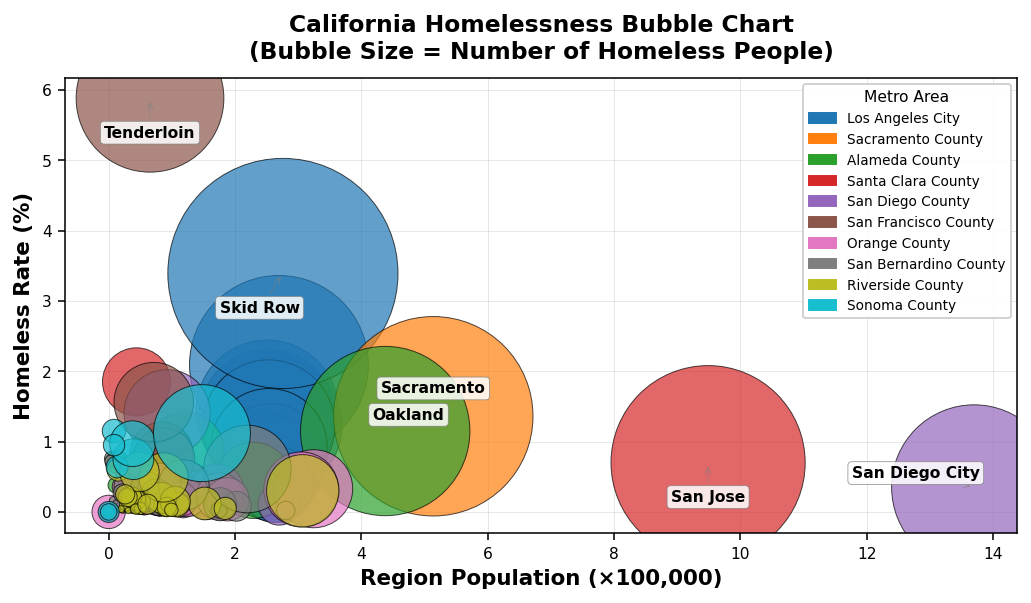

LinkedIn landscape chart created:
- Dimensions: 8.5 x 5.0 inches at 140 DPI
- Output size: ~1190 x 700 pixels
- Optimized for LinkedIn feed display
- All major bubbles labeled clearly


In [ ]:
# ================================================================================
# CALIFORNIA HOMELESSNESS BUBBLE CHART - LINKEDIN LANDSCAPE OPTIMIZED
# ================================================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import pandas as pd

# === Load data ===
data_path = "/content/drive/MyDrive/Kaggle/Datasets/California/Output/california_total_and_homeless_with_rate.csv"
df = pd.read_csv(data_path)

# === Clean and filter ===
df["REGION_TYPE"] = df["REGION_TYPE"].astype(str).str.strip()
df["METRO"] = df["METRO"].astype(str).str.strip()
df["HOMELESS_RATE_NUM"] = df["HOMELESS_PERCENTAGE"]
df = df[~df["REGION_TYPE"].str.contains("Unincorporated", case=False, na=False)]

# === Apply friendly label overrides ===
df["LABEL_NAME"] = df["REGION_NAME"]
df.loc[df["REGION_CODE"] == "LA_14", "LABEL_NAME"] = "Skid Row"
df.loc[df["REGION_CODE"] == "LA_09", "LABEL_NAME"] = "South LA"
df.loc[df["REGION_CODE"] == "AL_10", "LABEL_NAME"] = "Oakland"
df.loc[df["REGION_CODE"] == "SAC_01", "LABEL_NAME"] = "Sacramento"
df.loc[df["REGION_CODE"] == "SC_12", "LABEL_NAME"] = "San Jose"
df.loc[df["REGION_CODE"] == "SD_01", "LABEL_NAME"] = "San Diego City"
df.loc[df["REGION_CODE"] == "SF_06", "LABEL_NAME"] = "Tenderloin"

def create_linkedin_landscape_chart():
    """Create LinkedIn landscape format - compact and well-proportioned"""
    # Balanced landscape ratio - not too wide, not too tall
    fig_width = 8.5
    fig_height = 5.0

    plt.figure(figsize=(fig_width, fig_height), dpi=140)

    scatter = plt.scatter(
        df["TOTAL_POPULATION"],
        df["HOMELESS_RATE_NUM"],
        s=df["HOMELESS_POPULATION"] * 1.5,
        c=pd.factorize(df["METRO"])[0],
        alpha=0.7,
        edgecolors="black",
        linewidths=0.5,
        cmap='tab10'
    )

    # Compact legend
    unique_metros = df["METRO"].unique()
    colors = plt.cm.tab10.colors
    patches = [
        mpatches.Patch(color=colors[i % len(colors)], label=metro)
        for i, metro in enumerate(unique_metros)
    ]
    legend = plt.legend(handles=patches, title="Metro Area",
                       loc="upper right", frameon=True,
                       fontsize=7, title_fontsize=8,
                       framealpha=0.9)

    # Optimized fonts for compact format
    plt.xlabel("Region Population (×100,000)", fontsize=11, fontweight='semibold')
    plt.ylabel("Homeless Rate (%)", fontsize=11, fontweight='semibold')
    plt.title("California Homelessness Bubble Chart\n(Bubble Size = Number of Homeless People)",
              fontsize=12, fontweight='bold', pad=10)

    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    plt.gca().set_axisbelow(True)
    plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1e5):,}"))
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(200_000))
    plt.gca().tick_params(axis='both', labelsize=8)

    # Label the major bubbles
    key_labels = ["SF_06", "LA_14", "SD_01", "SAC_01", "SC_12", "AL_10"]

    for _, row in df.iterrows():
        if row["REGION_CODE"] in key_labels:
            label = f"{row['LABEL_NAME']}"

            offset_x = 5
            offset_y = 5

            if row["REGION_CODE"] == "SF_06":  # Tenderloin
                offset_y = -20
                offset_x = 0
            elif row["REGION_CODE"] == "LA_14":  # Skid Row
                offset_y = -20
                offset_x = -12
            elif row["REGION_CODE"] == "SD_01":  # San Diego City
                offset_x = -30
                offset_y = 5
            elif row["REGION_CODE"] == "SAC_01":  # Sacramento
                offset_y = 12
                offset_x = 0
            elif row["REGION_CODE"] == "SC_12":  # San Jose
                offset_x = 0
                offset_y = -20
            elif row["REGION_CODE"] == "AL_10":  # Oakland
                offset_x = 12
                offset_y = 6

            plt.annotate(
                label,
                (row["TOTAL_POPULATION"], row["HOMELESS_RATE_NUM"]),
                textcoords="offset points",
                xytext=(offset_x, offset_y),
                ha='center',
                fontsize=8,
                fontweight="bold",
                bbox=dict(boxstyle="round,pad=0.25", facecolor="white",
                         alpha=0.85, edgecolor='gray', linewidth=0.4),
                arrowprops=dict(arrowstyle="->", color='gray', alpha=0.7, lw=0.4)
            )

    # Fine-tune margins for perfect fit
    plt.tight_layout(pad=0.8)
    plt.subplots_adjust(left=0.12, right=0.92, top=0.85, bottom=0.20)

    # Save optimized LinkedIn landscape format
    save_path = '/content/drive/MyDrive/Kaggle/Images/'
    plt.savefig(f'{save_path}linkedin_landscape_final.png',
                dpi=140, bbox_inches='tight', facecolor='white',
                edgecolor='none', pad_inches=0.1)
    plt.show()

    print("LinkedIn landscape chart created:")
    print("- Dimensions: 8.5 x 5.0 inches at 140 DPI")
    print("- Output size: ~1190 x 700 pixels")
    print("- Optimized for LinkedIn feed display")
    print("- All major bubbles labeled clearly")

# Create the landscape chart
create_linkedin_landscape_chart()

# Adding Census ACS Demographics

## COMBINE ALL TRACT LOOKUP FILES AND CREATE ACS-READY MASTER TABLE

In [ ]:
# ================================================================================
# COMBINE ALL TRACT LOOKUP FILES AND CREATE ACS-READY MASTER TABLE
# ================================================================================

# === File Paths ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets/California/Output"

# List of input file paths for each county tract lookup CSV
file_paths = [
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Los Angeles City/Output/la_tract_lookup.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Sacramento County/Output/sa_tract_lookup.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Alameda County/Output/al_tract_lookup.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Santa Clara County/Output/sc_tract_lookup.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/San Diego County/Output/sd_tract_lookup.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/San Francisco County/Output/sf_tract_lookup.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Orange County/Output/oc_tract_lookup.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/San Bernardino County/Output/sb_tract_lookup.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Riverside County/Output/rv_tract_lookup.csv",
    "/content/drive/MyDrive/Kaggle/Datasets/Counties/Sonoma County/Output/so_tract_lookup.csv",
]

# Output file paths
combined_lookup_path = os.path.join(base_path, "california_tract_lookup_combined.csv")
homeless_pop_file = os.path.join(base_path, "california_total_and_homeless_with_rate.csv")
final_output_path = os.path.join(base_path, "california_acs_master_table.csv")

# === STEP 1: Combine all tract lookup files ===
df_list = []
for file_path in file_paths:
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df_list.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv(combined_lookup_path, index=False)

# === STEP 2: Load homeless/population data ===
homeless_pop = pd.read_csv(homeless_pop_file)

# === STEP 3: Join and create final ACS-ready table ===
# Clean REGION_CODE for joining
combined_df["REGION_CODE"] = combined_df["REGION_CODE"].astype(str).str.strip()
homeless_pop["REGION_CODE"] = homeless_pop["REGION_CODE"].astype(str).str.strip()

# Join the data
master_table = combined_df.merge(
    homeless_pop[["REGION_CODE", "HOMELESS_POPULATION", "HOMELESS_PERCENTAGE"]],
    on="REGION_CODE",
    how="left"
)

# Create final table with required columns
final_table = pd.DataFrame()
final_table["METRO"] = master_table["METRO"]
final_table["GEO_ID"] = master_table["GEO_ID"]
final_table["REGION_NAME"] = master_table["REGION_NAME"]
final_table["REGION_CODE"] = master_table["REGION_CODE"]
final_table["TOTAL_POPULATION"] = master_table["TOTAL_POPULATION"]
final_table["HOMELESS_POPULATION"] = master_table["HOMELESS_POPULATION"].fillna(0).astype(int)
final_table["HOMELESS_RATE"] = master_table["HOMELESS_PERCENTAGE"].fillna(0)

# Save final table
final_table.to_csv(final_output_path, index=False)

# === Display results ===
print("FINAL ACS-READY MASTER TABLE CREATED")
print("=" * 80)
print(final_table.head(10).to_string(index=False))

print(f"\nSUMMARY INFORMATION:")
print("=" * 40)
print(f"Number of Metros: {final_table['METRO'].nunique():,}")
print(f"Number of Regions: {final_table['REGION_CODE'].nunique():,}")
print(f"Number of Tracts: {final_table['GEO_ID'].nunique():,}")
print(f"Total Population: {final_table['TOTAL_POPULATION'].sum():,}")

print(f"\nSaved to: {final_output_path}")

FINAL ACS-READY MASTER TABLE CREATED
           METRO               GEO_ID REGION_NAME REGION_CODE  TOTAL_POPULATION  HOMELESS_POPULATION  HOMELESS_RATE
Los Angeles City 1400000US06037183510  District 1       LA_01              2346                 3336           1.33
Los Angeles City 1400000US06037183520  District 1       LA_01              3850                 3336           1.33
Los Angeles City 1400000US06037183610  District 1       LA_01              3042                 3336           1.33
Los Angeles City 1400000US06037183620  District 1       LA_01              3038                 3336           1.33
Los Angeles City 1400000US06037183701  District 1       LA_01              3181                 3336           1.33
Los Angeles City 1400000US06037183810  District 1       LA_01              4259                 3336           1.33
Los Angeles City 1400000US06037183820  District 1       LA_01              3352                 3336           1.33
Los Angeles City 1400000US060371851

## B01001: Sex and Age
B01001 from the American Community Survey provides detailed population counts by sex and age in granular age brackets (single years for some ages, small ranges for others). This table is essential for demographic analysis as it captures the age and gender distribution of populations down to the census tract level. For homeless research, B01001 enables comparison of age and gender patterns between homeless populations and housed populations, helping identify whether certain age groups or genders are disproportionately represented in homeless counts relative to the general population demographics of the same areas.

In [ ]:
# ================================================================================
# B01001 ACS TABLE
# ================================================================================

# === File Paths ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets/California/Output"
master_table_path = os.path.join(base_path, "california_acs_master_table.csv")
b01001_data_path = os.path.join(base_path, "b01001_tract_level_counts.csv")
final_output_path = os.path.join(base_path, "B01001_acs_master_table.csv")
tract_lookup_path = os.path.join(base_path, "california_tract_lookup_combined.csv")
acs_path = "/content/drive/MyDrive/Kaggle/Datasets/Census/ACSDT5Y2022.B01001-Data.csv"

# === Always recreate the B01001 file to ensure it's correct ===
# Load ACS file
acs_full = pd.read_csv(acs_path, dtype={"GEO_ID": str})
acs_full.columns = acs_full.columns.str.strip()

# FIXED: Skip only row 0 (headers), keep row 1+ (including our missing tract)
acs_data = acs_full.iloc[1:].copy()
acs_data = acs_data[acs_data["NAME"].str.contains("Census Tract", na=False)].copy()

# Keep only GEO_ID and estimate columns (ending with E, but not M for margins)
keep_cols = ["GEO_ID"] + [col for col in acs_data.columns if col.endswith("E") and not col.endswith("NAME")]
acs_data = acs_data[keep_cols].copy()

# Clean GEO_ID
acs_data["GEO_ID"] = acs_data["GEO_ID"].astype(str).str.strip()

# Convert estimate columns to numeric, then to int
estimate_cols = [col for col in acs_data.columns if col.endswith("E") and col != "GEO_ID"]
for col in estimate_cols:
    acs_data[col] = pd.to_numeric(acs_data[col], errors="coerce").astype('Int64')

# Load tract lookup
tract_df = pd.read_csv(tract_lookup_path, dtype={"GEO_ID": str})
tract_df["GEO_ID"] = tract_df["GEO_ID"].astype(str).str.strip()

# Merge
merged = tract_df.merge(acs_data, on="GEO_ID", how="left")

# Save the tract-level file
merged.to_csv(b01001_data_path, index=False)

# === Now create the master table ===
# Load master table
master_table = pd.read_csv(master_table_path, dtype={"GEO_ID": str})
master_table["GEO_ID"] = master_table["GEO_ID"].str.strip()

# Get B01001 columns to merge (excluding base columns)
b01001_cols_to_merge = [col for col in merged.columns
                       if col not in ["METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]]

# Left join master table to B01001 data
final_table = master_table.merge(
    merged[b01001_cols_to_merge],
    on="GEO_ID",
    how="left"
)

# Save final table
final_table.to_csv(final_output_path, index=False)

# === Read back and display info ===
print("FIXED B01001 TABLE INFO:")
print("=" * 30)
df_check = pd.read_csv(final_output_path)

# Convert ACS estimate columns to integers
acs_estimate_cols = [col for col in df_check.columns if col.startswith('B01001_') and col.endswith('E')]
for col in acs_estimate_cols:
    df_check[col] = df_check[col].astype('Int64')

# Overwrite the CSV with proper integer types
df_check.to_csv(final_output_path, index=False)

df_check.info()

# Check for the previously missing tract
missing_geo_id = "1400000US06001400100"
found_tract = df_check[df_check['GEO_ID'] == missing_geo_id]
if len(found_tract) > 0:
    has_data = not pd.isna(found_tract.iloc[0]['B01001_001E'])
    print(f"\n PREVIOUSLY MISSING TRACT NOW FOUND!")
    print(f"GEO_ID: {missing_geo_id}")
    print(f"Has ACS data: {'✓' if has_data else ''}")
    if has_data:
        print(f"B01001_001E (total pop): {found_tract.iloc[0]['B01001_001E']}")

# Calculate unmatched GEO_IDs
master_geo_ids = set(master_table["GEO_ID"])
b01001_geo_ids = set(merged["GEO_ID"])
unmatched_geo_ids = master_geo_ids - b01001_geo_ids
unmatched_count = len(unmatched_geo_ids)

print(f"\nSUMMARY:")
print("=" * 15)
print(f"Total tracts: {len(df_check):,}")
print(f"Tracts with ACS data: {df_check['B01001_001E'].notna().sum():,}")
print(f"Missing ACS data: {unmatched_count:,}")
print(f"\nSaved to: {final_output_path}")

/tmp/ipython-input-29-3201400582.py:15: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  acs_full = pd.read_csv(acs_path, dtype={"GEO_ID": str})


FIXED B01001 TABLE INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4948 entries, 0 to 4947
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   METRO                4948 non-null   object 
 1   GEO_ID               4948 non-null   object 
 2   REGION_NAME          4948 non-null   object 
 3   REGION_CODE          4948 non-null   object 
 4   TOTAL_POPULATION     4948 non-null   int64  
 5   HOMELESS_POPULATION  4948 non-null   int64  
 6   HOMELESS_RATE        4948 non-null   float64
 7   B01001_001E          4948 non-null   Int64  
 8   B01001_002E          4948 non-null   Int64  
 9   B01001_003E          4948 non-null   Int64  
 10  B01001_004E          4948 non-null   Int64  
 11  B01001_005E          4948 non-null   Int64  
 12  B01001_006E          4948 non-null   Int64  
 13  B01001_007E          4948 non-null   Int64  
 14  B01001_008E          4948 non-null   Int64  
 15  B01001_009E  

##B11003: Families and Households
B11003 from the American Community Survey provides detailed information on the structure of families within households, distinguishing between married-couple families, male- and female-headed families without spouses, and the presence of own children under age 18. This table breaks down households by key parental arrangements and the age of children, offering insight into family composition across geographic areas. B11003 is especially useful for analyzing family stability, single parenthood, and childcare needs—factors that are critical for social services planning, education policy, and understanding the socioeconomic challenges faced by families. For research on housing instability or poverty, this table helps identify concentrations of vulnerable family types, such as single-mother households with young children.

In [ ]:
# ================================================================================
# B11003 ACS TABLE
# ================================================================================


# === File Paths ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets/California/Output"
master_table_path = os.path.join(base_path, "california_acs_master_table.csv")
b11003_data_path = os.path.join(base_path, "b11003_tract_level_counts.csv")
final_output_path = os.path.join(base_path, "B11003_acs_master_table.csv")
tract_lookup_path = os.path.join(base_path, "california_tract_lookup_combined.csv")
acs_path = "/content/drive/MyDrive/Kaggle/Datasets/Census/ACSDT5Y2022.B11003-Data.csv"

# === Always recreate the B11003 file to ensure it's correct ===
# Load ACS file
acs_full = pd.read_csv(acs_path, dtype={"GEO_ID": str})
acs_full.columns = acs_full.columns.str.strip()

# FIXED: Skip only row 0 (headers), include row 1+
acs_data = acs_full.iloc[1:].copy()
acs_data = acs_data[acs_data["NAME"].str.contains("Census Tract", na=False)].copy()

# Keep only GEO_ID and estimate columns
keep_cols = ["GEO_ID"] + [col for col in acs_data.columns if col.endswith("E") and not col.endswith("NAME")]
acs_data = acs_data[keep_cols].copy()

# Clean GEO_ID
acs_data["GEO_ID"] = acs_data["GEO_ID"].astype(str).str.strip()

# FIXED: Convert estimate columns to integers
estimate_cols = [col for col in acs_data.columns if col.endswith("E") and col != "GEO_ID"]
for col in estimate_cols:
    acs_data[col] = pd.to_numeric(acs_data[col], errors="coerce").astype('Int64')

# Load tract lookup
tract_df = pd.read_csv(tract_lookup_path, dtype={"GEO_ID": str})
tract_df["GEO_ID"] = tract_df["GEO_ID"].astype(str).str.strip()

# Merge
merged = tract_df.merge(acs_data, on="GEO_ID", how="left")

# Save the tract-level file
merged.to_csv(b11003_data_path, index=False)

# === Now create the master table ===
# Load master table
master_table = pd.read_csv(master_table_path, dtype={"GEO_ID": str})
master_table["GEO_ID"] = master_table["GEO_ID"].str.strip()

# Get B11003 columns to merge (excluding base columns)
b11003_cols_to_merge = [col for col in merged.columns
                       if col not in ["METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]]

# Left join master table to B11003 data
final_table = master_table.merge(
    merged[b11003_cols_to_merge],
    on="GEO_ID",
    how="left"
)

# Save final table
final_table.to_csv(final_output_path, index=False)

# === Read back and display info ===
print("FIXED B11003 TABLE INFO:")
print("=" * 30)
df_check = pd.read_csv(final_output_path)

# Convert ACS estimate columns to integers
acs_estimate_cols = [col for col in df_check.columns if col.startswith('B11003_') and col.endswith('E')]
for col in acs_estimate_cols:
    df_check[col] = df_check[col].astype('Int64')

# Overwrite the CSV with proper integer types
df_check.to_csv(final_output_path, index=False)

df_check.info()

# Check for the previously missing tract
missing_geo_id = "1400000US06001400100"
found_tract = df_check[df_check['GEO_ID'] == missing_geo_id]
if len(found_tract) > 0:
    has_data = not pd.isna(found_tract.iloc[0]['B11003_001E'])
    print(f"\nTARGET TRACT FOUND!")
    print(f"GEO_ID: {missing_geo_id}")
    print(f"Has B11003 data: {has_data}")
    if has_data:
        print(f"B11003_001E (total households): {found_tract.iloc[0]['B11003_001E']}")

# Calculate unmatched GEO_IDs
master_geo_ids = set(master_table["GEO_ID"])
b11003_geo_ids = set(merged["GEO_ID"])
unmatched_geo_ids = master_geo_ids - b11003_geo_ids
unmatched_count = len(unmatched_geo_ids)

# Display results
print("\nFINAL B11003 ACS MASTER TABLE CREATED")
print("=" * 80)
print(final_table.head(10).to_string(index=False))

print(f"\nSUMMARY INFORMATION:")
print("=" * 40)
print(f"Number of Metros: {final_table['METRO'].nunique():,}")
print(f"Number of Regions: {final_table['REGION_CODE'].nunique():,}")
print(f"Number of Tracts: {final_table['GEO_ID'].nunique():,}")
print(f"Total Population: {final_table['TOTAL_POPULATION'].sum():,}")
print(f"GEO_IDs that did NOT match ACS B11003: {unmatched_count:,}")

print(f"\nSaved to: {final_output_path}")
print("Ready for analysis with B11003 families and households data!")

FIXED B11003 TABLE INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4948 entries, 0 to 4947
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   METRO                4948 non-null   object 
 1   GEO_ID               4948 non-null   object 
 2   REGION_NAME          4948 non-null   object 
 3   REGION_CODE          4948 non-null   object 
 4   TOTAL_POPULATION     4948 non-null   int64  
 5   HOMELESS_POPULATION  4948 non-null   int64  
 6   HOMELESS_RATE        4948 non-null   float64
 7   B11003_001E          4948 non-null   Int64  
 8   B11003_002E          4948 non-null   Int64  
 9   B11003_003E          4948 non-null   Int64  
 10  B11003_004E          4948 non-null   Int64  
 11  B11003_005E          4948 non-null   Int64  
 12  B11003_006E          4948 non-null   Int64  
 13  B11003_007E          4948 non-null   Int64  
 14  B11003_008E          4948 non-null   Int64  
 15  B11003_009E  

##B18101: Disabilities
B18101 from the American Community Survey provides disability status information by sex and age groups, identifying individuals with hearing, vision, cognitive, ambulatory, self-care, or independent living difficulties. This table captures functional limitations that may affect daily activities and is particularly relevant for homeless research given the high prevalence of disabilities among homeless populations. B18101 enables comparison between disability rates in homeless populations versus the general population, helping identify service needs and assess whether individuals with disabilities are disproportionately represented among those experiencing homelessness in specific geographic areas.

In [ ]:
# ================================================================================
# B18101 ACS TABLE
# ================================================================================


# === File Paths ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets/California/Output"
master_table_path = os.path.join(base_path, "california_acs_master_table.csv")
b18101_data_path = os.path.join(base_path, "b18101_tract_level_counts.csv")
final_output_path = os.path.join(base_path, "B18101_acs_master_table.csv")
tract_lookup_path = os.path.join(base_path, "california_tract_lookup_combined.csv")
acs_path = "/content/drive/MyDrive/Kaggle/Datasets/Census/ACSDT5Y2022.B18101-Data.csv"

# === Always recreate the B18101 file to ensure it's correct ===
# Load ACS file
acs_full = pd.read_csv(acs_path, dtype={"GEO_ID": str})
acs_full.columns = acs_full.columns.str.strip()

# Skip headers and get data rows
acs_data = acs_full.iloc[1:].copy()
acs_data = acs_data[acs_data["NAME"].str.contains("Census Tract", na=False)].copy()

# Keep only GEO_ID and estimate columns
keep_cols = ["GEO_ID"] + [col for col in acs_data.columns if col.endswith("E") and not col.endswith("NAME")]
acs_data = acs_data[keep_cols].copy()

# Clean GEO_ID
acs_data["GEO_ID"] = acs_data["GEO_ID"].astype(str).str.strip()

# Convert estimate columns to numeric, then to int
estimate_cols = [col for col in acs_data.columns if col.endswith("E") and col != "GEO_ID"]
for col in estimate_cols:
    acs_data[col] = pd.to_numeric(acs_data[col], errors="coerce").astype('Int64')

# Load tract lookup
tract_df = pd.read_csv(tract_lookup_path, dtype={"GEO_ID": str})
tract_df["GEO_ID"] = tract_df["GEO_ID"].astype(str).str.strip()

# Merge
merged = tract_df.merge(acs_data, on="GEO_ID", how="left")

# Save the tract-level file
merged.to_csv(b18101_data_path, index=False)

# === Now create the master table ===
# Load master table
master_table = pd.read_csv(master_table_path, dtype={"GEO_ID": str})
master_table["GEO_ID"] = master_table["GEO_ID"].str.strip()

# Get B18101 columns to merge (excluding base columns)
b18101_cols_to_merge = [col for col in merged.columns
                       if col not in ["METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]]

# Left join master table to B18101 data
final_table = master_table.merge(
    merged[b18101_cols_to_merge],
    on="GEO_ID",
    how="left"
)

# Save final table
final_table.to_csv(final_output_path, index=False)

# === Read back and display info ===
print("FINAL B18101 TABLE INFO:")
print("=" * 30)
df_check = pd.read_csv(final_output_path)

# Convert ACS estimate columns to integers
acs_estimate_cols = [col for col in df_check.columns if col.startswith('B18101_') and col.endswith('E')]
for col in acs_estimate_cols:
    df_check[col] = df_check[col].astype('Int64')

# Overwrite the CSV with proper integer types
df_check.to_csv(final_output_path, index=False)

df_check.info()
print()

# Calculate unmatched GEO_IDs
master_geo_ids = set(master_table["GEO_ID"])
b18101_geo_ids = set(merged["GEO_ID"])
unmatched_geo_ids = master_geo_ids - b18101_geo_ids
unmatched_count = len(unmatched_geo_ids)

# Display results
print("\nFINAL B18101 ACS MASTER TABLE CREATED")
print("=" * 80)
print(final_table.head(10).to_string(index=False))

print(f"\nSUMMARY INFORMATION:")
print("=" * 40)
print(f"Number of Metros: {final_table['METRO'].nunique():,}")
print(f"Number of Regions: {final_table['REGION_CODE'].nunique():,}")
print(f"Number of Tracts: {final_table['GEO_ID'].nunique():,}")
print(f"Total Population: {final_table['TOTAL_POPULATION'].sum():,}")
print(f"GEO_IDs that did NOT match ACS B18101: {unmatched_count:,}")

print(f"\nSaved to: {final_output_path}")
print("Ready for analysis with B18101 disability by sex and age data!")

/tmp/ipython-input-31-1601916583.py:16: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  acs_full = pd.read_csv(acs_path, dtype={"GEO_ID": str})


FINAL B18101 TABLE INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4948 entries, 0 to 4947
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   METRO                4948 non-null   object 
 1   GEO_ID               4948 non-null   object 
 2   REGION_NAME          4948 non-null   object 
 3   REGION_CODE          4948 non-null   object 
 4   TOTAL_POPULATION     4948 non-null   int64  
 5   HOMELESS_POPULATION  4948 non-null   int64  
 6   HOMELESS_RATE        4948 non-null   float64
 7   B18101_001E          4948 non-null   Int64  
 8   B18101_002E          4948 non-null   Int64  
 9   B18101_003E          4948 non-null   Int64  
 10  B18101_004E          4948 non-null   Int64  
 11  B18101_005E          4948 non-null   Int64  
 12  B18101_006E          4948 non-null   Int64  
 13  B18101_007E          4948 non-null   Int64  
 14  B18101_008E          4948 non-null   Int64  
 15  B18101_009E  

## B21001: Veteran Status
B21001 from the American Community Survey identifies veteran status for the civilian population 18 years and over, broken down by age groups and sex. This table captures individuals who have served on active duty in the U.S. Armed Forces, Reserves, or National Guard. Veterans are a key subpopulation in homeless research due to their elevated risk of homelessness and the specialized services available to them. B21001 allows researchers to compare veteran representation in homeless populations against the baseline veteran population in the same geographic areas, helping assess whether veterans are disproportionately experiencing homelessness and informing targeted intervention strategies.

In [ ]:
# ================================================================================
# B21001 ACS TABLE
# ================================================================================


# === File Paths ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets/California/Output"
master_table_path = os.path.join(base_path, "california_acs_master_table.csv")
b21001_data_path = os.path.join(base_path, "b21001_tract_level_counts.csv")
final_output_path = os.path.join(base_path, "B21001_acs_master_table.csv")
tract_lookup_path = os.path.join(base_path, "california_tract_lookup_combined.csv")
acs_path = "/content/drive/MyDrive/Kaggle/Datasets/Census/ACSDT5Y2022.B21001-Data.csv"

# === Always recreate the B21001 file to ensure it's correct ===
# Load ACS file
acs_full = pd.read_csv(acs_path, dtype={"GEO_ID": str})
acs_full.columns = acs_full.columns.str.strip()

# Skip headers and get data rows
acs_data = acs_full.iloc[1:].copy()
acs_data = acs_data[acs_data["NAME"].str.contains("Census Tract", na=False)].copy()

# Keep only GEO_ID and estimate columns
keep_cols = ["GEO_ID"] + [col for col in acs_data.columns if col.endswith("E") and not col.endswith("NAME")]
acs_data = acs_data[keep_cols].copy()

# Clean GEO_ID
acs_data["GEO_ID"] = acs_data["GEO_ID"].astype(str).str.strip()

# Convert estimate columns to numeric, then to int
estimate_cols = [col for col in acs_data.columns if col.endswith("E") and col != "GEO_ID"]
for col in estimate_cols:
    acs_data[col] = pd.to_numeric(acs_data[col], errors="coerce").astype('Int64')

# Load tract lookup
tract_df = pd.read_csv(tract_lookup_path, dtype={"GEO_ID": str})
tract_df["GEO_ID"] = tract_df["GEO_ID"].astype(str).str.strip()

# Merge
merged = tract_df.merge(acs_data, on="GEO_ID", how="left")

# Save the tract-level file
merged.to_csv(b21001_data_path, index=False)

# === Now create the master table ===
# Load master table
master_table = pd.read_csv(master_table_path, dtype={"GEO_ID": str})
master_table["GEO_ID"] = master_table["GEO_ID"].str.strip()

# Get B21001 columns to merge (excluding base columns)
b21001_cols_to_merge = [col for col in merged.columns
                       if col not in ["METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]]

# Left join master table to B21001 data
final_table = master_table.merge(
    merged[b21001_cols_to_merge],
    on="GEO_ID",
    how="left"
)

# Save final table
final_table.to_csv(final_output_path, index=False)

# === Read back and display info ===
print("FINAL B21001 TABLE INFO:")
print("=" * 30)
df_check = pd.read_csv(final_output_path)

# Convert ACS estimate columns to integers
acs_estimate_cols = [col for col in df_check.columns if col.startswith('B21001_') and col.endswith('E')]
for col in acs_estimate_cols:
    df_check[col] = df_check[col].astype('Int64')

# Overwrite the CSV with proper integer types
df_check.to_csv(final_output_path, index=False)

df_check.info()
print()

# Calculate unmatched GEO_IDs
master_geo_ids = set(master_table["GEO_ID"])
b21001_geo_ids = set(merged["GEO_ID"])
unmatched_geo_ids = master_geo_ids - b21001_geo_ids
unmatched_count = len(unmatched_geo_ids)

# Display results
print("\nFINAL B21001 ACS MASTER TABLE CREATED")
print("=" * 80)
print(final_table.head(10).to_string(index=False))

print(f"\nSUMMARY INFORMATION:")
print("=" * 40)
print(f"Number of Metros: {final_table['METRO'].nunique():,}")
print(f"Number of Regions: {final_table['REGION_CODE'].nunique():,}")
print(f"Number of Tracts: {final_table['GEO_ID'].nunique():,}")
print(f"Total Population: {final_table['TOTAL_POPULATION'].sum():,}")
print(f"GEO_IDs that did NOT match ACS B21001: {unmatched_count:,}")

print(f"\nSaved to: {final_output_path}")
print("Ready for analysis with B21001 veteran status data!")

/tmp/ipython-input-32-1216307529.py:16: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  acs_full = pd.read_csv(acs_path, dtype={"GEO_ID": str})


FINAL B21001 TABLE INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4948 entries, 0 to 4947
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   METRO                4948 non-null   object 
 1   GEO_ID               4948 non-null   object 
 2   REGION_NAME          4948 non-null   object 
 3   REGION_CODE          4948 non-null   object 
 4   TOTAL_POPULATION     4948 non-null   int64  
 5   HOMELESS_POPULATION  4948 non-null   int64  
 6   HOMELESS_RATE        4948 non-null   float64
 7   B21001_001E          4948 non-null   Int64  
 8   B21001_002E          4948 non-null   Int64  
 9   B21001_003E          4948 non-null   Int64  
 10  B21001_004E          4948 non-null   Int64  
 11  B21001_005E          4948 non-null   Int64  
 12  B21001_006E          4948 non-null   Int64  
 13  B21001_007E          4948 non-null   Int64  
 14  B21001_008E          4948 non-null   Int64  
 15  B21001_009E  

## B03002: Race and Hispanic Origin

B03002 provides detailed population counts by Hispanic or Latino origin, further broken down by racial categories. This table captures the ethnic and racial composition of geographic areas, distinguishing between those who identify as Hispanic or Latino and those who do not, while also detailing race categories such as White, Black or African American, Asian, and others. Understanding the racial and ethnic makeup of populations is essential for homelessness research, as different groups may experience distinct risk factors and disparities. Using B03002 data allows researchers to compare the racial and ethnic demographics of homeless populations with those of the broader community, supporting culturally informed policy and targeted outreach efforts in California metropolitan areas.

In [ ]:
# ================================================================================
# B03002 ACS TABLE
# ================================================================================


# === File Paths ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets/California/Output"
master_table_path = os.path.join(base_path, "california_acs_master_table.csv")
b03002_data_path = os.path.join(base_path, "b03002_tract_level_counts.csv")
final_output_path = os.path.join(base_path, "B03002_acs_master_table.csv")
tract_lookup_path = os.path.join(base_path, "california_tract_lookup_combined.csv")
acs_path = "/content/drive/MyDrive/Kaggle/Datasets/Census/ACSDT5Y2022.B03002-Data.csv"

# === Always recreate the B03002 file to ensure it's correct ===
# Load ACS file
acs_full = pd.read_csv(acs_path, dtype={"GEO_ID": str})
acs_full.columns = acs_full.columns.str.strip()

# Skip headers and get data rows
acs_data = acs_full.iloc[1:].copy()
acs_data = acs_data[acs_data["NAME"].str.contains("Census Tract", na=False)].copy()

# Keep only GEO_ID and estimate columns
keep_cols = ["GEO_ID"] + [col for col in acs_data.columns if col.endswith("E") and not col.endswith("NAME")]
acs_data = acs_data[keep_cols].copy()

# Clean GEO_ID
acs_data["GEO_ID"] = acs_data["GEO_ID"].astype(str).str.strip()

# Convert estimate columns to numeric, then to int
estimate_cols = [col for col in acs_data.columns if col.endswith("E") and col != "GEO_ID"]
for col in estimate_cols:
    acs_data[col] = pd.to_numeric(acs_data[col], errors="coerce").astype('Int64')

# Load tract lookup
tract_df = pd.read_csv(tract_lookup_path, dtype={"GEO_ID": str})
tract_df["GEO_ID"] = tract_df["GEO_ID"].astype(str).str.strip()

# Merge
merged = tract_df.merge(acs_data, on="GEO_ID", how="left")

# Save the tract-level file
merged.to_csv(b03002_data_path, index=False)

# === Now create the master table ===
# Load master table
master_table = pd.read_csv(master_table_path, dtype={"GEO_ID": str})
master_table["GEO_ID"] = master_table["GEO_ID"].str.strip()

# Get B03002 columns to merge (excluding base columns)
b03002_cols_to_merge = [col for col in merged.columns
                       if col not in ["METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]]

# Left join master table to B03002 data
final_table = master_table.merge(
    merged[b03002_cols_to_merge],
    on="GEO_ID",
    how="left"
)

# Save final table
final_table.to_csv(final_output_path, index=False)

# === Read back and display info ===
print("FINAL B03002 TABLE INFO:")
print("=" * 30)
df_check = pd.read_csv(final_output_path)

# Convert ACS estimate columns to integers
acs_estimate_cols = [col for col in df_check.columns if col.startswith('B03002_') and col.endswith('E')]
for col in acs_estimate_cols:
    df_check[col] = df_check[col].astype('Int64')

# Overwrite the CSV with proper integer types
df_check.to_csv(final_output_path, index=False)

df_check.info()
print()

# Calculate unmatched GEO_IDs
master_geo_ids = set(master_table["GEO_ID"])
b03002_geo_ids = set(merged["GEO_ID"])
unmatched_geo_ids = master_geo_ids - b03002_geo_ids
unmatched_count = len(unmatched_geo_ids)

# Display results
print("\nFINAL B03002 ACS MASTER TABLE CREATED")
print("=" * 80)
print(final_table.head(10).to_string(index=False))

print(f"\nSUMMARY INFORMATION:")
print("=" * 40)
print(f"Number of Metros: {final_table['METRO'].nunique():,}")
print(f"Number of Regions: {final_table['REGION_CODE'].nunique():,}")
print(f"Number of Tracts: {final_table['GEO_ID'].nunique():,}")
print(f"Total Population: {final_table['TOTAL_POPULATION'].sum():,}")
print(f"GEO_IDs that did NOT match ACS B03002: {unmatched_count:,}")

print(f"\nSaved to: {final_output_path}")
print("Ready for analysis with B03002 race and Hispanic origin data!")

FINAL B03002 TABLE INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4948 entries, 0 to 4947
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   METRO                4948 non-null   object 
 1   GEO_ID               4948 non-null   object 
 2   REGION_NAME          4948 non-null   object 
 3   REGION_CODE          4948 non-null   object 
 4   TOTAL_POPULATION     4948 non-null   int64  
 5   HOMELESS_POPULATION  4948 non-null   int64  
 6   HOMELESS_RATE        4948 non-null   float64
 7   B03002_001E          4948 non-null   Int64  
 8   B03002_002E          4948 non-null   Int64  
 9   B03002_003E          4948 non-null   Int64  
 10  B03002_004E          4948 non-null   Int64  
 11  B03002_005E          4948 non-null   Int64  
 12  B03002_006E          4948 non-null   Int64  
 13  B03002_007E          4948 non-null   Int64  
 14  B03002_008E          4948 non-null   Int64  
 15  B03002_009E  

## B15003: Education

B15003 details the highest level of education completed by individuals aged 25 and older, broken down by specific educational categories from no schooling to advanced degrees. Educational attainment is a key socioeconomic indicator linked to employment opportunities, income, and housing stability, making it valuable for analyzing risk factors related to homelessness and social vulnerability.

In [ ]:
# ================================================================================
# B15003 ACS TABLE
# ================================================================================


# === File Paths ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets/California/Output"
master_table_path = os.path.join(base_path, "california_acs_master_table.csv")
b15003_data_path = os.path.join(base_path, "b15003_tract_level_counts.csv")
final_output_path = os.path.join(base_path, "B15003_acs_master_table.csv")
tract_lookup_path = os.path.join(base_path, "california_tract_lookup_combined.csv")
acs_path = "/content/drive/MyDrive/Kaggle/Datasets/Census/ACSDT5Y2022.B15003-Data.csv"

# === Always recreate the B15003 file to ensure it's correct ===
# Load ACS file
acs_full = pd.read_csv(acs_path, dtype={"GEO_ID": str})
acs_full.columns = acs_full.columns.str.strip()

# Skip headers and get data rows
acs_data = acs_full.iloc[1:].copy()
acs_data = acs_data[acs_data["NAME"].str.contains("Census Tract", na=False)].copy()

# Keep only GEO_ID and estimate columns
keep_cols = ["GEO_ID"] + [col for col in acs_data.columns if col.endswith("E") and not col.endswith("NAME")]
acs_data = acs_data[keep_cols].copy()

# Clean GEO_ID
acs_data["GEO_ID"] = acs_data["GEO_ID"].astype(str).str.strip()

# Convert estimate columns to numeric, then to int
estimate_cols = [col for col in acs_data.columns if col.endswith("E") and col != "GEO_ID"]
for col in estimate_cols:
    acs_data[col] = pd.to_numeric(acs_data[col], errors="coerce").astype('Int64')

# Load tract lookup
tract_df = pd.read_csv(tract_lookup_path, dtype={"GEO_ID": str})
tract_df["GEO_ID"] = tract_df["GEO_ID"].astype(str).str.strip()

# Merge
merged = tract_df.merge(acs_data, on="GEO_ID", how="left")

# Save the tract-level file
merged.to_csv(b15003_data_path, index=False)

# === Now create the master table ===
# Load master table
master_table = pd.read_csv(master_table_path, dtype={"GEO_ID": str})
master_table["GEO_ID"] = master_table["GEO_ID"].str.strip()

# Get B15003 columns to merge (excluding base columns)
b15003_cols_to_merge = [col for col in merged.columns
                       if col not in ["METRO", "REGION_CODE", "REGION_NAME", "TOTAL_POPULATION"]]

# Left join master table to B15003 data
final_table = master_table.merge(
    merged[b15003_cols_to_merge],
    on="GEO_ID",
    how="left"
)

# Save final table
final_table.to_csv(final_output_path, index=False)

# === Read back and display info ===
print("FINAL B15003 TABLE INFO:")
print("=" * 30)
df_check = pd.read_csv(final_output_path)

# Convert ACS estimate columns to integers
acs_estimate_cols = [col for col in df_check.columns if col.startswith('B15003_') and col.endswith('E')]
for col in acs_estimate_cols:
    df_check[col] = df_check[col].astype('Int64')

# Overwrite the CSV with proper integer types
df_check.to_csv(final_output_path, index=False)

df_check.info()
print()

# Calculate unmatched GEO_IDs
master_geo_ids = set(master_table["GEO_ID"])
b15003_geo_ids = set(merged["GEO_ID"])
unmatched_geo_ids = master_geo_ids - b15003_geo_ids
unmatched_count = len(unmatched_geo_ids)

# Display results
print("\nFINAL B15003 ACS MASTER TABLE CREATED")
print("=" * 80)
print(final_table.head(10).to_string(index=False))

print(f"\nSUMMARY INFORMATION:")
print("=" * 40)
print(f"Number of Metros: {final_table['METRO'].nunique():,}")
print(f"Number of Regions: {final_table['REGION_CODE'].nunique():,}")
print(f"Number of Tracts: {final_table['GEO_ID'].nunique():,}")
print(f"Total Population: {final_table['TOTAL_POPULATION'].sum():,}")
print(f"GEO_IDs that did NOT match ACS B15003: {unmatched_count:,}")

print(f"\nSaved to: {final_output_path}")
print("Ready for analysis with B15003 educational attainment data!")

FINAL B15003 TABLE INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4948 entries, 0 to 4947
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   METRO                4948 non-null   object 
 1   GEO_ID               4948 non-null   object 
 2   REGION_NAME          4948 non-null   object 
 3   REGION_CODE          4948 non-null   object 
 4   TOTAL_POPULATION     4948 non-null   int64  
 5   HOMELESS_POPULATION  4948 non-null   int64  
 6   HOMELESS_RATE        4948 non-null   float64
 7   B15003_001E          4948 non-null   Int64  
 8   B15003_002E          4948 non-null   Int64  
 9   B15003_003E          4948 non-null   Int64  
 10  B15003_004E          4948 non-null   Int64  
 11  B15003_005E          4948 non-null   Int64  
 12  B15003_006E          4948 non-null   Int64  
 13  B15003_007E          4948 non-null   Int64  
 14  B15003_008E          4948 non-null   Int64  
 15  B15003_009E  

# Create a master table for analysis

/tmp/ipython-input-35-1116190605.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot.values(), labels=data_to_plot.keys(), showfliers=False)


 Box plot saved to: /content/drive/MyDrive/Kaggle/Images/homeless_vs_acs_boxplot.png


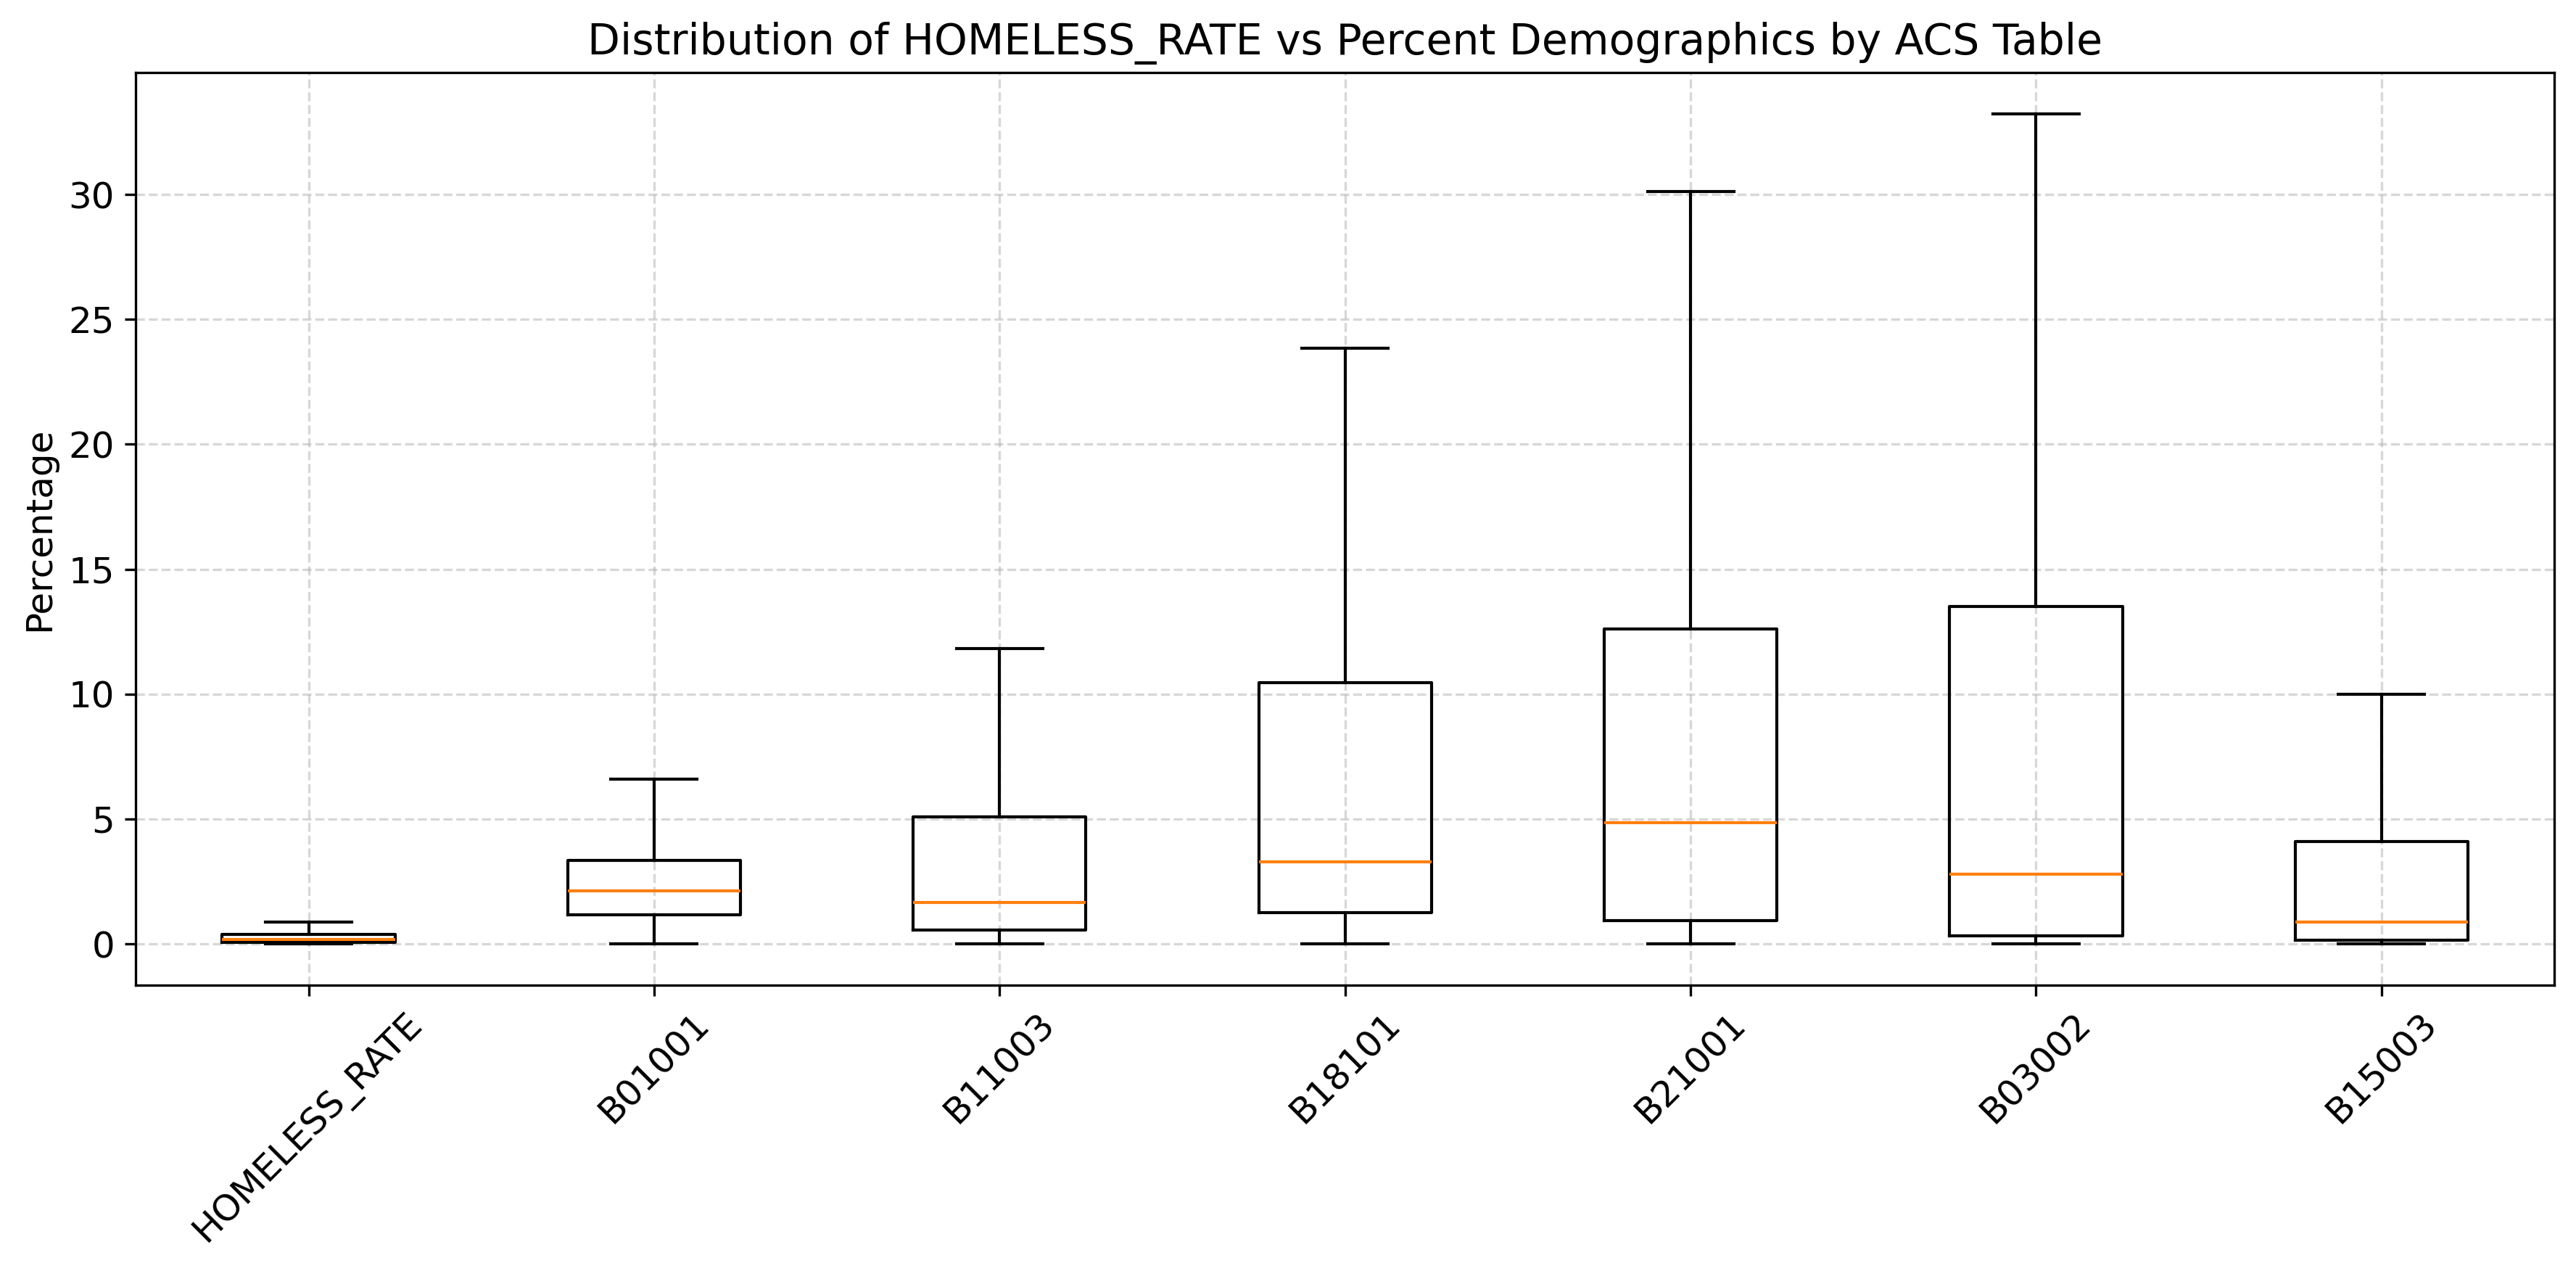

In [ ]:
# ================================================================================
# BOX PLOT OF HOMELESS_RATE VS PCT DEMOGRAPHICS BY ACS TABLE
# ================================================================================


# === File path ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets/California/Output"
region_file = os.path.join(base_path, "california_acs_master_table_region_level.csv")

# === Load region-level data ===
df = pd.read_csv(region_file)

# === Tables to include ===
acs_tables = ["B01001", "B11003", "B18101", "B21001", "B03002", "B15003"]

# === Initialize data collection ===
data_to_plot = {
    "HOMELESS_RATE": df["HOMELESS_RATE"].dropna()
}

# === Add all _PCT columns grouped by ACS table ===
for table in acs_tables:
    pct_cols = [col for col in df.columns if col.startswith(table) and col.endswith("_PCT")]
    if pct_cols:
        table_values = df[pct_cols].values.flatten()
        table_values = pd.Series(table_values)
        table_values = table_values[pd.notna(table_values)]
        data_to_plot[table] = table_values

# === Prepare plot ===
plt.figure(figsize=(12, 6))
plt.boxplot(data_to_plot.values(), labels=data_to_plot.keys(), showfliers=False)
plt.title("Distribution of HOMELESS_RATE vs Percent Demographics by ACS Table", fontsize=14)
plt.ylabel("Percentage", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# === Save plot ===
output_path = os.path.join("/content/drive/MyDrive/Kaggle/Images", "homeless_vs_acs_boxplot.png")
plt.savefig(output_path)
print(f" Box plot saved to: {output_path}")


## Convert demographic counts to regional percentages

In [ ]:
# ================================================================================
# CREATE MODEL-READY DATASET: METRO, REGION_CODE, HOMELESS_RATE,
# and _PCT DEMOGRAPHICS ONLY (NO TOTAL_POPULATION)
# ================================================================================


# === File Paths ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets/California/Output"
region_level_input = os.path.join(base_path, "california_acs_master_table_region_level_with_pct.csv")
model_ready_output = os.path.join(base_path, "california_acs_pct_only_model_ready.csv")

# === Load region-level dataset with _PCT columns ===
df = pd.read_csv(region_level_input)

# === Select relevant columns ===
keep_cols = ["METRO", "REGION_CODE", "HOMELESS_RATE"]
pct_cols = [col for col in df.columns if col.endswith("_PCT")]
final_cols = keep_cols + pct_cols

model_df = df[final_cols].copy()

# === Save model-ready CSV ===
model_df.to_csv(model_ready_output, index=False)

print(f" Model-ready file saved to: {model_ready_output}")
print(f"Rows: {len(model_df)} | Columns: {len(model_df.columns)}")


 Model-ready file saved to: /content/drive/MyDrive/Kaggle/Datasets/California/Output/california_acs_pct_only_model_ready.csv
Rows: 186 | Columns: 196


## Data QA


POPULATION COMPARISON:
METRO                     ACTUAL       CONFIG       DIFF        
-----------------------------------------------------------------
Alameda County            1,663,823    1,628,000    35,823      
Los Angeles City          3,860,698    3,823,000    37,698      
Orange County             3,175,227    3,150,000    25,227      
Riverside County          2,429,487    2,474,000    -44,513     
Sacramento County         1,579,211    1,584,000    -4,789      
San Bernardino County     2,180,563    2,195,000    -14,437     
San Diego County          3,289,701    3,277,000    12,701      
San Francisco County      827,178      807,774      19,404      
Santa Clara County        1,916,831    1,878,000    38,831      
Sonoma County             488,436      482,669      5,767       
-----------------------------------------------------------------
TOTAL                     21,411,155   21,299,443   111,712     

HOMELESS COMPARISON:
METRO                     ACTUAL     CONFI

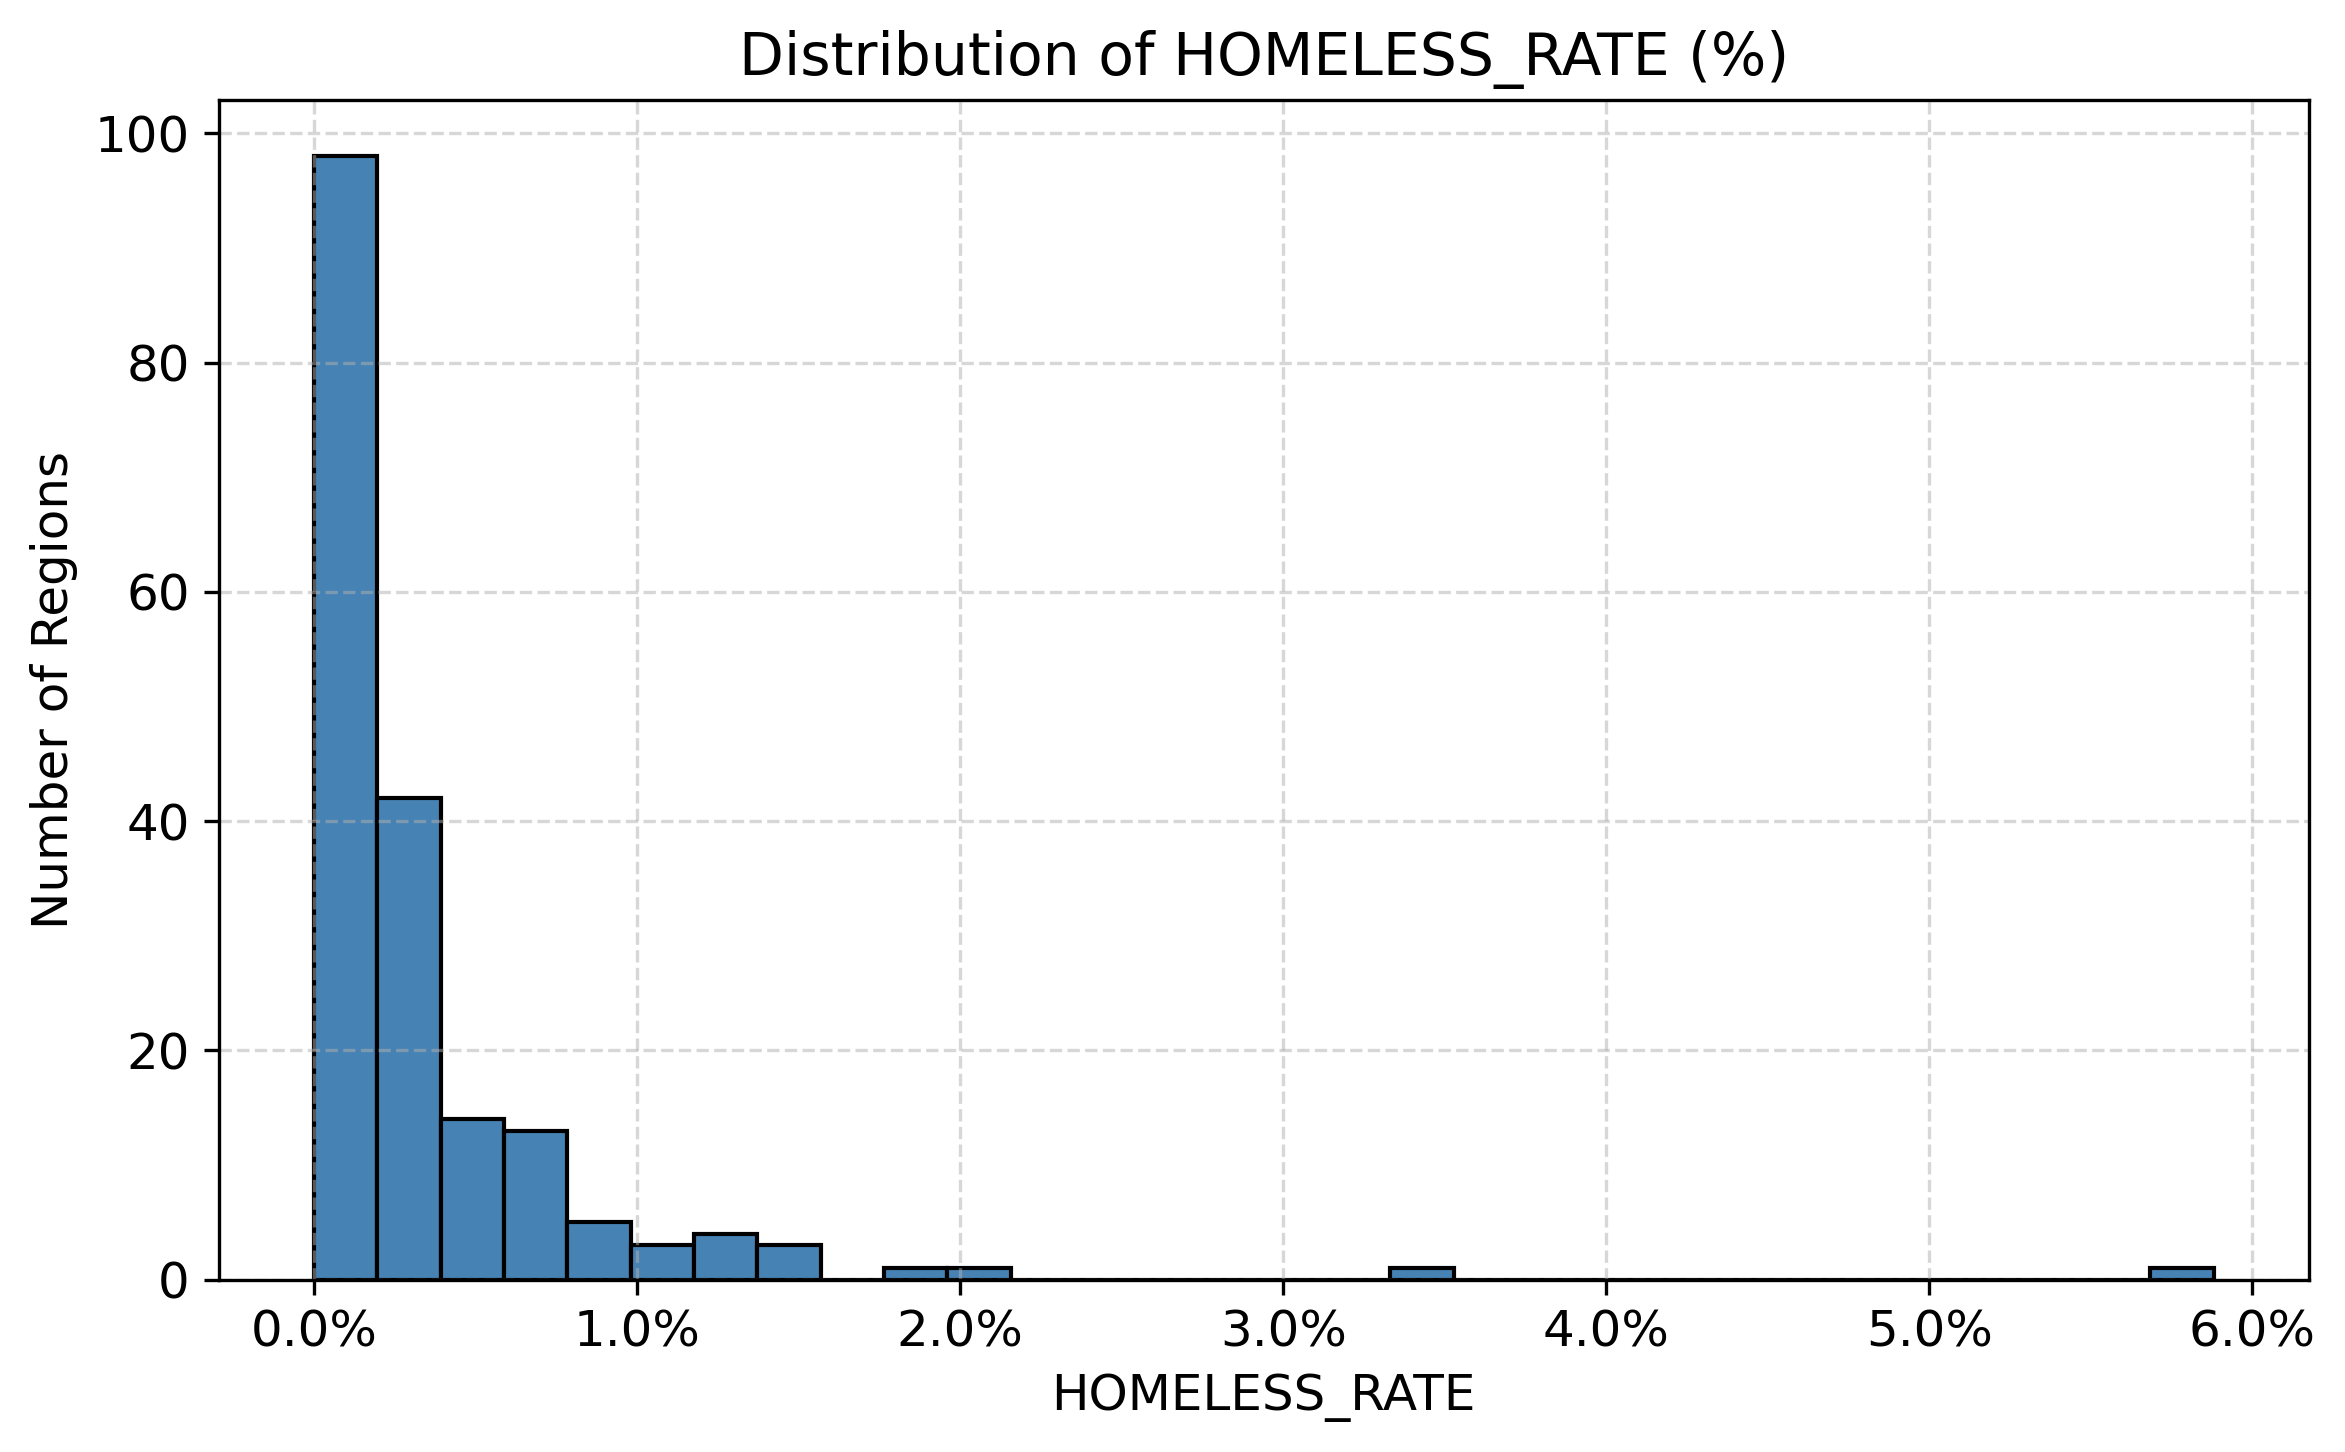

In [ ]:
# ================================================================================
# METRO COMPARISON + QA SUMMARY WITH HOMELESS RATE HISTOGRAM
# ================================================================================


# === CONFIG DATA ===
PUBLISHED_POPULATIONS = {
    "Los Angeles City": 3_823_000,
    "San Diego County": 3_277_000,
    "Orange County": 3_150_000,
    "Riverside County": 2_474_000,
    "San Bernardino County": 2_195_000,
    "Santa Clara County": 1_878_000,
    "Alameda County": 1_628_000,
    "Sacramento County": 1_584_000,
    "San Francisco County": 807_774,
    "Sonoma County": 482_669,
}

PUBLISHED_HOMELESSNESS = {
    "Los Angeles City": 41_980,
    "San Diego County": 8_427,
    "Orange County": 5_718,
    "Riverside County": 3_316,
    "San Bernardino County": 3_333,
    "Santa Clara County": 10_028,
    "Alameda County": 9_747,
    "Sacramento County": 9_278,
    "San Francisco County": 7_754,
    "Sonoma County": 2_893,
}

# === Load Region-Level Data ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets/California/Output"
region_level_output = os.path.join(base_path, "california_acs_master_table_region_level.csv")
df = pd.read_csv(region_level_output)

# === Group by METRO ===
metro_actual = df.groupby("METRO").agg({
    "TOTAL_POPULATION": "sum",
    "HOMELESS_POPULATION": "sum"
})

# === Population Comparison ===
print("\nPOPULATION COMPARISON:")
print(f"{'METRO':<25} {'ACTUAL':<12} {'CONFIG':<12} {'DIFF':<12}")
print("-" * 65)
total_actual_pop = total_config_pop = 0

for metro in sorted(metro_actual.index):
    actual_pop = metro_actual.loc[metro, "TOTAL_POPULATION"]
    config_pop = PUBLISHED_POPULATIONS.get(metro, 0)
    diff = actual_pop - config_pop
    print(f"{metro:<25} {actual_pop:<12,} {config_pop:<12,} {diff:<12,}")
    total_actual_pop += actual_pop
    total_config_pop += config_pop

print("-" * 65)
print(f"{'TOTAL':<25} {total_actual_pop:<12,} {total_config_pop:<12,} {total_actual_pop - total_config_pop:<12,}")

# === Homeless Comparison ===
print("\nHOMELESS COMPARISON:")
print(f"{'METRO':<25} {'ACTUAL':<10} {'CONFIG':<10} {'DIFF':<10}")
print("-" * 55)
total_actual_homeless = total_config_homeless = 0

for metro in sorted(metro_actual.index):
    actual_homeless = metro_actual.loc[metro, "HOMELESS_POPULATION"]
    config_homeless = PUBLISHED_HOMELESSNESS.get(metro, 0)
    diff = actual_homeless - config_homeless
    print(f"{metro:<25} {actual_homeless:<10,} {config_homeless:<10,} {diff:<10,}")
    total_actual_homeless += actual_homeless
    total_config_homeless += config_homeless

print("-" * 55)
print(f"{'TOTAL':<25} {total_actual_homeless:<10,} {total_config_homeless:<10,} {total_actual_homeless - total_config_homeless:<10,}")

# === QA CHECKS ===
print("\nQA CHECKS:")
print("=" * 15)

# 1. Check _PCT columns > 100%
pct_cols = [col for col in df.columns if col.endswith('_PCT')]
pct_violations = sum((df[pct_cols] > 100).sum())
print(f"Percentage columns > 100%: {pct_violations}")

# 2. Check HOMELESS_RATE > 10%
extreme_rates = (df["HOMELESS_RATE"] > 10).sum()
print(f"Regions with HOMELESS_RATE > 10%: {extreme_rates}")

# 3. Missing values
missing_pop = df["TOTAL_POPULATION"].isna().sum()
missing_homeless = df["HOMELESS_POPULATION"].isna().sum()
print(f"Missing TOTAL_POPULATION: {missing_pop}")
print(f"Missing HOMELESS_POPULATION: {missing_homeless}")

# 4. Duplicates
duplicates = df["REGION_CODE"].duplicated().sum()
print(f"Duplicate REGION_CODE values: {duplicates}")

# 5. Overall summary
print(f"Total regions: {len(df)}")
print(f"Total columns: {len(df.columns)}")

# 6. Verdict
total_issues = pct_violations + extreme_rates + missing_pop + missing_homeless + duplicates
print(f"\nSUMMARY: {'PASS' if total_issues == 0 else f'ISSUES FOUND: {total_issues}'}")

# === HOMELESS_RATE HISTOGRAM ===
image_output_path = "/content/drive/MyDrive/Kaggle/Images"
os.makedirs(image_output_path, exist_ok=True)
hist_path = os.path.join(image_output_path, "homeless_rate_histogram.png")

plt.figure(figsize=(8, 5))
plt.hist(df["HOMELESS_RATE"], bins=30, edgecolor="black", color="steelblue")
plt.title("Distribution of HOMELESS_RATE (%)", fontsize=14)
plt.xlabel("HOMELESS_RATE", fontsize=12)
plt.ylabel("Number of Regions", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=1))
plt.tight_layout()
plt.savefig(hist_path)

print(f"\n Histogram saved to: {hist_path}")


## Create Kaggle Data Splits

In [ ]:
# ================================================================================
# FINAL KAGGLE SPLIT: PERCENT-ONLY FEATURES, HOMELESS_RATE TARGET
# Excludes B01001_001E_PCT and TOTAL_POPULATION
# ================================================================================



# === File Paths ===
input_file = "/content/drive/MyDrive/Kaggle/Datasets/California/Output/california_acs_pct_only_model_ready.csv"
output_path = "/content/drive/MyDrive/Kaggle/Datasets/Kaggle Splits"
os.makedirs(output_path, exist_ok=True)

train_file = os.path.join(output_path, "train.csv")
test_file = os.path.join(output_path, "test.csv")
solution_file = os.path.join(output_path, "solution.csv")
sample_submission_file = os.path.join(output_path, "submission_sample.csv")

# === Load dataset ===
df = pd.read_csv(input_file)

# === Remove TOTAL_POPULATION if present ===
if "TOTAL_POPULATION" in df.columns:
    df.drop(columns=["TOTAL_POPULATION"], inplace=True)

# === Shuffle and assign unique ID ===
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.insert(0, "ID", range(len(df)))

# === Define columns ===
target_col = "HOMELESS_RATE"
id_cols = ["METRO", "REGION_CODE"]
feature_cols = [col for col in df.columns if col.endswith("_PCT") and col != "B01001_001E_PCT"]

# === Stratified split on quartiles of target ===
quartiles = pd.qcut(df[target_col], q=4, labels=False, duplicates="drop")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=quartiles)

# === Save train.csv (features + target) ===
train_df.to_csv(train_file, index=False)

# === Save test.csv (features only, no target) ===
test_df.drop(columns=[target_col]).to_csv(test_file, index=False)

# === Save solution.csv (id + target + usage split) ===
solution_df = test_df[["ID", target_col]].copy()
np.random.seed(42)
usage = ["Public"] * (len(solution_df) // 2) + ["Private"] * (len(solution_df) - len(solution_df) // 2)
np.random.shuffle(usage)
solution_df["Usage"] = usage
solution_df.to_csv(solution_file, index=False)

# === Save sample_submission.csv (id + predicted target placeholder) ===
sample_submission = solution_df[["ID", target_col]].copy()
sample_submission[target_col] = train_df[target_col].mean()
sample_submission.to_csv(sample_submission_file, index=False)

# === Print summary ===
print(f" All Kaggle files written to: {output_path}")
print(f"train.csv: {train_df.shape}")
print(f"test.csv: {test_df.shape}")
print(f"solution.csv: {solution_df.shape}")
print(f"sample_submission.csv: {sample_submission.shape}")


 All Kaggle files written to: /content/drive/MyDrive/Kaggle/Datasets/Kaggle Splits
train.csv: (130, 197)
test.csv: (56, 197)
solution.csv: (56, 3)
sample_submission.csv: (56, 2)


## Create Sandbox Submission

In [ ]:
# ================================================================================
# CREATE SANDBOX SUBMISSION: ID + HOMELESS_RATE FORMAT
# ================================================================================



# === File paths ===
base_path = "/content/drive/MyDrive/Kaggle/Datasets/Kaggle Splits"
train_file = os.path.join(base_path, "train.csv")
test_file = os.path.join(base_path, "test.csv")
solution_file = os.path.join(base_path, "solution.csv")
submission_file = os.path.join(base_path, "sandbox_submission.csv")

# === Load data ===
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
solution_df = pd.read_csv(solution_file)

# === Prepare data ===
target_col = "HOMELESS_RATE"
id_col = "ID"

X_train = train_df.drop(columns=["METRO", "REGION_CODE", target_col])
y_train = train_df[target_col]

X_test = test_df.drop(columns=["METRO", "REGION_CODE"])

# === Train model ===
model = LinearRegression()
model.fit(X_train.drop(columns=[id_col]), y_train)

# === Predict ===
preds = model.predict(X_test.drop(columns=[id_col]))

# === Create submission: ID + HOMELESS_RATE ===
submission = pd.DataFrame({
    "ID": test_df[id_col],
    "HOMELESS_RATE": preds
})

submission.to_csv(submission_file, index=False)

# === Evaluate on private solution ===
merged = submission.merge(solution_df, left_on="ID", right_on="ID")
mse = mean_squared_error(merged["HOMELESS_RATE_y"], merged["HOMELESS_RATE_x"])

# === Output ===
print(f"✅ Submission file saved: {submission_file}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Prediction range: {preds.min():.3f} to {preds.max():.3f}")


✅ Submission file saved: /content/drive/MyDrive/Kaggle/Datasets/Kaggle Splits/sandbox_submission.csv
Mean Squared Error: 11.0401
Prediction range: -7.098 to 11.196


# Appendix

## Published Population Data

In [ ]:
raise SystemExit("Execution halted for safety. Remove this line to run the code.")

# The following is captured in config.py
# -*- coding: utf-8 -*-
"""config.ipynb
Automatically generated by Colab.
Original file is located at
    https://colab.research.google.com/drive/1gmDoJEuZa28pY5yOdJgxP_geJ07As1SL
"""
# config.py

# === FILE PREFIX MAPPING ===
# Maps metro names to consistent file prefixes for naming conventions
FILE_PREFIXES = {
    "Los Angeles City": "la",
    "San Diego County": "sd",
    "Orange County": "oc",
    "Riverside County": "rv",
    "San Bernardino County": "sb",
    "Santa Clara County": "sc",
    "Alameda County": "al",
    "Sacramento County": "sa",
    "San Francisco County": "sf",
    "Sonoma County": "so",
    "California": "ca"
}

# === PUBLISHED POPULATION DATA (2022) ===
PUBLISHED_POPULATIONS = {
    "Los Angeles City": 3_823_000,
    "San Diego County": 3_277_000,
    "Orange County": 3_150_000,
    "Riverside County": 2_474_000,
    "San Bernardino County": 2_195_000,
    "Santa Clara County": 1_878_000,
    "Alameda County": 1_628_000,
    "Sacramento County": 1_584_000,
    "San Francisco County": 807_774,
    "Sonoma County": 482_669,
}

# === PUBLISHED HOMELESSNESS DATA (2022) ===
PUBLISHED_HOMELESSNESS = {
    "Los Angeles City": 41_980,
    "San Diego County": 8_427,
    "Orange County": 5_718,
    "Riverside County": 3_316,
    "San Bernardino County": 3_333,
    "Santa Clara County": 10_028,
    "Alameda County": 9_747,
    "Sacramento County": 9_278,
    "San Francisco County": 7_754,
    "Sonoma County": 2_893,
}

SystemExit: Execution halted for safety. Remove this line to run the code.

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Documentation

In [ ]:
raise SystemExit("Execution halted for safety. Remove this line to run the code.")

===============================================================================
1. ALAMEDA COUNTY
===============================================================================

=== Homelessness Data ===
Reporting Agency: EveryOne Home (Alameda County CoC)
Agency URL: https://homelessness.acgov.org/
File URL: https://homelessness.acgov.org/homelessness-assets/docs/reports/2022-Alameda-County-PIT-Report_9.22.22-FINAL-3.pdf
Year: 2022 Point-in-Time Count

=== ACS Census Data ===
Reporting Agency: U.S. Census Bureau
Agency URL: https://www.census.gov
File URL: https://data.census.gov/table/ACSDT5Y2022.B01003
Year: 2018–2022 ACS 5-Year Estimates

=== City/Place Boundaries ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/PLACE/tl_2022_06_place.zip
Year: 2022

=== Census Tract Shapefiles ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_06_tract.zip
Year: 2022

===============================================================================
2. LOS ANGELES COUNTY
===============================================================================

=== Homelessness Data ===
Reporting Agency: Los Angeles Homeless Services Authority (LAHSA)
Agency URL: https://www.lahsa.org/
File URL: https://www.lahsa.org/documents?id=6532-countywide-geography-summary.pdf
Year: 2022 Point-in-Time Count
Note: City Council Districts used for additional detail.

=== ACS Census Data ===
Reporting Agency: U.S. Census Bureau
Agency URL: https://www.census.gov
File URL: https://data.census.gov/table/ACSDT5Y2022.B01003
Year: 2018–2022 ACS 5-Year Estimates

=== Council District Boundaries ===
Reporting Agency: Los Angeles County GIS
Agency URL: https://egis-lacounty.hub.arcgis.com/
File URL: https://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Political_Boundaries/MapServer/27
Year: 2022

=== Census Tract Shapefiles ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_06_tract.zip
Year: 2022

===============================================================================
3. ORANGE COUNTY
===============================================================================

=== Homelessness Data ===
Reporting Agency: Orange County HMIS
Agency URL: https://ochmis.org/
File URL: https://ochmis.org/wp-content/uploads/2022/05/2022-Pit-Data-Infographic-5.10.2022-Final.pdf
Year: 2022 Point-in-Time Count

=== ACS Census Data ===
Reporting Agency: U.S. Census Bureau
Agency URL: https://www.census.gov
File URL: https://data.census.gov/table/ACSDT5Y2022.B01003
Year: 2018–2022 ACS 5-Year Estimates

=== City/Place Boundaries ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/PLACE/tl_2022_06_place.zip
Year: 2022

=== Census Tract Shapefiles ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_06_tract.zip
Year: 2022

===============================================================================
4. RIVERSIDE COUNTY
===============================================================================

=== Homelessness Data ===
Reporting Agency: Housing Authority of the County of Riverside
Agency URL: https://harivco.org/
File URL: https://kesq.b-cdn.net/2022/05/2022_Homeless_PITC.pdf
Year: 2022 Point-in-Time Count

=== ACS Census Data ===
Reporting Agency: U.S. Census Bureau
Agency URL: https://www.census.gov
File URL: https://data.census.gov/table/ACSDT5Y2022.B01003
Year: 2018–2022 ACS 5-Year Estimates

=== City/Place Boundaries ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/PLACE/tl_2022_06_place.zip
Year: 2022

=== Census Tract Shapefiles ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_06_tract.zip
Year: 2022



===============================================================================
5. SACRAMENTO COUNTY
===============================================================================

=== Homelessness Data ===
Reporting Agency: Sacramento Steps Forward
Agency URL: https://sacramentostepsforward.org/2022-pit-count-report-released/
File URL: https://sacramentostepsforward.org/wp-content/uploads/2022/06/PIT-Report-2022.pdf
Year: 2022 Point-in-Time Count
Note: Sub-region totals required manual addition of HIC data to supplement PIT detail. 2-person discrepancy remains vs. HUD total (0.02% difference).

=== ACS Census Data ===
Reporting Agency: U.S. Census Bureau
Agency URL: https://www.census.gov
File URL: https://data.census.gov/table/ACSDT5Y2022.B01003
Year: 2018–2022 ACS 5-Year Estimates

=== City/Place Boundaries ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/PLACE/tl_2022_06_place.zip
Year: 2022

=== Census Tract Shapefiles ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_06_tract.zip
Year: 2022

===============================================================================
6. SAN BERNARDINO COUNTY
===============================================================================

=== Homelessness Data ===
Reporting Agency: San Bernardino County
Agency URL: https://main.sbcounty.gov/
File URL: https://www.sbcounty.gov/uploads/sbchp/SBC-2022-Homeless-Count-Report.pdf
Year: 2022 Point-in-Time Count

=== ACS Census Data ===
Reporting Agency: U.S. Census Bureau
Agency URL: https://www.census.gov
File URL: https://data.census.gov/table/ACSDT5Y2022.B01003
Year: 2018–2022 ACS 5-Year Estimates

=== City/Place Boundaries ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/PLACE/tl_2022_06_place.zip
Year: 2022

=== Census Tract Shapefiles ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_06_tract.zip
Year: 2022




===============================================================================
7. SAN DIEGO COUNTY
===============================================================================

=== Homelessness Data ===
Reporting Agency: Regional Task Force on Homelessness (RTFH)
Agency URL: https://www.rtfhsd.org/
File URL: https://www.rtfhsd.org/wp-content/uploads/2025/01/2022-San-Diego-Region-Cities-Sheltered-and-Unsheltered-Breakdown-FINAL_05182022.pdf
Year: 2022 Point-in-Time Count
Note: 16 cities plus unincorporated region used.

=== ACS Census Data ===
Reporting Agency: U.S. Census Bureau
Agency URL: https://www.census.gov
File URL: https://data.census.gov/table/ACSDT5Y2022.B01003
Year: 2018–2022 ACS 5-Year Estimates

=== City/Place Boundaries ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/PLACE/tl_2022_06_place.zip
Year: 2022

=== Census Tract Shapefiles ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_06_tract.zip
Year: 2022

===============================================================================
8. SAN FRANCISCO COUNTY
===============================================================================

=== Homelessness Data ===
Reporting Agency: SF Department of Homelessness & Supportive Housing (HSH)
Agency URL: https://hsh.sfgov.org/
File URL: https://hsh.archive.sf.gov/wp-content/uploads/2022/08/2022-PIT-Count-Report-San-Francisco-Updated-8.19.22.pdf
Year: 2022 Point-in-Time Count
Note: Supervisorial Districts used for additional detail.

=== ACS Census Data ===
Reporting Agency: U.S. Census Bureau
Agency URL: https://www.census.gov
File URL: https://data.census.gov/table/ACSDT5Y2022.B01003
Year: 2018–2022 ACS 5-Year Estimates

=== Supervisorial District Boundaries ===
Reporting Agency: SF Department of Elections / DataSF
Agency URL: https://data.sfgov.org/
File URL: https://data.sfgov.org/Geographic-Locations/Supervisorial-Districts-2022/yjzx-k7si
Year: 2022

=== Census Tract Shapefiles ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_06_tract.zip
Year: 2022


===============================================================================
9. SANTA CLARA COUNTY
===============================================================================

=== Homelessness Data ===
Reporting Agency: Santa Clara County Continuum of Care
Agency URL: https://www.santaclaracounty.gov/
File URL: https://files.santaclaracounty.gov/exjcpb1571/migrated/2022%20PIT%20Report%20Santa%20Clara%20County.pdf
Year: 2022 Point-in-Time Count

=== ACS Census Data ===
Reporting Agency: U.S. Census Bureau
Agency URL: https://www.census.gov
File URL: https://data.census.gov/table/ACSDT5Y2022.B01003
Year: 2018–2022 ACS 5-Year Estimates

=== City/Place Boundaries ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/PLACE/tl_2022_06_place.zip
Year: 2022

=== Census Tract Shapefiles ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_06_tract.zip
Year: 2022

===============================================================================
10. SONOMA COUNTY
===============================================================================

=== Homelessness Data ===
Reporting Agency: Sonoma County Continuum of Care / County of Sonoma
Agency URL: https://sonomacounty.gov/
File URL: https://sonomacounty.gov/Main%20County%20Site/Health%20and%20Human%20Services/Health%20Services/Documents/Homelessness%20Services/Homeless%20Data/County%20of%20Sonoma%202022%20Point-in-Time%20Count%20Results.pdf
Year: 2022 Point-in-Time Count

=== ACS Census Data ===
Reporting Agency: U.S. Census Bureau
Agency URL: https://www.census.gov
File URL: https://data.census.gov/table/ACSDT5Y2022.B01003
Year: 2018–2022 ACS 5-Year Estimates

=== City/Place Boundaries ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/PLACE/tl_2022_06_place.zip
Year: 2022

=== Census Tract Shapefiles ===
Reporting Agency: U.S. Census Bureau TIGER/Line
Agency URL: https://www.census.gov
File URL: https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_06_tract.zip
Year: 2022